# Initialization

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
#import tensorflow.math as tfm
from tensorflow import math as tfm
#import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
#import cartopy.crs as ccrs
import matplotlib.ticker as mticker
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
import sklearn
from sklearn.linear_model import LinearRegression
from scipy import stats

# Otherwise tensorflow will use ALL your GPU RAM for no reason
#limit_mem()

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


In [2]:
fz = 15
lw = 4
siz = 100
S0 = 320 # Representative mean solar insolation for normalization purposes
S0max = 1410.6442 # Max solar insolation for normalization purposes
SN = S0/100 # Representative target = mean insolation / 4
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YMIN = -1 # Representative value for conserving network
YTEXT = 0.3 # Text placement

In [3]:
plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

# Libraries

In [4]:
def dP(PS):    
    S = PS.shape
    P = 1e5 * np.moveaxis(np.tile(hyai,(S[0],S[1],S[2],1)),3,1) + \
    np.moveaxis(np.tile(PS.values,(31,1,1,1)),0,1) * np.moveaxis(np.tile(hybi,(S[0],S[1],S[2],1)),3,1)
    return P[:, 1:]-P[:, :-1]

In [5]:
# Moist thermo library in numpy
def eliq(T):
    a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
    c_liq = -80
    T0 = 273.16
    return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

def eice(T):
    a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
    c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
    T0 = 273.16
    return (T>c_ice[0])*eliq(T)+\
(T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
(T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))    

def esat(T):
    T0 = 273.16
    T00 = 253.16
    omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))
    
    return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))

def RH(T,qv,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = (hyam*P0+hybm*PS).values # Total pressure (Pa)

    return Rv*p*qv/(R*esat(T))

def RHsurf(T,qv,P0,PS):
    R = 287
    Rv = 461
    
    return Rv*PS*qv/(R*esat(T))

def qv(T,RH,P0,PS,hyam,hybm):
    R = 287
    Rv = 461
    p = (hyam*P0+hybm*PS).values # Total pressure (Pa)
    
    return R*esat(T)*RH/(Rv*p)

def qsat(T,P0,PS,hyam,hybm):
    return qv(T,1,P0,PS,hyam,hybm)

In [6]:
def edg2bin(bin_edges):
    return 0.5*(bin_edges[1:]+bin_edges[:-1])

In [7]:
def CRH(inp,input_sub,input_div):

    qv0 = inp[:,:30]*input_div[:30]+input_sub[:30]
    T = inp[:,30:60]*input_div[30:60]+input_sub[30:60]
    ps = inp[:,60]*input_div[60]+input_sub[60]

    dP0 = dP(ps)
    qsat0 = qsat(T,P0,ps,hyam,hybm)

    return np.sum(qv0*dP0,axis=1)/np.sum(qsat0*dP0,axis=1)

In [8]:
def qsatsurf(TS,P0,PS):
    R = 287
    Rv = 461
    return R*esat(TS)/(Rv*PS)

In [9]:
# From https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-np
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.
    values, weights -- np ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

# Make function to calculate conditional mean and std
# We condition field_y on field_x
def conditional_avg_and_std(bin_edges,field_x,field_y):
    # Initialization
    Nbin = np.size(bin_edges)
    Ym = np.zeros((Nbin-1,1))
    Ystd = np.copy(Ym)

    for ibin,edge in enumerate(bin_edges):
        print('ibin=',ibin,'/',Nbin-1,' & edge=',edge,end="\r")
        if ibin>0:
            w = (field_x>=edge_left)*(field_x<edge)
            if np.sum(w)>0: Ym[ibin-1],Ystd[ibin-1] = weighted_avg_and_std(field_y,w)
            else: Ym[ibin-1] = np.nan; Ystd[ibin-1] = np.nan;

        edge_left = edge
    
    return Ym,Ystd

# Load data

In [10]:
#path = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.'
path = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.'
#path = '/scratch/05823/tg851228/CBRAIN/sp8fbp_minus4k/sp8fbp_minus4k.cam2.h2.'

# datam4K = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
#                           decode_times=False)
datam4K = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
                          decode_times=False)

/DFS-L/DATA/pritchard/tbeucler/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/DFS-L/DATA/pritchard/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [11]:
#path = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_4k/sp8fbp_4k.cam2.h2.'
path = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/sp8fbp_4k/sp8fbp_4k.cam2.h2.'
#path = '/scratch/05823/tg851228/CBRAIN/sp8fbp_4k/sp8fbp_4k.cam2.h2.'

# datap4K = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
#                            decode_times=False)
datap4K = xr.open_mfdataset(path+'0001-0?-15-00000.nc',\
                           decode_times=False)

In [12]:
path = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.'
#path = '/scratch/05823/tg851228/CBRAIN/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.'
# dataref = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
#                            decode_times=False)
dataref = xr.open_mfdataset(path+'0001-01-0?-00000.nc',\
                           decode_times=False)

# Find vertical rescaling using RH and T profiles

## Using RH

### Testing RH scaling at a single level for Figure 1

In [69]:
RH0.shape

(432, 30, 64, 128)

In [73]:
d.QAP.lev[22]

<xarray.DataArray 'lev' ()>
array(820.858369)
Coordinates:
    lev      float64 820.9
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          level
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

In [75]:
QHIST = {}
RHHIST = {}
QSLHIST = {}
RHSLHIST = {}
ilev = 22

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
        
    RH0 = RH(d.TAP,d.QAP,d.P0,d.PS,d.hyam,d.hybm)
    RH0 = np.minimum(1,RH0)
    
    QHIST[data] = np.histogram(d.QAP.values.flatten(),bins=100,density=True)
    RHHIST[data] = np.histogram(RH0.values.flatten(),bins=100,density=True)
    
    QSLHIST[data] = np.histogram(d.QAP[:,ilev,:,:].values.flatten(),bins=100,density=True)
    RHSLHIST[data] = np.histogram(RH0[:,ilev,:,:].values.flatten(),bins=100,density=True)

data= m4K
data= ref
data= p4K


In [76]:
#COL = ['b','gray','r']
COL = ['b','r']
Label = ['Reference Climate','Target Climate']

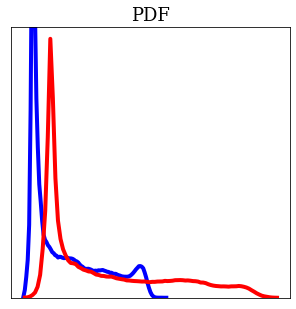

In [77]:
plt.figure(figsize=(5,5))
for idata,data in enumerate(['m4K','p4K']):
    plt.plot(edg2bin(QSLHIST[data][1]),QSLHIST[data][0],color=COL[idata],label=Label[idata])
plt.ylim((-1,500))
plt.title('PDF')
#plt.legend(fontsize=1.5*fz)

frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)

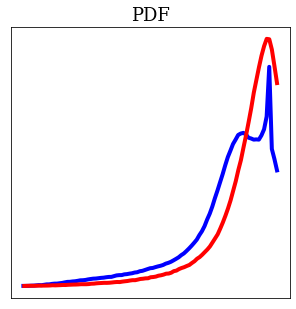

In [79]:
plt.figure(figsize=(5,5))
for idata,data in enumerate(['m4K','p4K']):
    plt.plot(edg2bin(RHSLHIST[data][1][:-1]),RHSLHIST[data][0][:-1],color=COL[idata])
#plt.ylim((0,2))

plt.title('PDF')
#plt.legend(fontsize=1.5*fz)

frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)

In [ ]:
RHm4K = RH(datam4K.TAP,datam4K.QAP,datam4K.P0,datam4K.PS,datam4K.hyam,datam4K.hybm)

### Testing vertical coordinate change

In [14]:
def T_tilde(T,Tref=220):
    return (T-Tref)/(T[:,-1,:,:]-Tref)

In [16]:
RHm4K = RH(datam4K.TAP,datam4K.QAP,datam4K.P0,datam4K.PS,datam4K.hyam,datam4K.hybm)

In [22]:
RHref = RH(dataref.TAP,dataref.QAP,dataref.P0,dataref.PS,dataref.hyam,dataref.hybm)

In [23]:
RHp4K = RH(datap4K.TAP,datap4K.QAP,datap4K.P0,datap4K.PS,datap4K.hyam,datap4K.hybm)

In [18]:
RHm4K

<xarray.DataArray (time: 432, lev: 30, lat: 64, lon: 128)>
dask.array<shape=(432, 30, 64, 128), dtype=float64, chunksize=(48, 30, 64, 128)>
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) float64 365.0 365.0 365.0 365.1 ... 373.9 373.9 374.0 374.0

In [29]:
RHm4K.lat[32-10:32+10]

<xarray.DataArray 'lat' (lat: 20)>
array([-26.510769, -23.720174, -20.929574, -18.138971, -15.348365, -12.557756,
        -9.767146,  -6.976534,  -4.185921,  -1.395307,   1.395307,   4.185921,
         6.976534,   9.767146,  12.557756,  15.348365,  18.138971,  20.929574,
        23.720174,  26.510769])
Coordinates:
  * lat      (lat) float64 -26.51 -23.72 -20.93 -18.14 ... 20.93 23.72 26.51
Attributes:
    long_name:  latitude
    units:      degrees_north

In [37]:
ilatmin = 22
ilatmax = 42

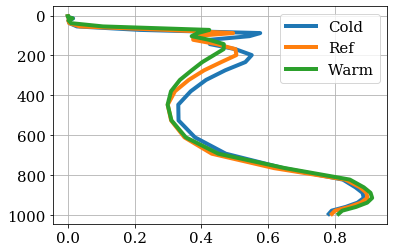

In [38]:
plt.plot(RHm4K[:,:,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),RHm4K.lev,label='Cold')
plt.plot(RHref[:,:,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),RHref.lev,label='Ref')
plt.plot(RHp4K[:,:,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),RHp4K.lev,label='Warm')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()

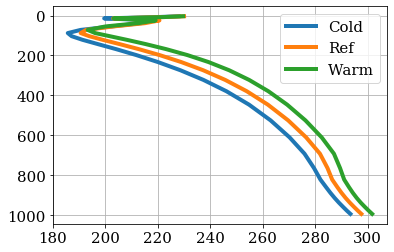

In [39]:
plt.plot(datam4K.TAP[:,:,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),RHm4K.lev,label='Cold')
plt.plot(dataref.TAP[:,:,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),RHref.lev,label='Ref')
plt.plot(datap4K.TAP[:,:,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),RHp4K.lev,label='Warm')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()

In [40]:
Tm4K_tilde = T_tilde(datam4K.TAP)
Tref_tilde = T_tilde(dataref.TAP)
Tp4K_tilde = T_tilde(datap4K.TAP)

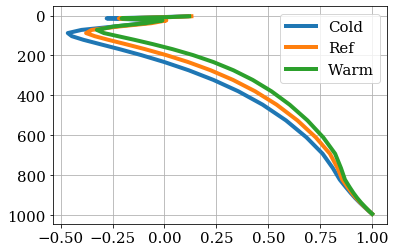

In [41]:
plt.plot(Tm4K_tilde[:,:,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),RHm4K.lev,label='Cold')
plt.plot(Tref_tilde[:,:,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),RHref.lev,label='Ref')
plt.plot(Tp4K_tilde[:,:,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),RHp4K.lev,label='Warm')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()

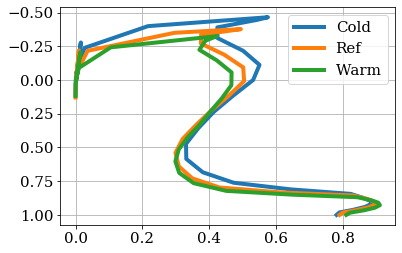

In [43]:
plt.plot(RHm4K[:,:,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),
         Tm4K_tilde[:,:,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),label='Cold')
plt.plot(RHref[:,:,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),
         Tref_tilde[:,:,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),label='Ref')
plt.plot(RHp4K[:,:,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),
         Tp4K_tilde[:,:,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),label='Warm')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()

In [120]:
ilevmin = 6
ilevmax = 30

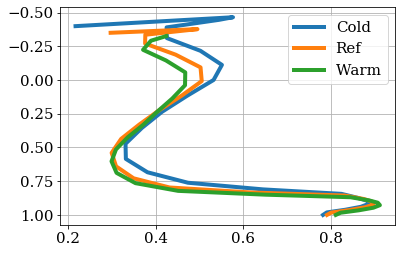

In [121]:
plt.plot(RHm4K[:,ilevmin:ilevmax,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),
         Tm4K_tilde[:,ilevmin:ilevmax,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),label='Cold')
plt.plot(RHref[:,ilevmin:ilevmax,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),
         Tref_tilde[:,ilevmin:ilevmax,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),label='Ref')
plt.plot(RHp4K[:,ilevmin:ilevmax,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),
         Tp4K_tilde[:,ilevmin:ilevmax,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),label='Warm')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()

In [122]:
import scipy.interpolate as interp

In [123]:
RHm4K.shape

(432, 30, 64, 128)

In [124]:
Tm4K_tilde.shape

(432, 30, 64, 128)

In [125]:
RHm4K_tilde = interp.interp1d(Tm4K_tilde[:,ilevmin:ilevmax,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),
                              RHm4K[:,ilevmin:ilevmax,ilatmin:ilatmax,:].values,axis=1)
RHref_tilde = interp.interp1d(Tref_tilde[:,ilevmin:ilevmax,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),
                              RHref[:,ilevmin:ilevmax,ilatmin:ilatmax,:].values,axis=1)
RHp4K_tilde = interp.interp1d(Tp4K_tilde[:,ilevmin:ilevmax,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),
                              RHp4K[:,ilevmin:ilevmax,ilatmin:ilatmax,:].values,axis=1)

In [130]:
xtest = np.linspace(-0.3,1,100)

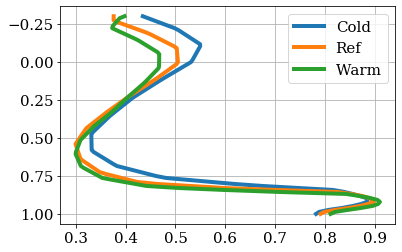

In [131]:
plt.plot(RHm4K_tilde(xtest).mean(axis=(0,2,3)),xtest,label='Cold')
plt.plot(RHref_tilde(xtest).mean(axis=(0,2,3)),xtest,label='Ref')
plt.plot(RHp4K_tilde(xtest).mean(axis=(0,2,3)),xtest,label='Warm')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()

In [81]:
histm4K, edgm4K = np.histogram(RHm4K_tilde(0).flatten(),bins=100)
histref, edgref = np.histogram(RHref_tilde(0).flatten(),bins=100)
histp4K, edgp4K = np.histogram(RHp4K_tilde(0).flatten(),bins=100)

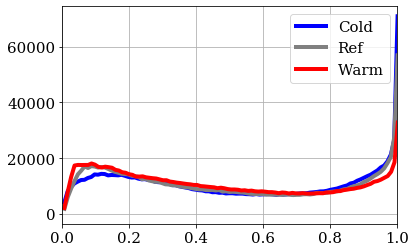

In [85]:
plt.plot(edg2bin(edgm4K),histm4K,label='Cold',color='b')
plt.plot(edg2bin(edgref),histref,label='Ref',color='gray')
plt.plot(edg2bin(edgp4K),histp4K,label='Warm',color='r')
plt.xlim((0,1))
plt.legend()
plt.grid()

In [89]:
Tref_tilde_np = Tref_tilde[:,:,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')).values

In [90]:
i0 = np.argmin(np.abs(Tref_tilde_np))

In [92]:
i0,Tref_tilde_np[i0]

(12, 0.007888239)

In [94]:
histm4K, edgm4K = np.histogram(RHm4K[:,i0,ilatmin:ilatmax,:].values.flatten(),bins=100)
histref, edgref = np.histogram(RHref[:,i0,ilatmin:ilatmax,:].values.flatten(),bins=100)
histp4K, edgp4K = np.histogram(RHp4K[:,i0,ilatmin:ilatmax,:].values.flatten(),bins=100)

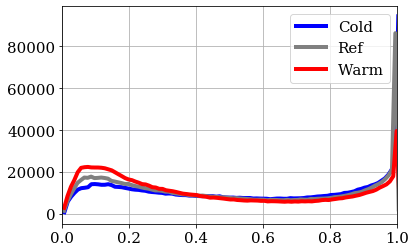

In [95]:
plt.plot(edg2bin(edgm4K),histm4K,label='Cold',color='b')
plt.plot(edg2bin(edgref),histref,label='Ref',color='gray')
plt.plot(edg2bin(edgp4K),histp4K,label='Warm',color='r')
plt.xlim((0,1))
plt.legend()
plt.grid()

In [105]:
perc_array = [25,50,75]
linest_array = ['--','-','--']

In [107]:
RHm4K_percentiles = {}
RHref_percentiles = {}
RHp4K_percentiles = {}

for i,perc in enumerate(perc_array):
    RHm4K_percentiles[perc] = np.percentile(a=RHm4K[:,:,ilatmin:ilatmax,:].values,q=perc,axis=(0,2,3))
    RHref_percentiles[perc] = np.percentile(a=RHref[:,:,ilatmin:ilatmax,:].values,q=perc,axis=(0,2,3))
    RHp4K_percentiles[perc] = np.percentile(a=RHp4K[:,:,ilatmin:ilatmax,:].values,q=perc,axis=(0,2,3))

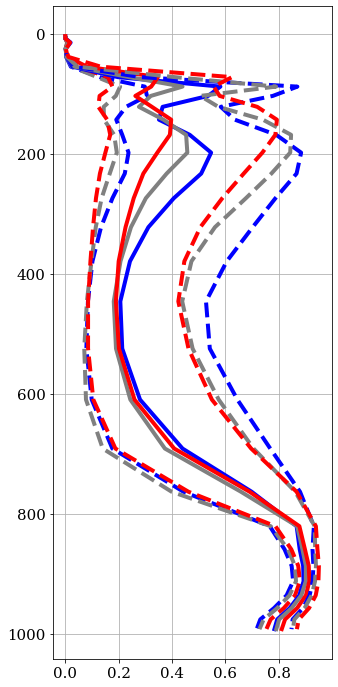

In [111]:
plt.figure(figsize=(5,12))
for i,perc in enumerate(perc_array):
    plt.plot(RHm4K_percentiles[perc],RHm4K.lev,color='b',linestyle=linest_array[i])
    plt.plot(RHref_percentiles[perc],RHref.lev,color='gray',linestyle=linest_array[i])
    plt.plot(RHp4K_percentiles[perc],RHp4K.lev,color='r',linestyle=linest_array[i])
#plt.legend()
plt.grid()
plt.gca().invert_yaxis()

In [132]:
xtest = np.linspace(-0.3,1,25)

In [133]:
RHm4K_t_percentiles = {}
RHref_t_percentiles = {}
RHp4K_t_percentiles = {}

for i,perc in enumerate(perc_array):
    RHm4K_t_percentiles[perc] = np.percentile(a=RHm4K_tilde(xtest),q=perc,axis=(0,2,3))
    RHref_t_percentiles[perc] = np.percentile(a=RHref_tilde(xtest),q=perc,axis=(0,2,3))
    RHp4K_t_percentiles[perc] = np.percentile(a=RHp4K_tilde(xtest),q=perc,axis=(0,2,3))

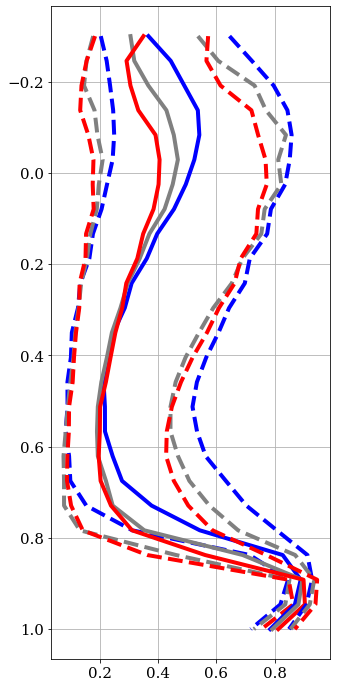

In [134]:
plt.figure(figsize=(5,12))
for i,perc in enumerate(perc_array):
    plt.plot(RHm4K_t_percentiles[perc],xtest,color='b',linestyle=linest_array[i])
    plt.plot(RHref_t_percentiles[perc],xtest,color='gray',linestyle=linest_array[i])
    plt.plot(RHp4K_t_percentiles[perc],xtest,color='r',linestyle=linest_array[i])
#plt.legend()
plt.grid()
plt.gca().invert_yaxis()

## Buoyancy without reference density (following Ahmed et al. 2018)

Theta e calculation from Griffin's repository [https://nbviewer.jupyter.org/github/gmooers96/CBRAIN-CAM/blob/master/MAPS/Mooers_Logbook/Fully_Convolutional_W/W_Metrics_Trackable_Test_Data.ipynb]

In [13]:
def theta_e_calc(press_hPa, temp, q):
    pref = 100000.
    tmelt  = 273.15
    CPD = 1005.7
    CPV=1870.0
    CPVMCL=2320.0
    RV=461.5
    
    RD=287.04
    EPS=RD/RV
    ALV0=2.501E6
    #press, tempc,theta_e
    #cdef double r,ev_hPa, TL, chi_e
    press = press_hPa * 100. # in Pa
    tempc = temp - tmelt # in C
    #print(q.values.mean())
    r = q / (1. - q)
    # get ev in hPa 
    ev_hPa = press_hPa * r / (EPS + r)
    #get TL
    TL = (2840. / ((3.5*np.log(temp)) - (np.log(ev_hPa)) - 4.805)) + 55.
    #calc chi_e:
    chi_e = 0.2854 * (1. - (0.28*r))
    theta_e = temp * (pref / press)**chi_e * np.exp(((3.376/TL) - 0.00254) * r * 1000. * (1. + (0.81 * r)))
    return theta_e

def theta_e_sat_calc(press_hPa, temp):
    pref = 100000.
    tmelt  = 273.15
    CPD = 1005.7
    CPV=1870.0
    CPVMCL=2320.0
    RV=461.5
    RD=287.04
    EPS=RD/RV
    ALV0=2.501E6
    #press, tempc,theta_e
    #cdef double r,ev_hPa, TL, chi_e
    press = press_hPa * 100. # in Pa
    tempc = temp - tmelt # in C
    
    #e_sat = 6.11*1e2*np.exp((17.3*tempc)/(tempc+273.15))
    e_sat = esat(temp)
    q = 0.622*e_sat/(press-(1-0.622)*e_sat)
    #print('qsat',q.values.mean())
    
    r = q / (1. - q)
    # get ev in hPa 
    ev_hPa = press_hPa * r / (EPS + r)
    #get TL
    TL = (2840. / ((3.5*np.log(temp)) - (np.log(ev_hPa)) - 4.805)) + 55.
    #calc chi_e:
    chi_e = 0.2854 * (1. - (0.28*r))
    theta_e = temp * (pref / press)**chi_e * np.exp(((3.376/TL) - 0.00254) * r * 1000. * (1. + (0.81 * r)))
    return theta_e

In [14]:
def B_cons(p,T,Q):
    return G*(theta_e_calc(p,T,Q)[:,-1,:,:]-theta_e_sat_calc(p,T))/theta_e_sat_calc(p,T)    

In [15]:
def B_env(p,T,Q):
    return G*(theta_e_calc(p,T,Q)-theta_e_sat_calc(p,T))/theta_e_sat_calc(p,T)    

In [16]:
def B_cons_customlev(p,T,Q,lev):
    return G*(theta_e_calc(p,T,Q)[:,lev,:,:]-theta_e_sat_calc(p,T))/theta_e_sat_calc(p,T)    

In [17]:
B_CONS_CUST = {}
for ilev in range(30):
    B_CONS_CUST[ilev] = {}

In [18]:
for icount,ilev in enumerate(np.arange(10,30)):
    print('ilev=',ilev)
    for idata,data in enumerate(['m4K','ref','p4K']):
        print('data=',data)

        if idata==0: d = datam4K
        elif idata==1: d = dataref
        elif idata==2: d = datap4K

        B_CONS_CUST[ilev][data] = np.histogram(B_cons_customlev(d.lev,d.TAP,d.QAP,ilev).values.flatten(),bins=100)

ilev= 10
data= m4K
data= ref
data= p4K
ilev= 11
data= m4K
data= ref
data= p4K
ilev= 12
data= m4K
data= ref
data= p4K
ilev= 13
data= m4K
data= ref
data= p4K
ilev= 14
data= m4K
data= ref
data= p4K
ilev= 15
data= m4K
data= ref
data= p4K
ilev= 16
data= m4K
data= ref
data= p4K
ilev= 17
data= m4K
data= ref
data= p4K
ilev= 18
data= m4K
data= ref
data= p4K
ilev= 19
data= m4K
data= ref
data= p4K
ilev= 20
data= m4K
data= ref
data= p4K
ilev= 21
data= m4K
data= ref
data= p4K
ilev= 22
data= m4K
data= ref
data= p4K
ilev= 23
data= m4K
data= ref
data= p4K
ilev= 24
data= m4K
data= ref
data= p4K
ilev= 25
data= m4K
data= ref
data= p4K
ilev= 26
data= m4K
data= ref
data= p4K
ilev= 27
data= m4K
data= ref
data= p4K
ilev= 28
data= m4K
data= ref
data= p4K
ilev= 29
data= m4K
data= ref
data= p4K


In [205]:
Theta_e_m4K = theta_e_calc(datam4K.lev,datam4K.TAP,datam4K.QAP)
Theta_esat_m4K = theta_e_sat_calc(datam4K.lev,datam4K.TAP)

0.0015716902
qsat 0.0033379595629478703


In [200]:
ilevmin = 8

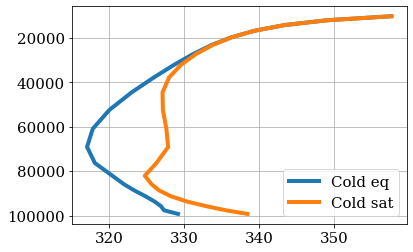

In [201]:
plt.plot(Theta_e_m4K[:,ilevmin:,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),RHm4K.lev[ilevmin:],label='Cold eq')
plt.plot(Theta_esat_m4K[:,ilevmin:,ilatmin:ilatmax,:].mean(dim=('time','lat','lon')),RHm4K.lev[ilevmin:],label='Cold sat')
plt.gca().invert_yaxis()
plt.grid()
plt.legend()

In [212]:
B = G*(Theta_e_m4K[:,-1,:,:]-Theta_esat_m4K)/Theta_esat_m4K

In [217]:
B

<xarray.DataArray (time: 432, lat: 64, lon: 128, lev: 30)>
dask.array<shape=(432, 64, 128, 30), dtype=float64, chunksize=(48, 64, 128, 30)>
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) float64 365.0 365.0 365.0 365.1 ... 373.9 373.9 374.0 374.0

In [216]:
Benv = G*(Theta_e_m4K-Theta_esat_m4K)/Theta_esat_m4K

In [222]:
ilatmin = 0
ilatmax = 4

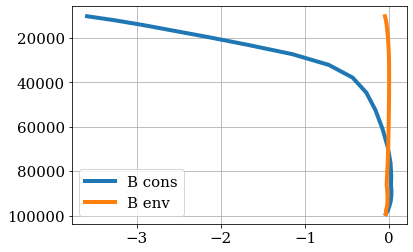

In [223]:
plt.plot(B[:,ilatmin:ilatmax,:,ilevmin:].mean(dim=('time','lon','lat')),RHm4K.lev[ilevmin:],label='B cons')
plt.plot(Benv[:,ilevmin:,ilatmin:ilatmax,:].mean(dim=('time','lon','lat')),RHm4K.lev[ilevmin:],label='B env')
plt.gca().invert_yaxis()
plt.grid()
plt.legend()

In [230]:
B_cons_m4K = B_cons(datam4K.lev,datam4K.TAP,datam4K.QAP)
B_cons_ref = B_cons(dataref.lev,dataref.TAP,dataref.QAP)
B_cons_p4K = B_cons(datap4K.lev,datap4K.TAP,datap4K.QAP)

In [231]:
B_env_m4K = B_env(datam4K.lev,datam4K.TAP,datam4K.QAP)
B_env_ref = B_env(dataref.lev,dataref.TAP,dataref.QAP)
B_env_p4K = B_env(datap4K.lev,datap4K.TAP,datap4K.QAP)

In [232]:
ilatmin = 28
ilatmax = 38

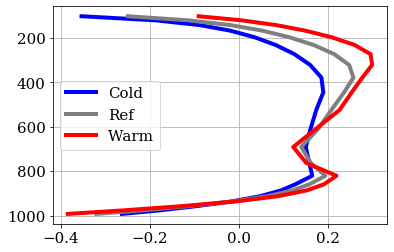

In [233]:
plt.plot(B_cons_m4K[:,ilatmin:ilatmax,:,ilevmin:].mean(dim=('time','lon','lat')),RHm4K.lev[ilevmin:],label='Cold',color='b')
plt.plot(B_cons_ref[:,ilatmin:ilatmax,:,ilevmin:].mean(dim=('time','lon','lat')),RHm4K.lev[ilevmin:],label='Ref',color='gray')
plt.plot(B_cons_p4K[:,ilatmin:ilatmax,:,ilevmin:].mean(dim=('time','lon','lat')),RHm4K.lev[ilevmin:],label='Warm',color='r')
plt.gca().invert_yaxis()
plt.grid()
plt.legend()

In [235]:
B_env_m4K.shape

(432, 30, 64, 128)

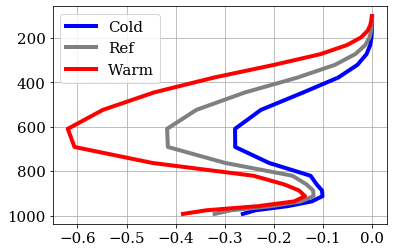

In [236]:
plt.plot(B_env_m4K[:,ilevmin:,ilatmin:ilatmax,:].mean(dim=('time','lon','lat')),RHm4K.lev[ilevmin:],label='Cold',color='b')
plt.plot(B_env_ref[:,ilevmin:,ilatmin:ilatmax,:].mean(dim=('time','lon','lat')),RHm4K.lev[ilevmin:],label='Ref',color='gray')
plt.plot(B_env_p4K[:,ilevmin:,ilatmin:ilatmax,:].mean(dim=('time','lon','lat')),RHm4K.lev[ilevmin:],label='Warm',color='r')
plt.gca().invert_yaxis()
plt.grid()
plt.legend()

In [243]:
BCONSHIST = {}
BENVHIST = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
        
    BCONSHIST[data] = np.histogram(B_cons(d.lev,d.TAP,d.QAP).values.flatten(),bins=100)
    BENVHIST[data] = np.histogram(B_env(d.lev,d.TAP,d.QAP).values.flatten(),bins=100)

data= m4K
data= ref
data= p4K


In [ ]:
plt.figure(figsize=(15,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    plt.plot(edg2bin(BCONSHIST[data][1]),BCONSHIST[data][0],color=COL[idata])
plt.grid()
plt.title('Bcons')                                             0

Text(0.5, 1.0, 'Bcons')

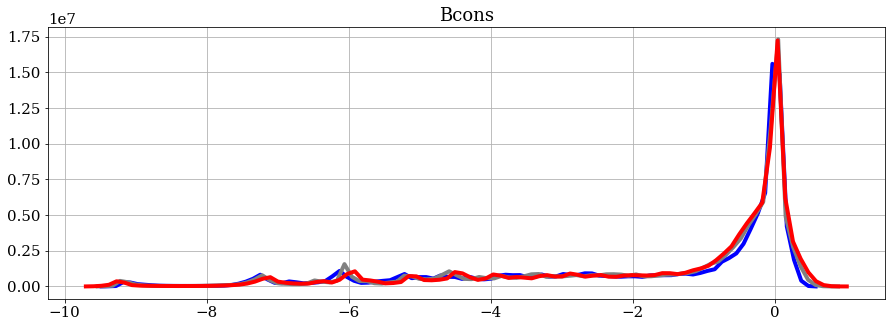

In [35]:
ilev = 29

plt.figure(figsize=(15,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    plt.plot(edg2bin(B_CONS_CUST[ilev][data][1]),B_CONS_CUST[ilev][data][0],color=COL[idata])
plt.grid()
plt.title('Bcons')



Text(0.5, 1.0, 'Bcons')

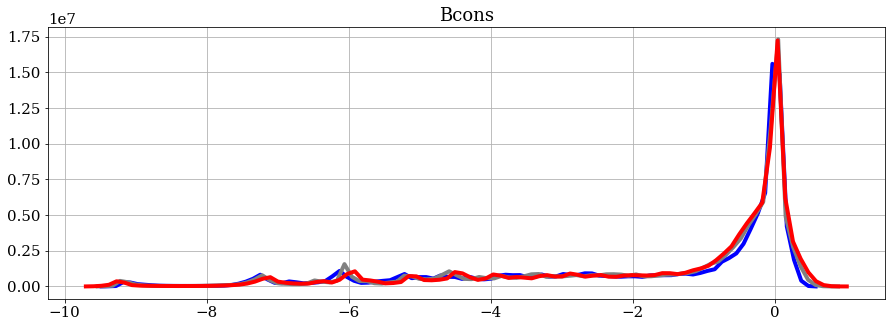

In [244]:
plt.figure(figsize=(15,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    plt.plot(edg2bin(BCONSHIST[data][1]),BCONSHIST[data][0],color=COL[idata])
plt.grid()
plt.title('Bcons')

Text(0.5, 1.0, 'Benv')

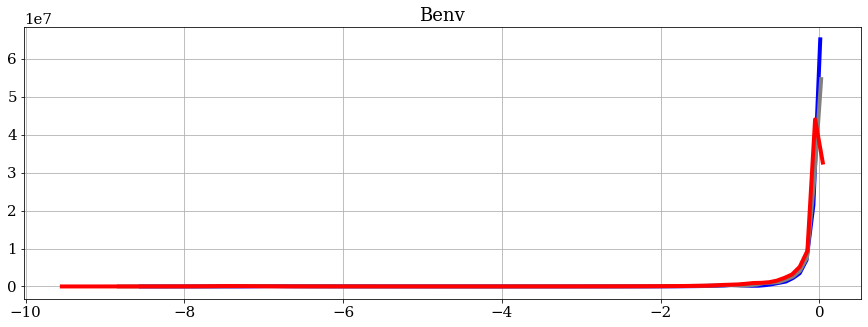

In [245]:
plt.figure(figsize=(15,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    plt.plot(edg2bin(BENVHIST[data][1]),BENVHIST[data][0],color=COL[idata])
plt.grid()
plt.title('Benv')

Text(0.5, 1.0, 'Bcons')

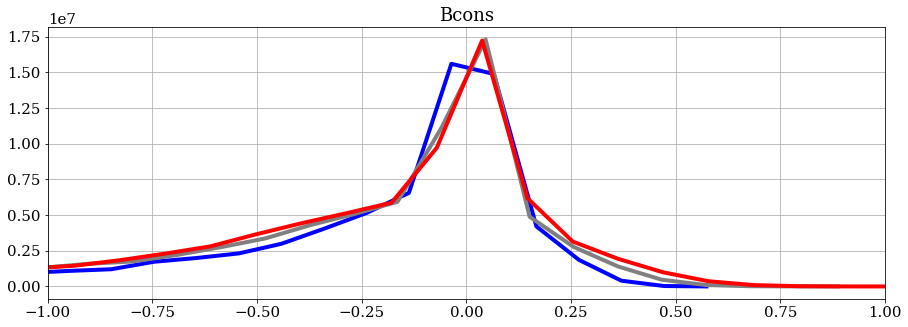

In [247]:
plt.figure(figsize=(15,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    plt.plot(edg2bin(BCONSHIST[data][1]),BCONSHIST[data][0],color=COL[idata])
plt.grid()
plt.xlim(-1,1)
plt.title('Bcons')

In [248]:
THIST = {}
TTNSHIST = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
        
    THIST[data] = np.histogram(d.TAP.values.flatten(),bins=100)
    TTNSHIST[data] = np.histogram((d.TAP-d.TAP[:,-1,:,:]).values.flatten(),bins=100)

data= m4K
data= ref
data= p4K


Text(0.5, 1.0, 'T')

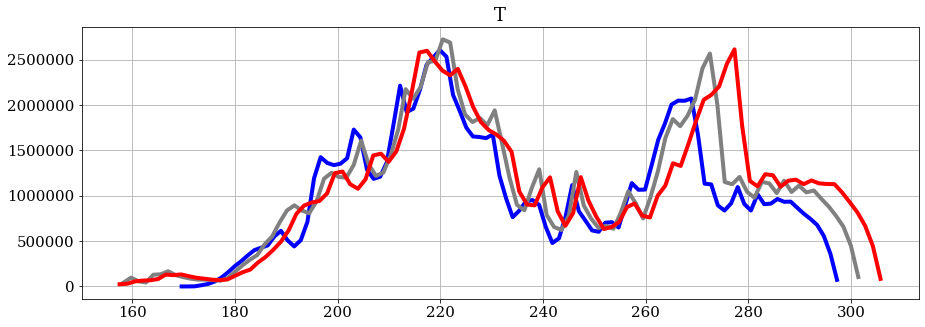

In [251]:
plt.figure(figsize=(15,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    plt.plot(edg2bin(THIST[data][1]),THIST[data][0],color=COL[idata])
plt.grid()
plt.title('T')

Text(0.5, 1.0, 'TTNS')

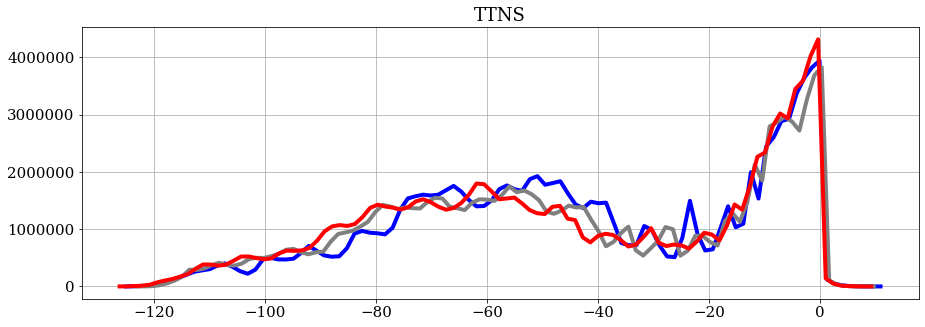

In [252]:
plt.figure(figsize=(15,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    plt.plot(edg2bin(TTNSHIST[data][1]),TTNSHIST[data][0],color=COL[idata])
plt.grid()
plt.title('TTNS')

## Surface fluxes

### Trying different scalings

In [165]:
LHFHIST = {}
LHFQHIST = {}
SHFHIST = {}
SEFHIST = {}
BOWHIST = {}
EFHIST = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
        
    LHFHIST[data] = np.histogram(d.LHFLX.values.flatten(),bins=100)
    LHFQHIST[data] = np.histogram((d.LHFLX/(L_V*(1e-3+d.QAP[:,-1,:,:]))).values.flatten(),bins=100)
    SHFHIST[data] = np.histogram(d.SHFLX.values.flatten(),bins=100)
    SEFHIST[data] = np.histogram((d.LHFLX+d.SHFLX).values.flatten(),bins=100)
    BOWHIST[data] = np.histogram(np.maximum(-3,np.minimum(3,d.SHFLX.values/d.LHFLX.values)),bins=100)
    EFHIST[data] = np.histogram(np.maximum(0,np.minimum(1,d.LHFLX.values/(d.LHFLX.values+d.SHFLX.values))),bins=100)

data= m4K
data= ref
data= p4K


In [20]:
COL = ['b','gray','r']

Text(0.5, 1.0, 'LHF')

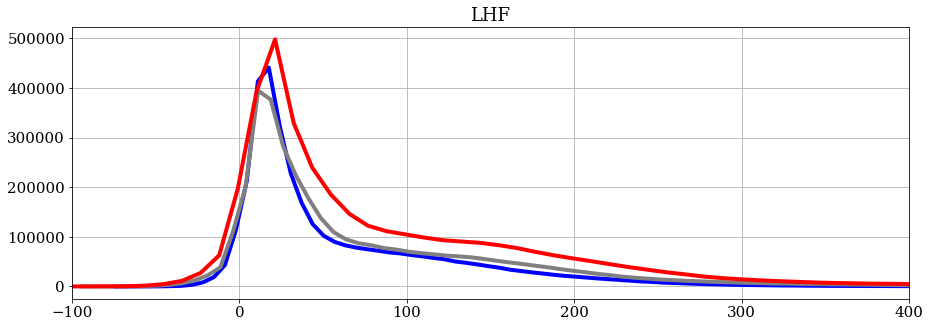

In [170]:
plt.figure(figsize=(15,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    plt.plot(edg2bin(LHFHIST[data][1]),LHFHIST[data][0],color=COL[idata])
plt.grid()
plt.xlim(-100,400)
plt.title('LHF')

Text(0.5, 1.0, 'LHF scaled by NS Q')

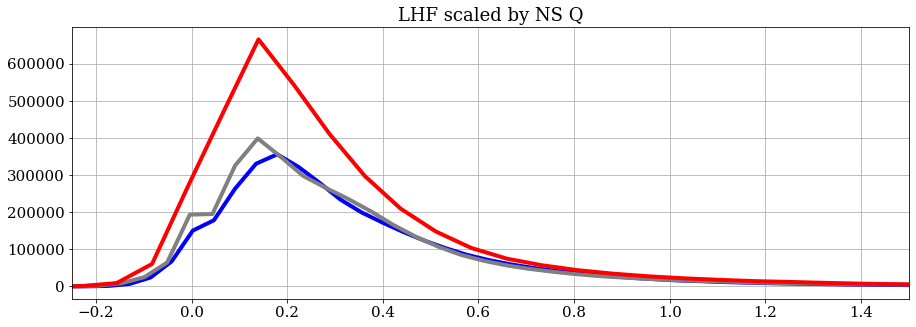

In [174]:
plt.figure(figsize=(15,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    plt.plot(100*edg2bin(LHFQHIST[data][1]),LHFQHIST[data][0],color=COL[idata])
plt.grid()
plt.xlim((-0.25,1.5))
plt.title('LHF scaled by NS Q')

(-50, 100)

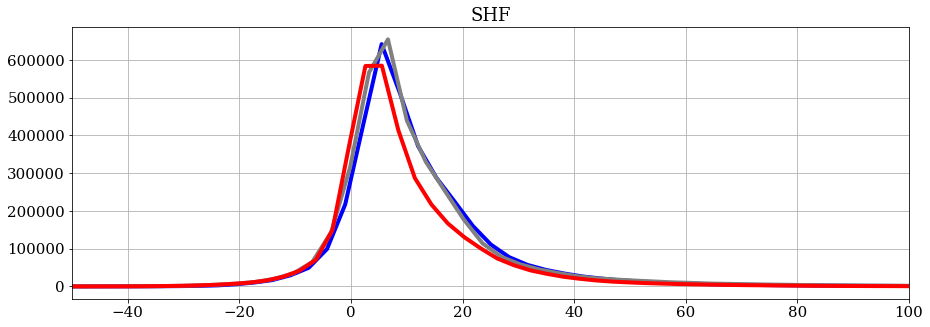

In [156]:
plt.figure(figsize=(15,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    plt.plot(edg2bin(SHFHIST[data][1]),SHFHIST[data][0],color=COL[idata])
plt.grid()
plt.title('SHF')
plt.xlim(-50,100)

(-100, 400)

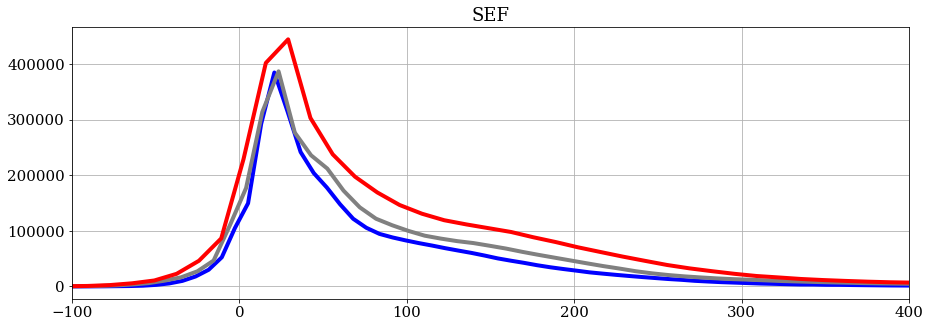

In [157]:
plt.figure(figsize=(15,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    plt.plot(edg2bin(SEFHIST[data][1]),SEFHIST[data][0],color=COL[idata])
plt.grid()
plt.title('SEF')
plt.xlim(-100,400)

(-2, 2)

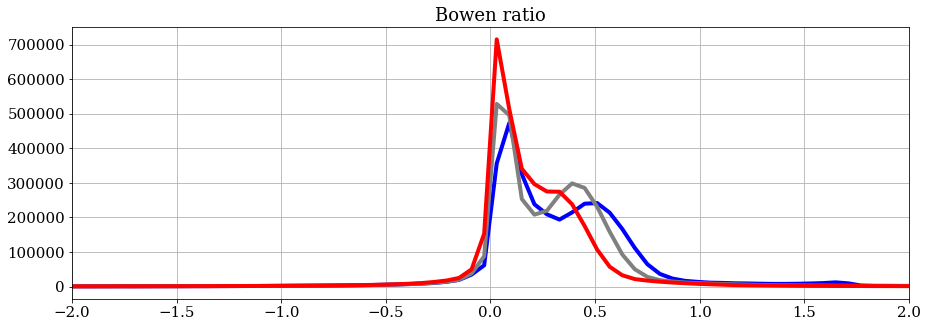

In [162]:
plt.figure(figsize=(15,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    plt.plot(edg2bin(BOWHIST[data][1]),BOWHIST[data][0],color=COL[idata])
plt.grid()
plt.title('Bowen ratio')
plt.xlim(-2,2)

(0, 1)

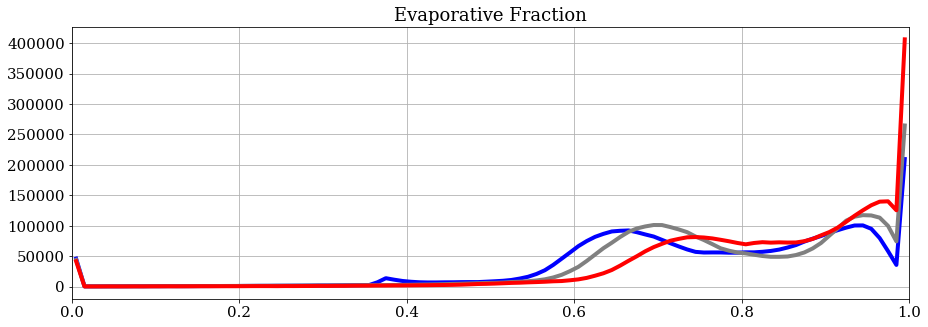

In [164]:
plt.figure(figsize=(15,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    plt.plot(edg2bin(EFHIST[data][1]),EFHIST[data][0],color=COL[idata])
plt.grid()
plt.title('Evaporative Fraction')
plt.xlim(0,1)

### Aerodynamic flux scaling

In [15]:
d = datam4K

In [17]:
d.TS.shape

(432, 64, 128)

In [18]:
hyam.shape

(30,)

In [19]:
hyam

array([0.00364347, 0.00759482, 0.01435663, 0.02461222, 0.0382683 ,
       0.05459548, 0.07201245, 0.08782123, 0.10331713, 0.12154724,
       0.14299404, 0.16822508, 0.17823067, 0.17032433, 0.16102291,
       0.15008029, 0.13720686, 0.12206194, 0.10424471, 0.08497915,
       0.0665017 , 0.05019679, 0.03718866, 0.02843195, 0.02220898,
       0.01640738, 0.01107456, 0.00625495, 0.00198941, 0.        ])

In [20]:
qsatS = qsat(d.TS,d.P0,d.PS,hyam[-1],hybm[-1])

In [21]:
qsatS.shape

(432, 64, 128)

In [22]:
d.QAP.shape

(432, 30, 64, 128)

In [23]:
delQ_ns = qsatS - d.QAP[:,-1,:,:]

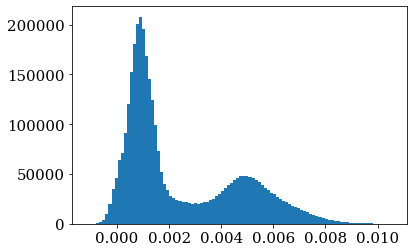

In [27]:
plt.hist(delQ_ns.values.flatten(),bins=100);

In [28]:
np.min(delQ_ns.values.flatten())

-0.0011459497601699871

In [29]:
np.min((d.TS-d.TAP[:,-1,:,:]).values.flatten())

-3.5731506

In [63]:
LHFHIST = {}
LHFDELQHIST = {}
SHFHIST = {}
SHFDELTHIST = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
        
    LHFHIST[data] = np.histogram(d.LHFLX.values.flatten(),bins=100)
    
    delQ_ns = qsat(d.TS,d.P0,d.PS,hyam[-1],hybm[-1]) - d.QAP[:,-1,:,:]
    LHFDELQHIST[data] = np.histogram((d.LHFLX/(L_V*np.maximum(1e-3,delQ_ns))).values.flatten(),bins=100)
    
    SHFHIST[data] = np.histogram(d.SHFLX.values.flatten(),bins=100)
    
    delT_ns = d.TS-d.TAP[:,-1,:,:]
    SHFDELTHIST[data] = np.histogram((d.SHFLX/(C_P*np.maximum(1,delT_ns))).values.flatten(),bins=100)

data= m4K
data= ref
data= p4K


In [64]:
COL = ['b','gray','r']

Text(0.5, 1.0, 'LHF')

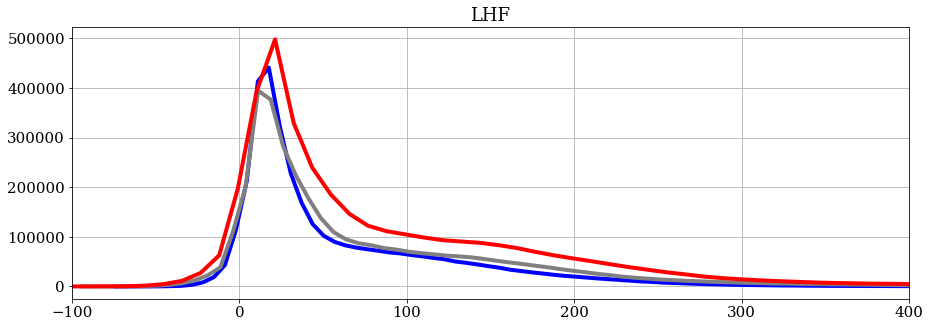

In [46]:
plt.figure(figsize=(15,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    plt.plot(edg2bin(LHFHIST[data][1]),LHFHIST[data][0],color=COL[idata])
plt.grid()
plt.xlim(-100,400)
plt.title('LHF')

Text(0.5, 1.0, 'LHF_DELQ')

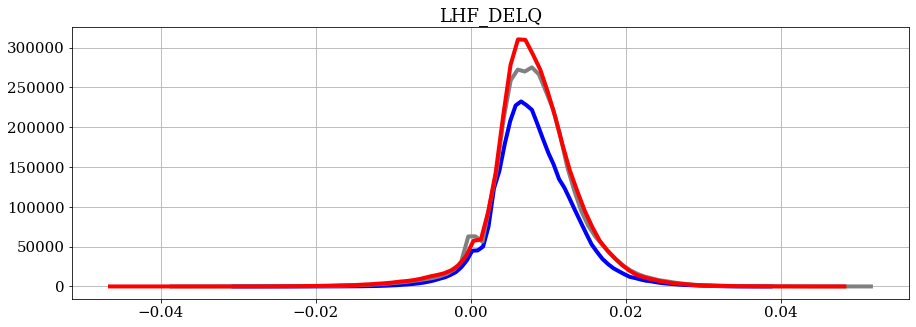

In [47]:
plt.figure(figsize=(15,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    plt.plot(edg2bin(LHFDELQHIST[data][1]),LHFDELQHIST[data][0],color=COL[idata])
plt.grid()
#plt.xlim(-100,400)
plt.title('LHF_DELQ')

Text(0.5, 1.0, 'SHF')

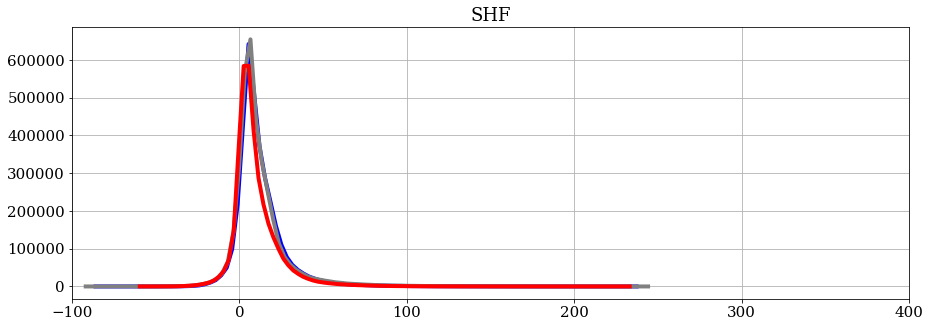

In [65]:
plt.figure(figsize=(15,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    plt.plot(edg2bin(SHFHIST[data][1]),SHFHIST[data][0],color=COL[idata])
plt.grid()
plt.xlim(-100,400)
plt.title('SHF')

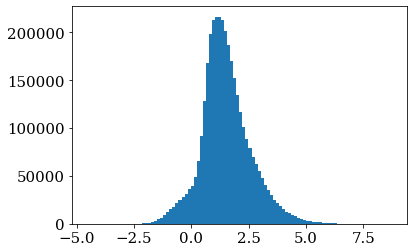

In [66]:
plt.hist(delT_ns.values.flatten(),bins=100);

Text(0.5, 1.0, 'SHF_DELT')

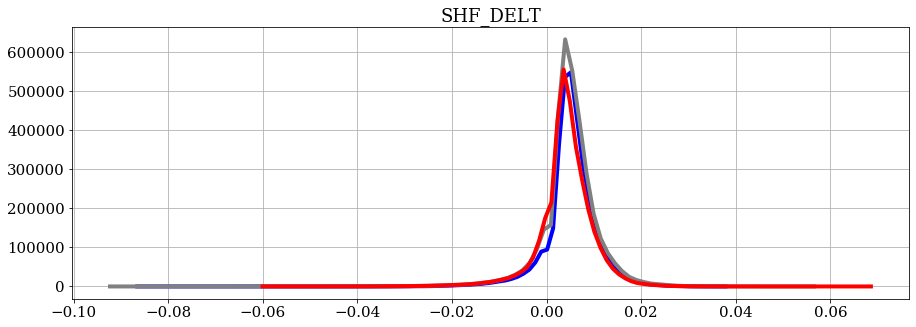

In [68]:
plt.figure(figsize=(15,5))
for idata,data in enumerate(['m4K','ref','p4K']):
    plt.plot(edg2bin(SHFDELTHIST[data][1]),SHFDELTHIST[data][0],color=COL[idata])
plt.grid()
#plt.xlim(-100,400)
plt.title('SHF_DELT')

### From LHF to RH flux

In [15]:
datam4K.TAP.shape

(432, 30, 64, 128)

In [17]:
RHm4K_NS = RHsurf(datam4K.TAP[:,-1,:,:],datam4K.QAP[:,-1,:,:],datam4K.P0,datam4K.PS)

In [18]:
RHm4K_NS.shape

(432, 64, 128)

In [14]:
DT

1800.0

In [41]:
dP0 = dP(datam4K.PS)[:,-1,:,:]

In [42]:
dP0.shape

(432, 64, 128)

In [43]:
dP0

array([[[1485.8125, 1486.    , 1486.1719, ..., 1485.2109, 1485.4219,
         1485.6172],
        [1489.9688, 1490.4062, 1490.8359, ..., 1488.6016, 1489.0625,
         1489.5156],
        [1493.5938, 1494.0234, 1494.4297, ..., 1492.1328, 1492.6562,
         1493.1484],
        ...,
        [1451.7891, 1452.1016, 1452.4375, ..., 1450.7812, 1451.1484,
         1451.4766],
        [1451.5781, 1452.0859, 1452.5859, ..., 1449.9922, 1450.5312,
         1451.0625],
        [1450.1875, 1450.4844, 1450.7734, ..., 1449.2891, 1449.5938,
         1449.8906]],

       [[1485.8438, 1486.0234, 1486.2031, ..., 1485.2422, 1485.4531,
         1485.6484],
        [1489.9688, 1490.3984, 1490.8281, ..., 1488.625 , 1489.0781,
         1489.5234],
        [1493.6719, 1494.0859, 1494.4844, ..., 1492.2266, 1492.75  ,
         1493.2266],
        ...,
        [1451.8281, 1452.1406, 1452.4688, ..., 1450.8281, 1451.1875,
         1451.5156],
        [1451.5938, 1452.1016, 1452.6016, ..., 1450.0234, 1450.5547,
   

In [44]:
RHpost = RHsurf(datam4K.TAP[:,-1,:,:]+DT*datam4K.SHFLX*G/(dP0*C_P),
               np.maximum(0,datam4K.QAP[:,-1,:,:]+DT*datam4K.LHFLX*G/(dP0*L_V)),
                datam4K.P0,datam4K.PS)

In [47]:
del_RH = RHpost-RHm4K_NS

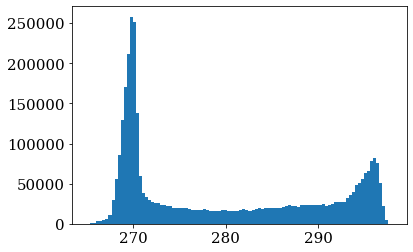

In [46]:
plt.hist((datam4K.TAP[:,-1,:,:]+0*datam4K.SHFLX*G/(dP0*C_P)).values.flatten(),bins=100);

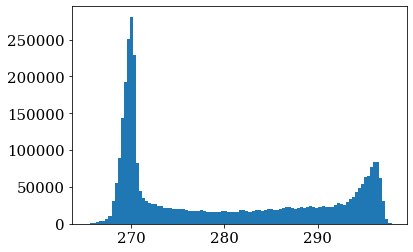

In [45]:
plt.hist((datam4K.TAP[:,-1,:,:]+DT*datam4K.SHFLX*G/(dP0*C_P)).values.flatten(),bins=100);

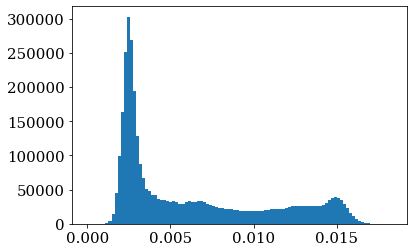

In [52]:
plt.hist(np.maximum(0,datam4K.QAP[:,-1,:,:]+0*datam4K.LHFLX*G/(dP0*L_V)).values.flatten(),bins=100);

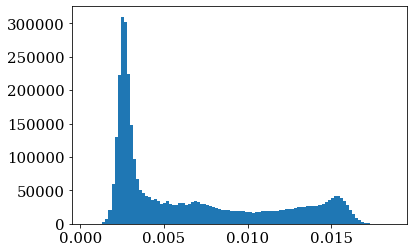

In [51]:
plt.hist(np.maximum(0,datam4K.QAP[:,-1,:,:]+DT*datam4K.LHFLX*G/(dP0*L_V)).values.flatten(),bins=100);

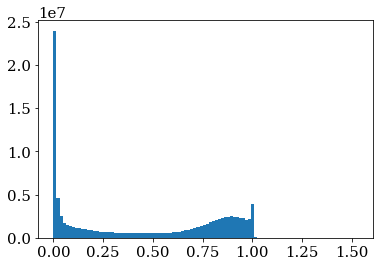

In [49]:
plt.hist(RHm4K.values.flatten(),bins=100);

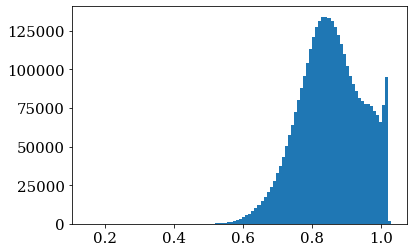

In [53]:
plt.hist(RHpost.values.flatten(),bins=100);

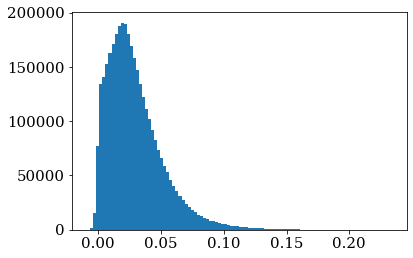

In [54]:
plt.hist(del_RH.values.flatten(),bins=100);

## LHF

In [30]:
def compute_LHF_nsQ(ds,eps):
    
    def esat(T):
        T0 = 273.16
        T00 = 253.16
        omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))

        return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))
    
    def eliq(T):
        a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
        c_liq = -80
        T0 = 273.16
        return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))
    
    def eice(T):
        a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
        c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
        T0 = 273.16
        return (T>c_ice[0])*eliq(T)+\
    (T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
    (T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))
    
    def qv(T,RH,P0,PS,hyam,hybm):
        R = 287
        Rv = 461
        p = (hyam*P0+hybm*PS).values # Total pressure (Pa)

        return R*esat(T)*RH/(Rv*p)

    def qsat(T,P0,PS,hyam,hybm):
        return qv(T,1,P0,PS,hyam,hybm)
    
    Qden = qsat(ds['TS'][1:,:,:],ds['P0'],ds['PS'][1:,:,:],ds['hyam'][:,-1],ds['hybm'][:,-1])
    return ds['LHFLX'][:-1]/(L_V*np.maximum(eps,Qden))

In [27]:
datam4K['hyam'].shape

(432, 30)

In [28]:
datam4K['TS'][1:,:,:].shape

(431, 64, 128)

In [32]:
test = compute_LHF_nsQ(datam4K,1e-3)

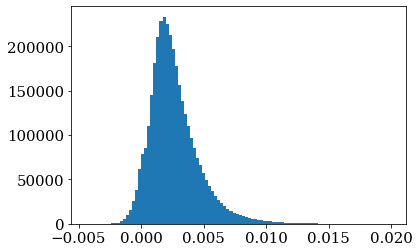

In [37]:
plt.hist(test.values.flatten(),bins=100);

In [40]:
def compute_bp(ds, var):
    """GCM state at beginning of time step before physics.
    ?BP = ?AP - physical tendency * dt

    Args:
        ds: entire xarray dataset
        var: BP variable name

    Returns:
        bp: xarray dataarray containing just BP variable, with the first time step cut.
    """
    base_var = var[:-2] + 'AP'
    return (ds[base_var] - ds[phy_dict[base_var]] * DT)[1:]  # Not the first time step

In [43]:
def compute_LHF_nsDELQ(ds,eps):
    
    def esat(T):
        T0 = 273.16
        T00 = 253.16
        omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))

        return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))
    
    def eliq(T):
        a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
        c_liq = -80
        T0 = 273.16
        return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))
    
    def eice(T):
        a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
        c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
        T0 = 273.16
        return (T>c_ice[0])*eliq(T)+\
    (T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
    (T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))
    
    def qv(T,RH,P0,PS,hyam,hybm):
        R = 287
        Rv = 461
        p = (hyam*P0+hybm*PS).values # Total pressure (Pa)

        return R*esat(T)*RH/(Rv*p)

    def qsat(T,P0,PS,hyam,hybm):
        return qv(T,1,P0,PS,hyam,hybm)
    
    QBP = compute_bp(ds,'QBP')
    Qden = qsat(ds['TS'][1:,:,:],ds['P0'],ds['PS'][1:,:,:],ds['hyam'][:,-1],ds['hybm'][:,-1])-QBP[:,-1,:,:]
    return ds['LHFLX'][:-1]/(L_V*np.maximum(eps,Qden))

In [44]:
test = compute_LHF_nsDELQ(datam4K,1e-3)

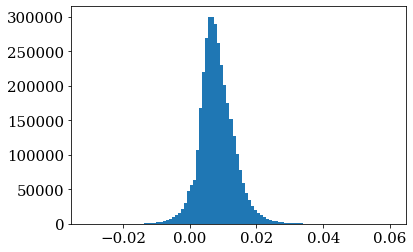

In [45]:
plt.hist(test.values.flatten(),bins=100);

# Output rescaling in T_tilde coordinate

## T_tilde function

In [13]:
datam4K

<xarray.Dataset>
Dimensions:       (crm_x: 8, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 432)
Coordinates:
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 ... 900.0 900.0 900.2
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 ... 38.27 24.61 14.36
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * crm_y         (crm_y) float64 0.0
  * lon           (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0
  * time          (time) float64 365.0 365.0 365.0 365.1 ... 373.9 374.0 374.0
Dimensions without coordinates: tbnd
Data variables:
    P0            (time) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    time_bnds     (time, tbnd) float64 dask.array<chunksize=(48, 2), meta=np.ndarray>
    date_written  (time) |S8 dask.array<chunksize=(48,), meta=np.ndarray>
    time_written  (time) |S8 dask.array<chunksize=(48,), meta=np.ndarray>
    ntrm          (time) int32 63 63 63 63 63 63 63 63 ... 63 63 63 63 63 63 63
    ntrn          (time) int32 63 63 63 63 63 63 63 63 ... 63 63 63 63 63 63 63
    ntrk          (time) int32 63 63 63 63 63 63 63 63 ... 63 63 63 63 63 63 63
    ndbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nsbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nbdate        (time) int32 101 101 101 101 101 101 ... 101 101 101 101 101
    nbsec         (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mdt           (time) int32 1800 1800 1800 1800 1800 ... 1800 1800 1800 1800
    nlon          (time, lat) int32 dask.array<chunksize=(48, 64), meta=np.ndarray>
    wnummax       (time, lat) int32 dask.array<chunksize=(48, 64), meta=np.ndarray>
    hyai          (time, ilev) float64 dask.array<chunksize=(48, 31), meta=np.ndarray>
    hybi          (time, ilev) float64 dask.array<chunksize=(48, 31), meta=np.ndarray>
    hyam          (time, lev) float64 dask.array<chunksize=(48, 30), meta=np.ndarray>
    hybm          (time, lev) float64 dask.array<chunksize=(48, 30), meta=np.ndarray>
    gw            (time, lat) float64 dask.array<chunksize=(48, 64), meta=np.ndarray>
    ndcur         (time) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    nscur         (time) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    date          (time) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    datesec       (time) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    DTV           (time, lev, lat, lon) float32 dask.array<chunksize=(48, 30, 64, 128), meta=np.ndarray>
    DTVKE         (time, lev, lat, lon) float32 dask.array<chunksize=(48, 30, 64, 128), meta=np.ndarray>
    FLNS          (time, lat, lon) float32 dask.array<chunksize=(48, 64, 128), meta=np.ndarray>
    FLNT          (time, lat, lon) float32 dask.array<chunksize=(48, 64, 128), meta=np.ndarray>
    FSNS          (time, lat, lon) float32 dask.array<chunksize=(48, 64, 128), meta=np.ndarray>
    FSNT          (time, lat, lon) float32 dask.array<chunksize=(48, 64, 128), meta=np.ndarray>
    LHFLX         (time, lat, lon) float32 dask.array<chunksize=(48, 64, 128), meta=np.ndarray>
    PHCLDICE      (time, lev, lat, lon) float32 dask.array<chunksize=(48, 30, 64, 128), meta=np.ndarray>
    PHCLDLIQ      (time, lev, lat, lon) float32 dask.array<chunksize=(48, 30, 64, 128), meta=np.ndarray>
    PHQ           (time, lev, lat, lon) float32 dask.array<chunksize=(48, 30, 64, 128), meta=np.ndarray>
    PRECC    

In [16]:
datam4K.TAP.shape

(432, 30, 64, 128)

In [17]:
def T_tilde(T,Tref=220):
    return (T-Tref)/(T[:,-1,:,:]-Tref)

In [19]:
T_tilde_m4K = T_tilde(datam4K.TAP)

In [20]:
T_tilde_m4K.shape

(432, 30, 64, 128)

## Interpolate PHQ,TPHYSTND from p to T_tilde

In [21]:
scale_dict = load_pickle('/export/home/tbeucler/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
in_vars = load_pickle('/export/home/tbeucler/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_in_vars.pkl')
out_vars = load_pickle('/export/home/tbeucler/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_out_vars.pkl')
dP = load_pickle('/export/home/tbeucler/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_dP.pkl')

In [22]:
prefac_PHQ = L_V*dP/G

In [23]:
prefac_TPH = C_P*dP/G

In [25]:
new_coord = np.linspace(-0.4,1,40)

In [46]:
PHQ_resc = datam4K.PHQ*np.moveaxis(np.tile(prefac_PHQ,(432,64,128,1)),-1,1)

In [48]:
TPHYSTND_resc = datam4K.TPHYSTND*np.moveaxis(np.tile(prefac_TPH,(432,64,128,1)),-1,1)

In [29]:
PHQ_resc.shape

(432, 30, 64, 128)

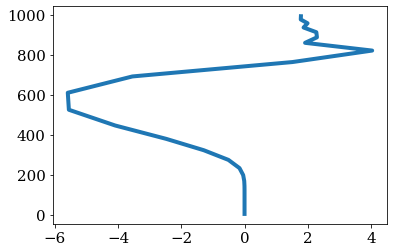

In [49]:
plt.plot(np.mean(PHQ_resc,axis=(0,2,3)),datam4K.lev)

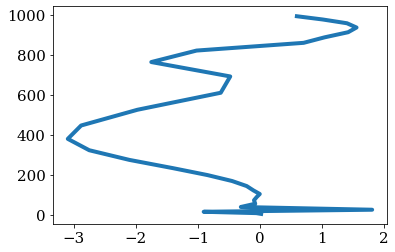

In [50]:
plt.plot(np.mean(TPHYSTND_resc,axis=(0,2,3)),datam4K.lev)

In [75]:
PHQ_flat = PHQ_resc.stack(z=('time','lon','lat'))

In [76]:
TPH_flat = TPHYSTND_resc.stack(z=('time','lon','lat'))

In [85]:
T_flat = datam4K.TAP.stack(z=('time','lon','lat'))

In [86]:
T_flat.shape

(30, 3538944)

In [94]:
def convert_to_monotonically_increasing(lev_tilde):
    lev_tilde_temp = lev_tilde[5:,:]
    concatenated = []
    for i in range(lev_tilde.shape[1]):
        diff = np.diff(lev_tilde_temp[:,i])
        conc = np.concatenate((lev_tilde_temp[:-1,i][diff<0] + 2*np.flip(np.cumsum(np.flip(diff[diff<0]))),lev_tilde_temp[:-1,i][diff>0], [1.]))
        concatenated.append(conc)
    return np.stack(concatenated)

In [95]:
T_tilde_flat = convert_to_monotonically_increasing(T_flat.values)

KeyboardInterrupt: 

In [69]:
def levTildeV2(X,lev_tilde,inp_sub,inp_div,batch_size=1024, interm_dim_size=40):
    '''can be used independently
        note: the input X should be raw transformed i.e without any other transformation(RH or QV)
        or if given in that way then please provide appropriate inp_sub, inp_div
    ''' ## not being used in the process method
    #X_denormalized = X*inp_div+inp_sub
    X_pressure = X[:,:30]
    X_temperature = X[:,30:60] #batchx30
    X_temperature_denormalized = X_denormalized[:,30:60]
    lev_tilde_after_single = np.linspace(-0.4,1,num=interm_dim_size)
    #-0.4 to 1
    X_temperature_after = []
    X_pressure_after = []
    ##. x , xp , fp x=ne_coordinatoe, xp=t-tilde, fp=t-tilde
    for i in range(batch_size):
        X_temperature_after.append(np.interp(lev_tilde_after_single, lev_tilde[i], X_temperature[i][5:]))
        X_pressure_after.append(np.interp(lev_tilde_after_single, lev_tilde[i], X_pressure[i][5:]))
    X_temperature_after = np.array(X_temperature_after)
    X_pressure_after = np.array(X_pressure_after)
    X_result = np.hstack((X_pressure_after,X_temperature_after))
    X_result = np.hstack((X_result,X[:,60:64]))
    return  X_result

In [81]:
X_stack = xr.concat((PHQ_flat,TPH_flat),dim='lev')

In [84]:
X_stack.transpose().shape

(3538944, 60)

In [ ]:
X_result = levTildeV2(X_stack.transpose(),lev_tilde,inp_sub,inp_div,batch_size=1024, interm_dim_size=40)

In [35]:
PHQ_interp = np.zeros((432,40,64,128))
for it in range(432):
    print('it=',it,'         ',end='\r')
    for ilat in range(64):
        for ilon in range(128):
            PHQ_interp[it,:,ilat,ilon] = \
            np.interp(x=new_coord,xp=T_tilde_m4K[it,:,ilat,ilon],fp=PHQ_resc[it,:,ilat,ilon])

KeyboardInterrupt: 

# Output rescaling - percentile approach

## Calculate PDFs

### PDF of moistening and heating

In [95]:
dataref.PHQ.shape

(432, 30, 64, 128)

In [96]:
scale_dict = load_pickle('/export/home/tbeucler/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
in_vars = load_pickle('/export/home/tbeucler/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_in_vars.pkl')
out_vars = load_pickle('/export/home/tbeucler/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_out_vars.pkl')
dP = load_pickle('/export/home/tbeucler/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_dP.pkl')

In [97]:
pdf = {}
edg = {}

for isim in range(3):
    print('isim=',isim,'         ')
    if isim==0: data = datam4K; 
    elif isim==1: data = dataref;
    elif isim==2: data = datap4K
    
    pdf[isim] = {}
    edg[isim] = {}
    
    for ilev in range(30):
        print('ilev=',ilev,'        ',end='\r')
        
        pdf[isim][ilev] = {}
        edg[isim][ilev] = {}
        
        for ifield,field in enumerate(['PHQ','TPHYSTND']):
            
            if ifield==0: prefac = L_V*dP/G
            elif ifield==1: prefac = C_P*dP/G
            
            pdf[isim][ilev][field],edg[isim][ilev][field] = \
            np.histogram(prefac[ilev]*data[field][:,ilev,:,:].values.flatten(),bins=100)

isim= 0          
isim= 1          
isim= 2          


In [100]:
# pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'

# hf = open(pathPKL+'2020_08_06_PERC_PDF.pkl','wb')

# F_data = {'pdf':pdf,
#            'edg':edg
#            }

# pickle.dump(F_data,hf)
# hf.close()

Check vertical coordinate

### PDF of sum and difference

In [60]:
pdf = {}
edg = {}

for isim in range(3):
    print('isim=',isim,'         ')
    if isim==0: data = datam4K; 
    elif isim==1: data = dataref;
    elif isim==2: data = datap4K
    
    pdf[isim] = {}
    edg[isim] = {}
    
    for ilev in range(30):
        print('ilev=',ilev,'        ',end='\r')
        
        pdf[isim][ilev] = {}
        edg[isim][ilev] = {}
        
        for ifield,field in enumerate(['sum','dif']):
            
            prefac_PHQ = L_V*dP/G; prefac_TPHYSTND = C_P*dP/G
            
            if ifield==0:
                pdf[isim][ilev][field],edg[isim][ilev][field] = \
                np.histogram((prefac_PHQ[ilev]*data['PHQ'][:,ilev,:,:]+\
                              prefac_TPHYSTND[ilev]*data['TPHYSTND'][:,ilev,:,:])\
                             .values.flatten(),bins=100)
            elif ifield==1:
                pdf[isim][ilev][field],edg[isim][ilev][field] = \
                np.histogram((-prefac_PHQ[ilev]*data['PHQ'][:,ilev,:,:]+\
                              prefac_TPHYSTND[ilev]*data['TPHYSTND'][:,ilev,:,:])\
                             .values.flatten(),bins=100)

isim= 0          
isim= 1          
isim= 2          


In [71]:
# pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'

# hf = open(pathPKL+'2020_08_06_SUM_DIF_PDF.pkl','wb')

# F_data = {'pdf':pdf,
#            'edg':edg
#            }

# pickle.dump(F_data,hf)
# hf.close()

## Calculate percentiles

### Raw percentiles

In [98]:
PERC = np.linspace(0,1000,1001).astype('int')/10

In [99]:
PERC

array([  0. ,   0.1,   0.2, ...,  99.8,  99.9, 100. ])

In [100]:
perc = {}

for isim in range(3):
    print('isim=',isim,'         ')
    if isim==0: data = datam4K; 
    elif isim==1: data = dataref;
    elif isim==2: data = datap4K
    
    perc[isim] = {}
    
    for ilev in range(30):
        print('ilev=',ilev,'        ',end='\r')
        
        perc[isim][ilev] = {}
        
        for ifield,field in enumerate(['PHQ','TPHYSTND']):
            
            if ifield==0: prefac = L_V*dP/G
            elif ifield==1: prefac = C_P*dP/G
            
            perc[isim][ilev][field] = {}
            perc[isim][ilev][field] = \
            np.percentile(a=prefac[ilev]*data[field][:,ilev,:,:].values.flatten(),q=PERC)

isim= 0          
isim= 1          
isim= 2          


In [101]:
# pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'

# hf = open(pathPKL+'2020_08_06_PERC.pkl','wb')

# F_data = {'PERC':PERC,
#            'perc':perc
#            }

# pickle.dump(F_data,hf)
# hf.close()

In [18]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

hf = open(pathPKL+'2020_08_06_PERC.pkl','rb')

In [20]:
PERC = pickle.load(hf)

EOFError: Ran out of input

In [21]:
PERC

{'PERC': array([  0. ,   0.1,   0.2, ...,  99.8,  99.9, 100. ]),
 'perc': {0: {0: {'PHQ': array([0., 0., 0., ..., 0., 0., 0.]),
    'TPHYSTND': array([-1.87312984, -1.76850394, -1.73934678, ...,  3.42755392,
            3.55146353,  4.14305687])},
   1: {'PHQ': array([0., 0., 0., ..., 0., 0., 0.]),
    'TPHYSTND': array([-2.78540158, -2.4597532 , -2.40804559, ...,  4.9010654 ,
            5.12929149,  6.28015089])},
   2: {'PHQ': array([-0.00927421, -0.00223361, -0.00162653, ...,  0.00062896,
            0.00087252,  0.00578489]),
    'TPHYSTND': array([-42.48101044, -15.79192528, -13.75949892, ...,   5.8858486 ,
             6.21528396,   8.88472939])},
   3: {'PHQ': array([-0.00324693, -0.00064887, -0.00046078, ...,  0.00126447,
            0.00163344,  0.0036058 ]),
    'TPHYSTND': array([-5.61534405, -3.70396085, -3.55667507, ..., 15.66371094,
           17.71205035, 46.29081726])},
   4: {'PHQ': array([-0.00254638, -0.00051232, -0.0004211 , ...,  0.00027646,
            0.00032776

In [22]:
PERC.keys()

dict_keys(['PERC', 'perc'])

In [27]:
PERC['PERC'].shape

(1001,)

In [28]:
PERC['perc'].keys()

dict_keys([0, 1, 2])

In [30]:
PERC['perc'][0].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [32]:
PERC['perc'][0][0].keys()

dict_keys(['PHQ', 'TPHYSTND'])

In [33]:
PERC['perc'][0][0]['PHQ'].shape

(1001,)

### Save percentiles as np array to load them in tf

In [180]:
perc

{0: {0: {'PHQ': array([0., 0., 0., ..., 0., 0., 0.]),
   'TPHYSTND': array([-1.87312984, -1.76850394, -1.73934678, ...,  3.42755392,
           3.55146353,  4.14305687])},
  1: {'PHQ': array([0., 0., 0., ..., 0., 0., 0.]),
   'TPHYSTND': array([-2.78540158, -2.4597532 , -2.40804559, ...,  4.9010654 ,
           5.12929149,  6.28015089])},
  2: {'PHQ': array([-0.00927421, -0.00223361, -0.00162653, ...,  0.00062896,
           0.00087252,  0.00578489]),
   'TPHYSTND': array([-42.48101044, -15.79192528, -13.75949892, ...,   5.8858486 ,
            6.21528396,   8.88472939])},
  3: {'PHQ': array([-0.00324693, -0.00064887, -0.00046078, ...,  0.00126447,
           0.00163344,  0.0036058 ]),
   'TPHYSTND': array([-5.61534405, -3.70396085, -3.55667507, ..., 15.66371094,
          17.71205035, 46.29081726])},
  4: {'PHQ': array([-0.00254638, -0.00051232, -0.0004211 , ...,  0.00027646,
           0.00032776,  0.00150518]),
   'TPHYSTND': array([-12.98911572,  -3.26531115,  -3.14522983, ...,   3

In [187]:
perc_m4K = np.zeros((60,1001))
perc_ref = np.zeros((60,1001))
perc_p4K = np.zeros((60,1001))

for ilev in range(60):
    if ilev<30:
        perc_m4K[ilev,:] = perc[0][ilev]['PHQ']
        perc_ref[ilev,:] = perc[1][ilev]['PHQ']
        perc_p4K[ilev,:] = perc[2][ilev]['PHQ']
    else:
        perc_m4K[ilev,:] = perc[0][ilev-30]['TPHYSTND']
        perc_ref[ilev,:] = perc[1][ilev-30]['TPHYSTND']
        perc_p4K[ilev,:] = perc[2][ilev-30]['TPHYSTND']

In [191]:
# pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'

# hf = open(pathPKL+'2020_08_06_PERC.pkl','wb')

# F_data = {'perc_m4K':perc_m4K,'perc_ref':perc_ref,'perc_p4K':perc_p4K,'PERC':PERC}

# pickle.dump(F_data,hf)
# hf.close()

In [83]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/NPZ_DATA/'

path_file = pathPKL+'2020_08_06_PERC.npz'

# np.savez(path_file,perc_m4K=perc_m4K,perc_ref=perc_ref,perc_p4K=perc_p4K,PERC=PERC)

In [90]:
test = np.load(path_file)

In [94]:
test.keys()

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f3d699ae908>)

### Percentile-based PDFs for safety check

In [99]:
pdf = {}
edg = {}

for isim in range(3):
    print('isim=',isim,'         ')
    if isim==0: data = datam4K; 
    elif isim==1: data = dataref;
    elif isim==2: data = datap4K
    
    pdf[isim] = {}
    edg[isim] = {}
    
    for ilev in range(30):
        print('ilev=',ilev,'        ',end='\r')
        
        pdf[isim][ilev] = {}
        edg[isim][ilev] = {}
        
        for ifield,field in enumerate(['PHQ','TPHYSTND']):
            
            if ifield==0: prefac = L_V*dP/G
            elif ifield==1: prefac = C_P*dP/G
            
            pdf[isim][ilev][field],edg[isim][ilev][field] = \
            np.histogram(prefac[ilev]*data[field][:,ilev,:,:].values.flatten(),bins=perc[isim][ilev][field])

isim= 0          
isim= 1          
isim= 2          


In [108]:
pdf[isim][ilev][field]

array([3539, 3539, 3539, 3539, 3539, 3539, 3539, 3539, 3539, 3539, 3539,
       3539, 3539, 3539, 3539, 3539, 3539, 3538, 3539, 3539, 3539, 3539,
       3539, 3539, 3539, 3539, 3539, 3539, 3539, 3539, 3539, 3539, 3539,
       3539, 3539, 3537, 3540, 3539, 3539, 3539, 3539, 3539, 3539, 3539,
       3539, 3539, 3539, 3539, 3539, 3539, 3539, 3539, 3538, 3539, 3539,
       3539, 3539, 3539, 3539, 3539, 3539, 3539, 3539, 3539, 3539, 3539,
       3539, 3539, 3539, 3539, 3538, 3539, 3539, 3539, 3538, 3540, 3538,
       3540, 3539, 3539, 3539, 3539, 3539, 3539, 3539, 3539, 3539, 3537,
       3540, 3539, 3538, 3540, 3539, 3539, 3539, 3539, 3539, 3539, 3539,
       3539, 3539, 3539, 3539, 3539, 3539, 3538, 3539, 3539, 3539, 3538,
       3540, 3539, 3539, 3539, 3539, 3539, 3539, 3539, 3539, 3538, 3540,
       3539, 3538, 3539, 3539, 3539, 3539, 3539, 3539, 3538, 3540, 3539,
       3539, 3539, 3539, 3539, 3539, 3538, 3540, 3539, 3538, 3539, 3539,
       3539, 3539, 3539, 3539, 3539, 3539, 3539, 35

## Plot PDFs

In [101]:
COL = ['b','gray','r']

No handles with labels found to put in legend.


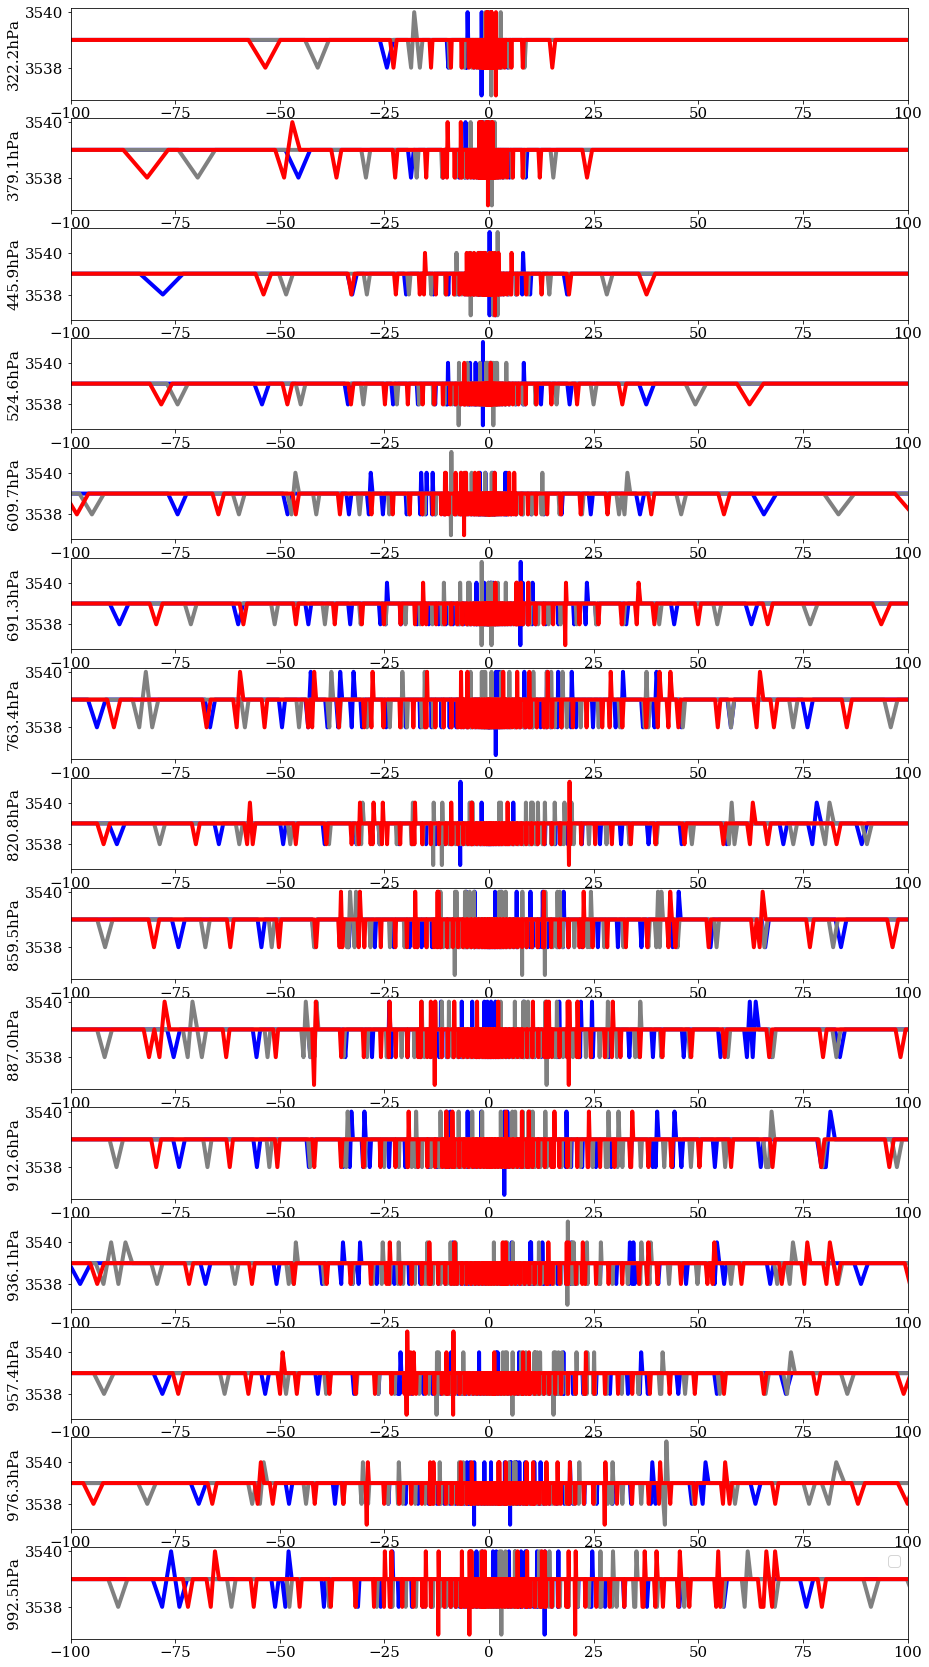

In [107]:
fig,ax = plt.subplots(15,1,figsize=(15,30))

for ilev in range(15):
    for isim in range(3):
        ax[ilev].plot(edg2bin(edg[isim][ilev+15]['PHQ']),pdf[isim][ilev+15]['PHQ'],color=COL[isim])
        ax[ilev].set_ylabel(str(data.lev[ilev+15].values)[:5]+'hPa')
        ax[ilev].set_xlim((-100,100))
plt.legend()

No handles with labels found to put in legend.


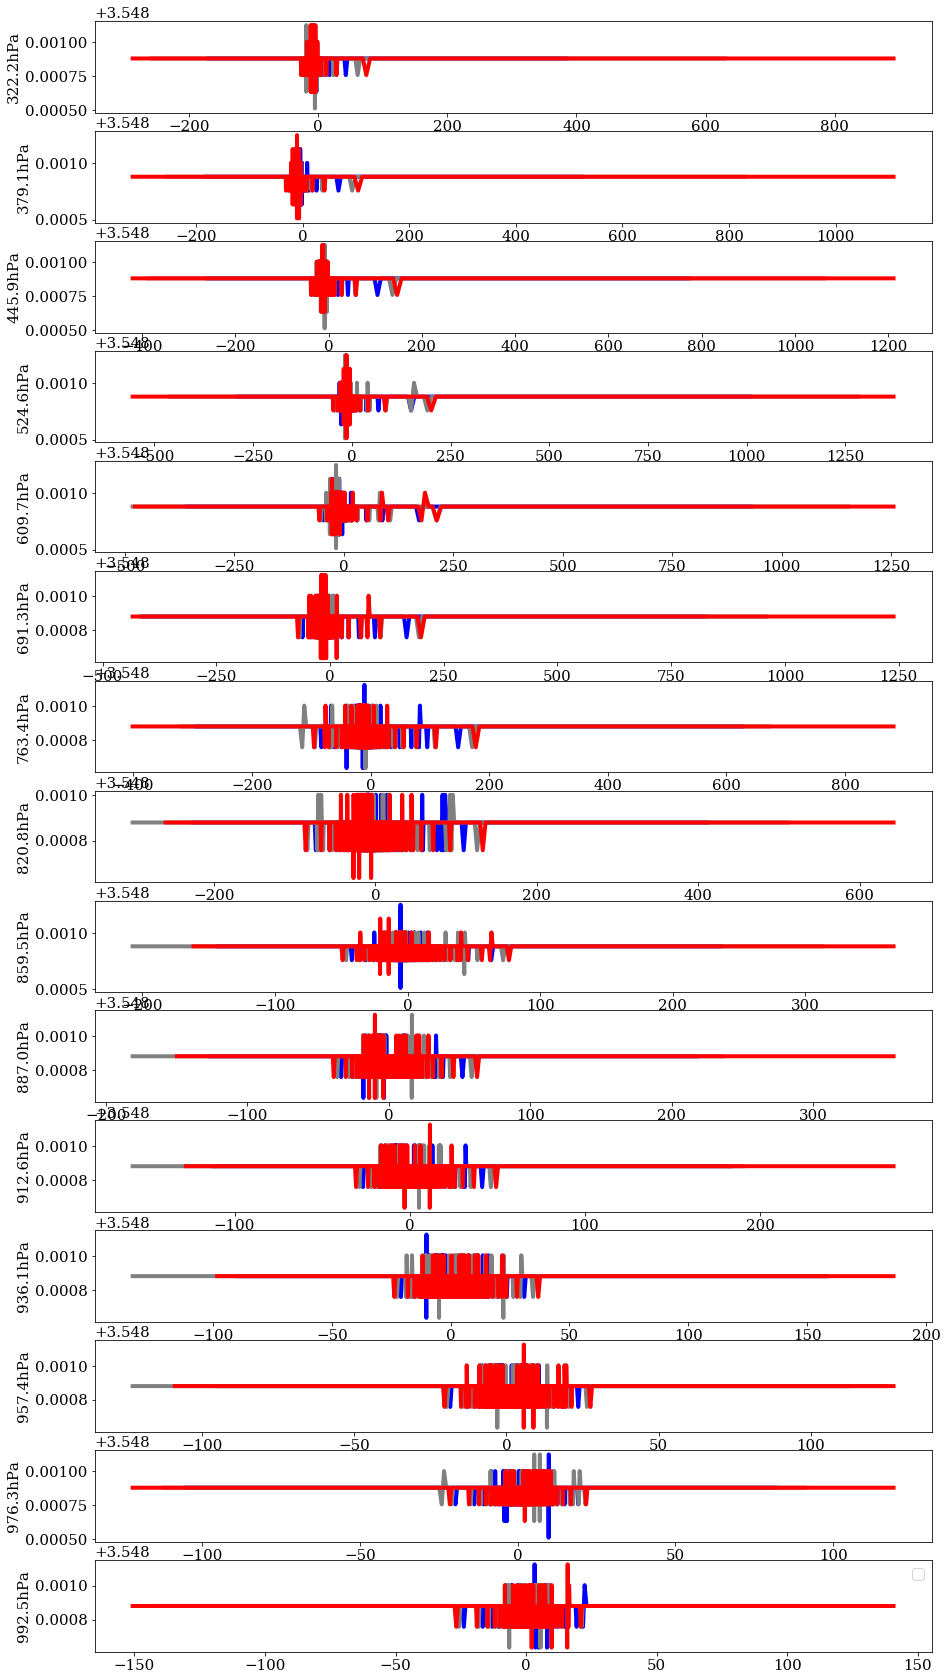

In [103]:
fig,ax = plt.subplots(15,1,figsize=(15,30))

for ilev in range(15):
    for isim in range(3):
        ax[ilev].plot(edg2bin(edg[isim][ilev+15]['TPHYSTND']),np.log10(pdf[isim][ilev+15]['TPHYSTND']),color=COL[isim])
        ax[ilev].set_ylabel(str(data.lev[ilev+15].values)[:5]+'hPa')
    
plt.legend()

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: Ru

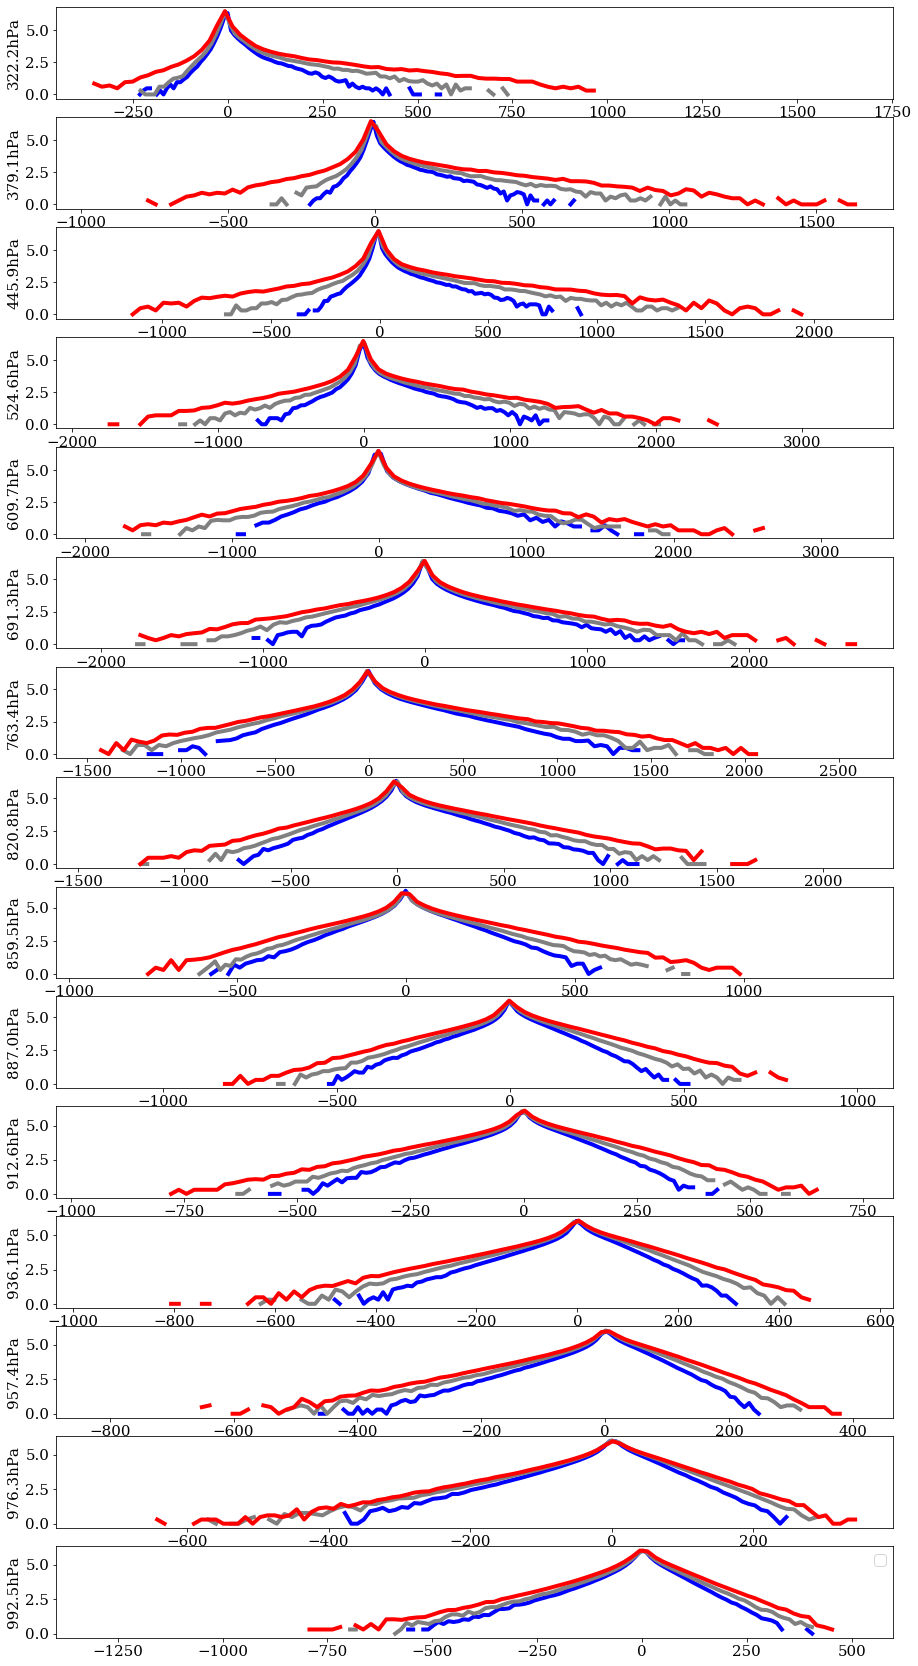

In [64]:
fig,ax = plt.subplots(15,1,figsize=(15,30))

for ilev in range(15):
    for isim in range(3):
        ax[ilev].plot(edg2bin(edg[isim][ilev+15]['sum']),np.log10(pdf[isim][ilev+15]['sum']),color=COL[isim])
        ax[ilev].set_ylabel(str(data.lev[ilev+15].values)[:5]+'hPa')
    
plt.legend()

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:5: Ru

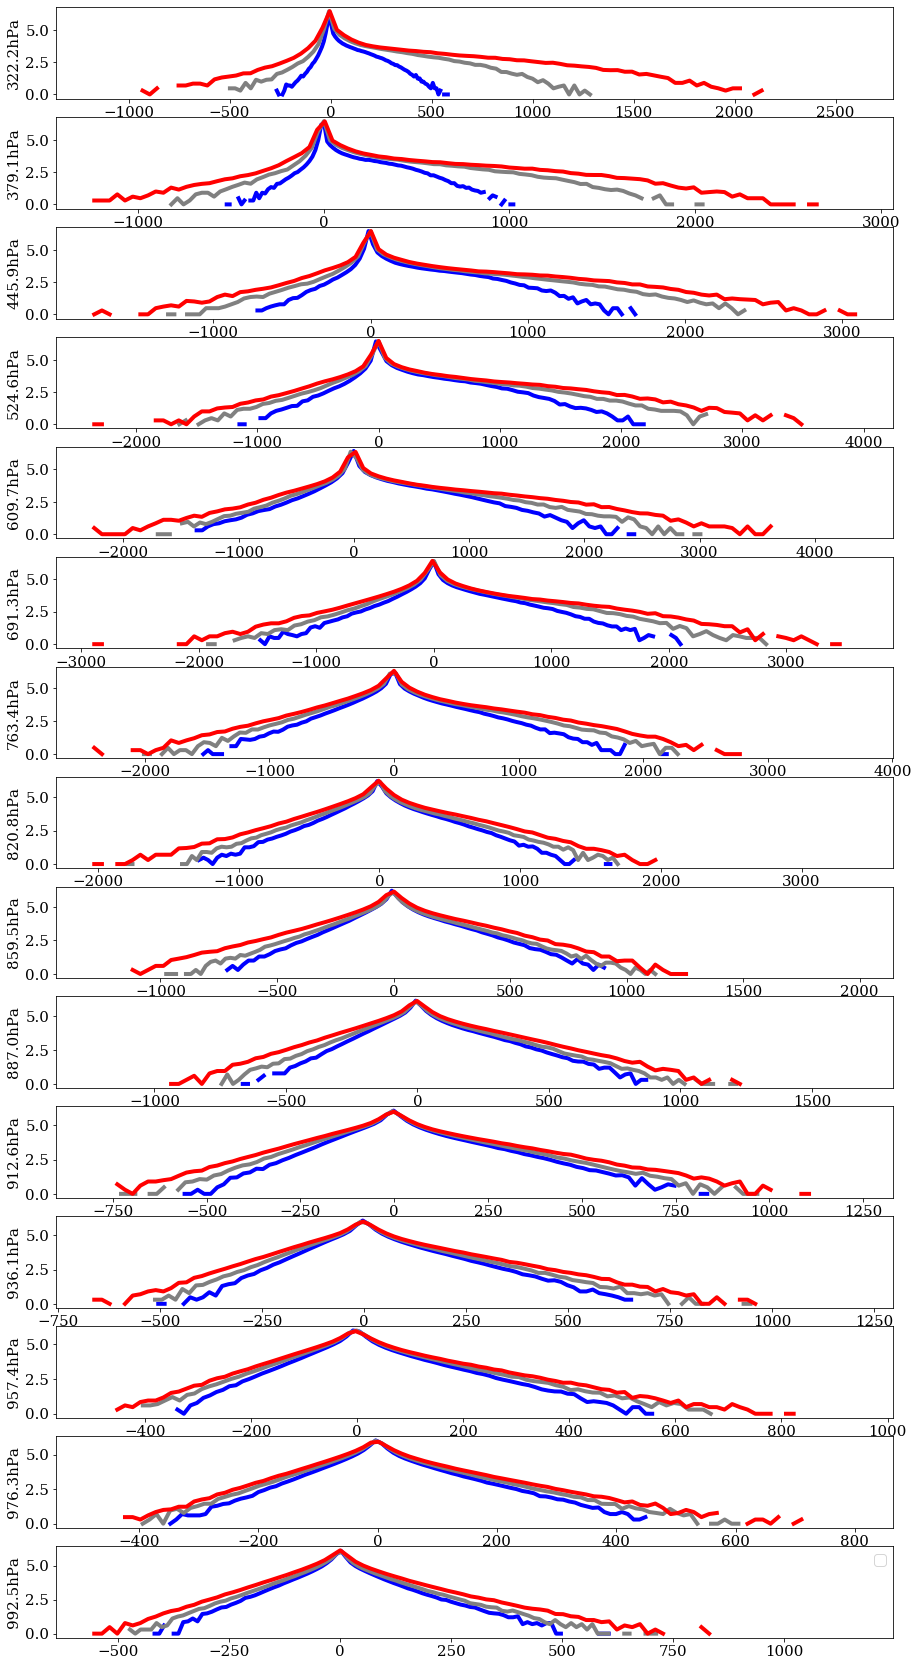

In [66]:
fig,ax = plt.subplots(15,1,figsize=(15,30))

for ilev in range(15):
    for isim in range(3):
        ax[ilev].plot(edg2bin(edg[isim][ilev+15]['dif']),np.log10(pdf[isim][ilev+15]['dif']),color=COL[isim])
        ax[ilev].set_ylabel(str(data.lev[ilev+15].values)[:5]+'hPa')
    
plt.legend()

## Load percentiles

In [35]:
perc = PERC['perc']

(-50, 50)

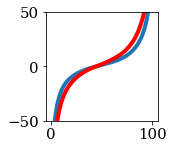

In [38]:
plt.figure(figsize=(2,2))
plt.plot(PERC['PERC'],perc[0][29]['PHQ'])
plt.plot(PERC['PERC'],perc[2][29]['PHQ'],color='r')
plt.ylim((-50,50))


(-50, 50)

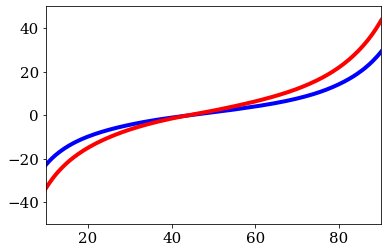

In [41]:
plt.plot(PERC['PERC'],perc[0][29]['PHQ'],color='b')
plt.plot(PERC['PERC'],perc[2][29]['PHQ'],color='r')
plt.xlim((10,90))
plt.ylim((-50,50))

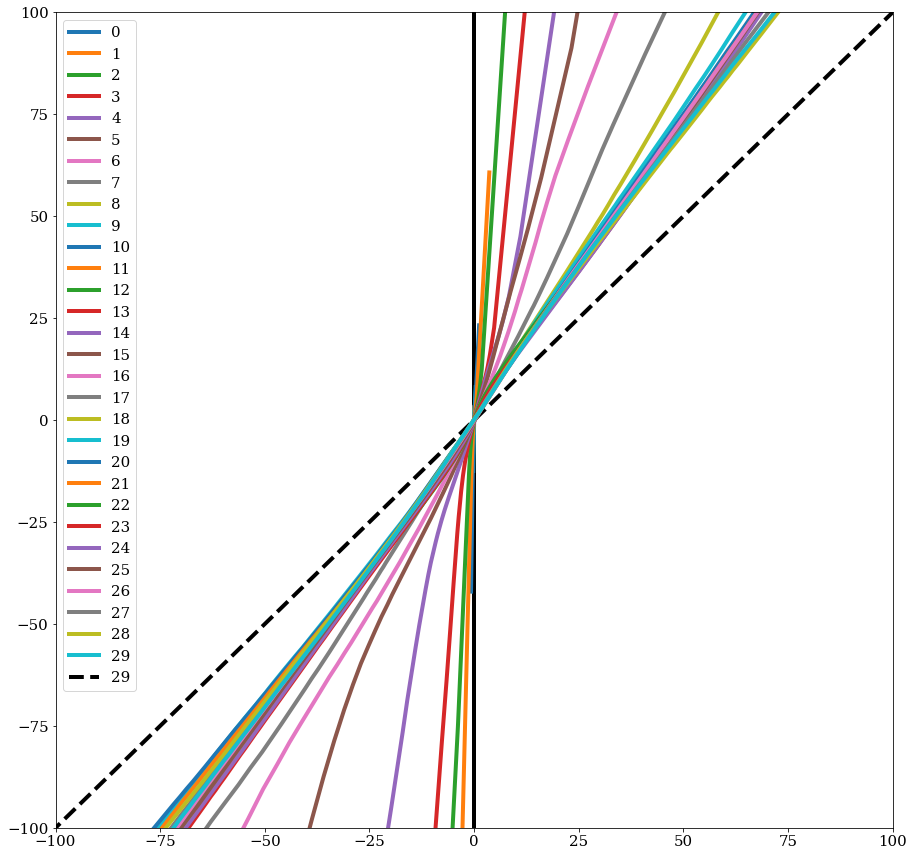

In [42]:
plt.figure(figsize=(15,15))
for ilev in range(30):
    plt.plot(perc[0][ilev]['PHQ'],perc[2][ilev]['PHQ'],label=str(ilev))
plt.plot(perc[0][ilev]['PHQ'],perc[0][ilev]['PHQ'],label=str(ilev),color='k',zorder=0,linestyle='--')
plt.axvline(x=0,color='k',zorder=0)
plt.xlim((-100,100))
plt.ylim((-100,100))
plt.legend()

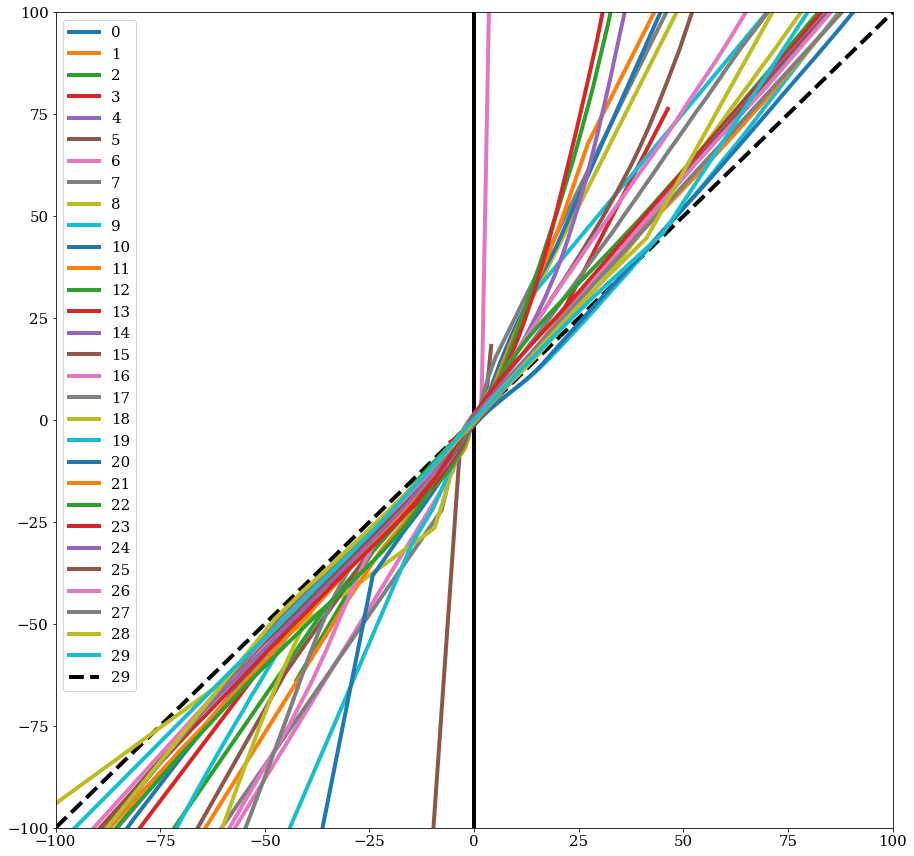

In [43]:
plt.figure(figsize=(15,15))
for ilev in range(30):
    plt.plot(perc[0][ilev]['TPHYSTND'],perc[2][ilev]['TPHYSTND'],label=str(ilev))
plt.plot(perc[0][ilev]['TPHYSTND'],perc[0][ilev]['TPHYSTND'],label=str(ilev),color='k',zorder=0,linestyle='--')
plt.axvline(x=0,color='k',zorder=0)
plt.xlim((-100,100))
plt.ylim((-100,100))
plt.legend()

### Simple linear regression from (-4K) to (+4K)

In [44]:
ilev = 22

In [45]:
PHQreg = LinearRegression(fit_intercept=True).fit(perc[0][ilev]['PHQ'].reshape(-1, 1),perc[2][ilev]['PHQ'].reshape(-1, 1))

In [46]:
PHQreg.coef_

array([[1.56746513]])

In [47]:
PHQreg.intercept_

array([-0.04955222])

In [48]:
PHQreg.score(perc[0][ilev]['PHQ'].reshape(-1, 1),perc[2][ilev]['PHQ'].reshape(-1, 1))

0.9924270850958917

In [49]:
Treg = LinearRegression(fit_intercept=True).fit(perc[0][ilev]['TPHYSTND'].reshape(-1, 1),perc[2][ilev]['TPHYSTND'].reshape(-1, 1))

In [50]:
Treg.coef_

array([[1.32828967]])

In [51]:
Treg.intercept_

array([-0.44380108])

In [59]:
Treg.score(perc[0][ilev]['PHQ'].reshape(-1, 1),perc[2][ilev]['PHQ'].reshape(-1, 1))

0.9692168586355461

### Make histogram from percentiles

In [72]:
percm4K = PERC['perc'][0][ilev]['PHQ']
percp4K = PERC['perc'][2][ilev]['PHQ']

In [62]:
percm4K.shape

(1001,)

In [63]:
percm4K

array([-1354.39831543,  -409.84859521,  -348.43252234, ...,
         362.92591583,   427.6879567 ,  1354.33044434])

In [92]:
PHQhistm4K,PHQedgm4K = np.histogram(percm4K,bins=100,density=True)

In [93]:
PHQhistp4K,PHQedgp4K = np.histogram(percp4K,bins=100,density=True)

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


(-400, 400)

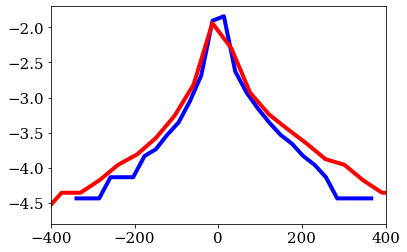

In [98]:
plt.plot(edg2bin(PHQedgm4K),np.log10(PHQhistm4K),color='b')
plt.plot(edg2bin(PHQedgp4K),np.log10(PHQhistp4K),color='r')
plt.xlim((-400,400))

### Make histogram directly

In [100]:
ilev = 22

In [102]:
dP0 = load_pickle('/export/home/tbeucler/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_dP.pkl')

In [105]:
pdf = {}
edg = {}

for isim in range(3):
    print('isim=',isim,'         ')
    if isim==0: data = datam4K; 
    elif isim==1: data = dataref;
    elif isim==2: data = datap4K
    
    pdf[isim] = {}
    edg[isim] = {}
        
    for ifield,field in enumerate(['PHQ','TPHYSTND']):
        
        if ifield==0: prefac = L_V*dP0/G
        elif ifield==1: prefac = C_P*dP0/G

        pdf[isim][field],edg[isim][field] = \
        np.histogram(prefac[ilev]*data[field][:,ilev,:,:].values.flatten(),bins=100,density=True)

isim= 0          
isim= 1          
isim= 2          


/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


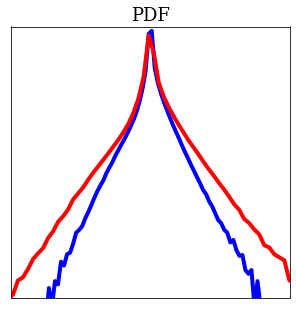

In [120]:
plt.figure(figsize=(5,5))

plt.plot(edg2bin(edg[0]['PHQ']),np.log10(pdf[0]['PHQ']),color='b')
plt.plot(edg2bin(edg[2]['PHQ']),np.log10(pdf[2]['PHQ']),color='r')
plt.xlim((-1250,1250))
plt.ylim((-7.5,-1.75))

plt.title('PDF')
#plt.legend(fontsize=1.5*fz)

frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)

In [122]:
PERC['perc'][2][ilev]['PHQ'].shape

(1001,)

In [123]:
PERC['PERC']

array([  0. ,   0.1,   0.2, ...,  99.8,  99.9, 100. ])

In [130]:
data = datap4K
prefac = L_V*dP0/G
PHQp4Ktopercp4K = np.interp(x=prefac[ilev]*data['PHQ'][:,ilev,:,:].values.flatten(),
                            xp=PERC['perc'][2][ilev]['PHQ'],fp=PERC['PERC'])

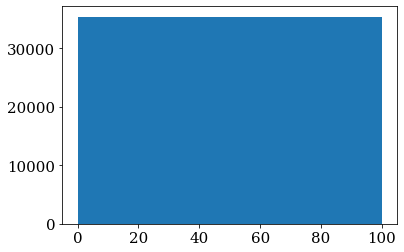

In [131]:
plt.hist(PHQp4Ktopercp4K,bins=100);

In [132]:
percp4KtoPHQm4K = np.interp(x=PHQp4Ktopercp4K,xp=PERC['PERC'],fp=PERC['perc'][0][ilev]['PHQ'])

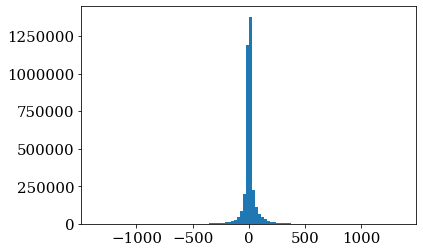

In [133]:
plt.hist(percp4KtoPHQm4K,bins=100);

In [135]:
pdf_rescaled,edg_rescaled = np.histogram(percp4KtoPHQm4K.flatten(),bins=100,density=True)

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/Griffin_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


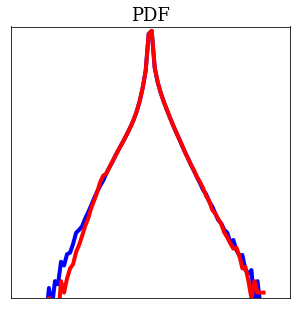

In [137]:
plt.figure(figsize=(5,5))

plt.plot(edg2bin(edg[0]['PHQ']),np.log10(pdf[0]['PHQ']),color='b')
plt.plot(edg2bin(edg_rescaled),np.log10(pdf_rescaled),color='r')
plt.xlim((-1250,1250))
plt.ylim((-7.5,-1.75))

plt.title('PDF')
#plt.legend(fontsize=1.5*fz)

frame1 = plt.gca()
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)

### Simple linear regression from (-4K) to (0K)

In [55]:
PHQreg = LinearRegression(fit_intercept=True).fit(perc[0][ilev]['PHQ'].reshape(-1, 1),perc[1][ilev]['PHQ'].reshape(-1, 1))

In [56]:
PHQreg.coef_

array([[1.17543609]])

In [57]:
PHQreg.score(perc[0][ilev]['PHQ'].reshape(-1, 1),perc[1][ilev]['PHQ'].reshape(-1, 1))

0.9941917621564392

In [58]:
PHQreg.score(perc[0][ilev]['PHQ'].reshape(-1, 1),perc[2][ilev]['PHQ'].reshape(-1, 1))

0.9303488460525098

2

### Use linear regression to rescale PHQ[ilev]

## Load both PDFs

In [81]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

hf = open(pathPKL+'2020_08_06_PHQ_TPHYSTND_PDF.pkl','rb')
pdfTQ = pickle.load(hf)

hf = open(pathPKL+'2020_08_06_SUM_DIF_PDF.pkl','rb')
pdfSD = pickle.load(hf)

FileNotFoundError: [Errno 2] No such file or directory: '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/2020_08_06_PHQ_TPHYSTND_PDF.pkl'

{'pdf': {0: {0: {'PHQ': array([      0,       0,       0,       0,       0,       0,       0,
                 0,       0,       0,       0,       0,       0,       0,
                 0,       0,       0,       0,       0,       0,       0,
                 0,       0,       0,       0,       0,       0,       0,
                 0,       0,       0,       0,       0,       0,       0,
                 0,       0,       0,       0,       0,       0,       0,
                 0,       0,       0,       0,       0,       0,       0,
                 0, 3538944,       0,       0,       0,       0,       0,
                 0,       0,       0,       0,       0,       0,       0,
                 0,       0,       0,       0,       0,       0,       0,
                 0,       0,       0,       0,       0,       0,       0,
                 0,       0,       0,       0,       0,       0,       0,
                 0,       0,       0,       0,       0,       0,       0,
                 0

# Separate full from convective time-tendency

tgb - 6/4/2020 - For equation discovery, we need to split the time-tendency of QAP and TAP in two: Convective (PHQ and TPHYSTND) vs large-scale

Using utilities from [https://github.com/tbeucler/CBRAIN-CAM/blob/master/cbrain/preprocessing/convert_dataset_20191113.py]

In [16]:
# Define dictionary with vertical diffusion terms
diff_dict = {
    'TAP' : 'DTV',
    'QAP' : 'VD01'
}

In [12]:
def compute_bp(ds, var):
    """GCM state at beginning of time step before physics.
    ?BP = ?AP - physical tendency * dt
    Args:
        ds: entire xarray dataset
        var: BP variable name
    Returns:
        bp: xarray dataarray containing just BP variable, with the first time step cut.
    """
    base_var = var[:-2] + 'AP'
    return (ds[base_var] - ds[phy_dict[base_var]] * DT)[1:]  # Not the first time step

In [13]:
def compute_adiabatic(ds, base_var):
    """Compute adiabatic tendencies.
    Args:
        ds: xarray dataset
        base_var: Base variable to be computed
    Returns:
        adiabatic: xarray dataarray
    """
    return (compute_bp(ds, base_var) - compute_c(ds, base_var)) / DT

In [14]:
def compute_c(ds, base_var):
    """CRM state at beginning of time step before physics.
    ?_C = ?AP[t-1] - diffusion[t-1] * dt
    Note:
    compute_c() is the only function that returns data from the previous
    time step.
    Args:
        ds: xarray dataset
        base_var: Base variable to be computed
    Returns:
        c: xarray dataarray
    """
    c = ds[base_var].isel(time=slice(0, -1, 1))   # Not the last time step
    if base_var in diff_dict.keys():
        c -= ds[diff_dict[base_var]].isel(time=slice(0, -1, 1)) * DT
    # Change time coordinate. Necessary for later computation of adiabatic
    c['time'] = ds.isel(time=slice(1, None, 1))['time']
    return c

In [18]:
dataref

<xarray.Dataset>
Dimensions:       (crm_x: 8, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 432)
Coordinates:
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 ... 38.27 24.61 14.36
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0
  * crm_y         (crm_y) float64 0.0
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lon           (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 ... 900.0 900.0 900.2
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * time          (time) float64 365.0 365.0 365.0 365.1 ... 373.9 374.0 374.0
Dimensions without coordinates: tbnd
Data variables:
    P0            (time) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05
    time_bnds     (time, tbnd) float64 dask.array<chunksize=(48, 2), meta=np.ndarray>
    date_written  (time) |S8 dask.array<chunksize=(48,), meta=np.ndarray>
    time_written  (time) |S8 dask.array<chunksize=(48,), meta=np.ndarray>
    ntrm          (time) int32 63 63 63 63 63 63 63 63 ... 63 63 63 63 63 63 63
    ntrn          (time) int32 63 63 63 63 63 63 63 63 ... 63 63 63 63 63 63 63
    ntrk          (time) int32 63 63 63 63 63 63 63 63 ... 63 63 63 63 63 63 63
    ndbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nsbase        (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nbdate        (time) int32 101 101 101 101 101 101 ... 101 101 101 101 101
    nbsec         (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    mdt           (time) int32 1800 1800 1800 1800 1800 ... 1800 1800 1800 1800
    nlon          (time, lat) int32 dask.array<chunksize=(48, 64), meta=np.ndarray>
    wnummax       (time, lat) int32 dask.array<chunksize=(48, 64), meta=np.ndarray>
    hyai          (time, ilev) float64 dask.array<chunksize=(48, 31), meta=np.ndarray>
    hybi          (time, ilev) float64 dask.array<chunksize=(48, 31), meta=np.ndarray>
    hyam          (time, lev) float64 dask.array<chunksize=(48, 30), meta=np.ndarray>
    hybm          (time, lev) float64 dask.array<chunksize=(48, 30), meta=np.ndarray>
    gw            (time, lat) float64 dask.array<chunksize=(48, 64), meta=np.ndarray>
    ndcur         (time) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    nscur         (time) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    date          (time) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    datesec       (time) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(48,), meta=np.ndarray>
    DTV           (time, lev, lat, lon) float32 dask.array<chunksize=(48, 30, 64, 128), meta=np.ndarray>
    DTVKE         (time, lev, lat, lon) float32 dask.array<chunksize=(48, 30, 64, 128), meta=np.ndarray>
    FLNS          (time, lat, lon) float32 dask.array<chunksize=(48, 64, 128), meta=np.ndarray>
    FLNT          (time, lat, lon) float32 dask.array<chunksize=(48, 64, 128), meta=np.ndarray>
    FLUT          (time, lat, lon) float32 dask.array<chunksize=(48, 64, 128), meta=np.ndarray>
    FSNS          (time, lat, lon) float32 dask.array<chunksize=(48, 64, 128), meta=np.ndarray>
    FSNT          (time, lat, lon) float32 dask.array<chunksize=(48, 64, 128), meta=np.ndarray>
    LHFLX         (time, lat, lon) float32 dask.array<chunksize=(48, 64, 128), meta=np.ndarray>
    PHCLDICE      (time, lev, lat, lon) float32 dask.array<chunksize=(48, 30, 64, 128), meta=np.ndarray>
    PHCLDLIQ      (time, lev, lat, lon) float32 dask.array<chunksize=(48, 30, 64, 128), meta=np.ndarray>
    PHQ           (tim

Temperature

In [80]:
TBP = compute_bp(dataref,'TAP').values

In [81]:
dT_dt_adiab = compute_adiabatic(dataref, 'TAP').values

In [82]:
dT_dt_diff = dataref[diff_dict['TAP']].values[1:,:,:,:] # Cut t=0

In [83]:
TCRM = compute_c(dataref,'TAP').values

In [91]:
TPHYSTND = dataref.TPHYSTND.values[1:,:,:,:] # Cut t=0
TAP = dataref.TAP.values[1:,:,:,:] # Cut t=0

One timestep looks like:  
`TCRM -- +DT $\times$ dT_dt_adiab -- TBP -- +DT $\times$ TPHYSTND -- TAP -- +DT $\times$ dT_dt_diff -- TCRM `

In [92]:
ilat = 25
ilon = 102
it = 25

Diffusion tendency (should be the easiest to "discover")

No handles with labels found to put in legend.


Text(0, 0.5, 'Pressure [hPa]')

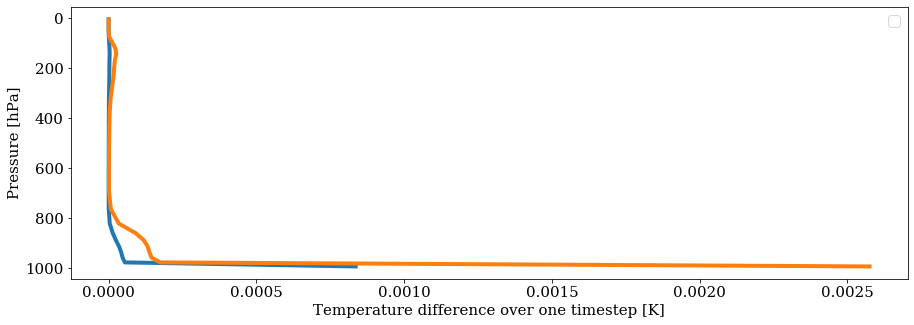

In [113]:
plt.figure(figsize=(15,5))
RESID = (TAP[0:-1,:,:,:]-TCRM[1:,:,:,:])-(DT*dT_dt_diff[1:,:,:,:]) # The terms in parenthesis are equal
plt.plot(np.mean(np.abs(RESID),axis=(0,2,3)),dataref.lev)
plt.plot(np.std(np.abs(RESID),axis=(0,2,3)),dataref.lev)
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('Temperature difference over one timestep [K]')
plt.ylabel('Pressure [hPa]')

Convection tendency (Ideally, the equations we would like to discover)

No handles with labels found to put in legend.


Text(0, 0.5, 'Pressure [hPa]')

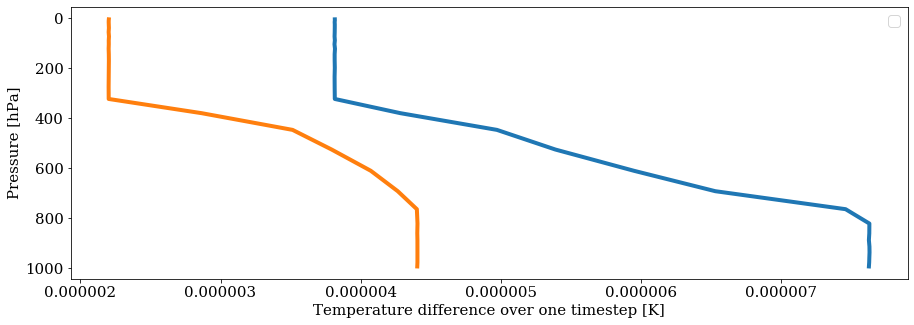

In [115]:
plt.figure(figsize=(15,5))
RESID = (TAP-TBP)-(DT*TPHYSTND) # The terms in parenthesis are equal
plt.plot(np.mean(np.abs(RESID),axis=(0,2,3)),dataref.lev)
plt.plot(np.std(np.abs(RESID),axis=(0,2,3)),dataref.lev)
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('Temperature difference over one timestep [K]')
plt.ylabel('Pressure [hPa]')

Adiabatic term (Does not need to be discovered)

No handles with labels found to put in legend.


Text(0, 0.5, 'Pressure [hPa]')

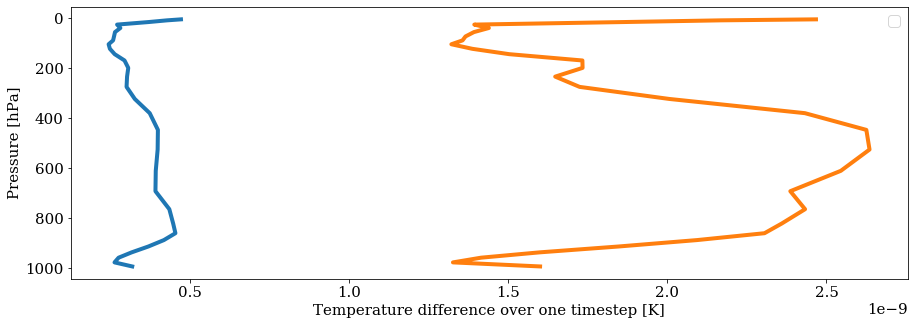

In [116]:
plt.figure(figsize=(15,5))
RESID = TCRM-TBP+DT*dT_dt_adiab
plt.plot(np.mean(np.abs(RESID),axis=(0,2,3)),dataref.lev)
plt.plot(np.std(np.abs(RESID),axis=(0,2,3)),dataref.lev)
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('Temperature difference over one timestep [K]')
plt.ylabel('Pressure [hPa]')

Specific humidity

In [117]:
QBP = compute_bp(dataref,'QAP').values
dQ_dt_adiab = compute_adiabatic(dataref, 'QAP').values
dQ_dt_diff = dataref[diff_dict['QAP']].values[1:,:,:,:] # Cut t=0
QCRM = compute_c(dataref,'QAP').values

In [118]:
PHQ = dataref.PHQ.values[1:,:,:,:] # Cut t=0
QAP = dataref.QAP.values[1:,:,:,:] # Cut t=0

No handles with labels found to put in legend.


Text(0, 0.5, 'Pressure [hPa]')

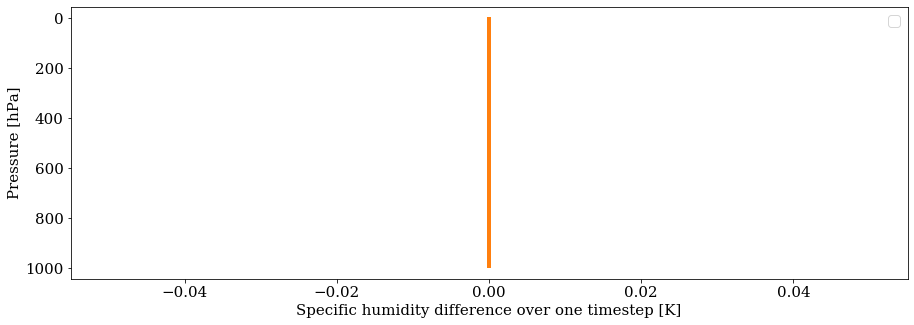

In [119]:
plt.figure(figsize=(15,5))
RESID = (QAP[0:-1,:,:,:]-QCRM[1:,:,:,:])-(DT*dQ_dt_diff[1:,:,:,:]) # The terms in parenthesis are equal
plt.plot(np.mean(np.abs(RESID),axis=(0,2,3)),dataref.lev)
plt.plot(np.std(np.abs(RESID),axis=(0,2,3)),dataref.lev)
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('Specific humidity difference over one timestep [K]')
plt.ylabel('Pressure [hPa]')

No handles with labels found to put in legend.


Text(0, 0.5, 'Pressure [hPa]')

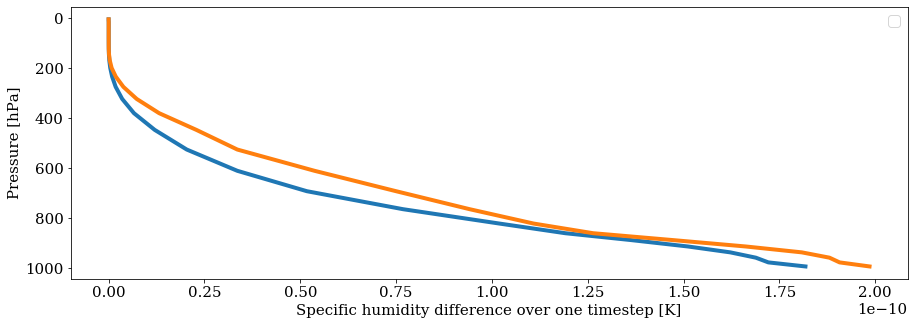

In [120]:
plt.figure(figsize=(15,5))
RESID = (QAP-QBP)-(DT*PHQ) # The terms in parenthesis are equal
plt.plot(np.mean(np.abs(RESID),axis=(0,2,3)),dataref.lev)
plt.plot(np.std(np.abs(RESID),axis=(0,2,3)),dataref.lev)
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('Specific humidity difference over one timestep [K]')
plt.ylabel('Pressure [hPa]')

No handles with labels found to put in legend.


Text(0, 0.5, 'Pressure [hPa]')

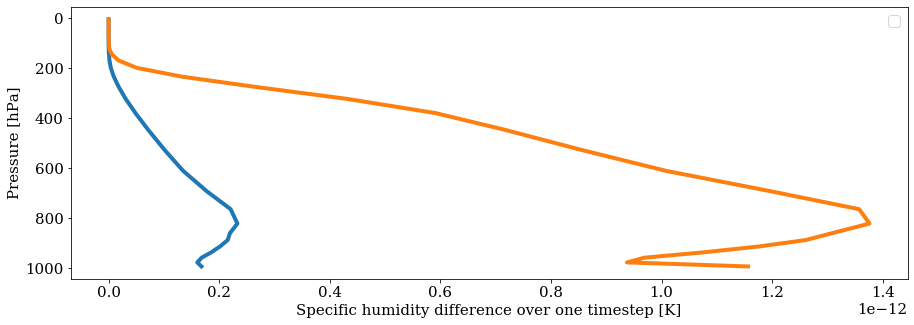

In [121]:
plt.figure(figsize=(15,5))
RESID = QCRM-QBP+DT*dQ_dt_adiab
plt.plot(np.mean(np.abs(RESID),axis=(0,2,3)),dataref.lev)
plt.plot(np.std(np.abs(RESID),axis=(0,2,3)),dataref.lev)
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel('Specific humidity difference over one timestep [K]')
plt.ylabel('Pressure [hPa]')

# Check Ankitesh's discrete and continuous tropopause pressure

## Functions developed by Ankitesh

In [17]:
def levTildeDiscrete(X,lev,inp_sub,inp_div,batch_size=1024,interm_dim_size=40):
    
    X_denormalized = X*inp_div+inp_sub
    X_pressure = X[:,:30]
    X_temperature = X[:,30:100] #batchx30
    X_temperature_denomalized = X_denormalized[:,30:100]
    
    lev_stacked = np.repeat(np.array(lev).reshape(1,-1),batch_size,axis=0)
    imin = np.argmin(X_temperature_denomalized[:,3:],axis=1)+3
#     imin = np.argwhere(np.diff(np.sign(X_temperature+0.10),axis=1))
#     print(imin)
#     print(imin[0,0].shape)
#     stop
    lev_roof = np.array(lev[imin])
    lev_tilde = (lev_stacked[:,-1].reshape(-1,1)-lev_stacked[:])/(lev_stacked[:,-1].reshape(-1,1)-lev_roof.reshape(-1,1))#batchx30

    
    lev_tilde_after_single = np.linspace(1.4,0,num=interm_dim_size)
    
    X_temperature_after = []
    X_pressure_after = []

    for i in range(batch_size):
        X_temperature_after.append(np.interp(lev_tilde_after_single, np.flip(lev_tilde[i]), np.flip(X_temperature[i])))
        X_pressure_after.append(np.interp(lev_tilde_after_single, np.flip(lev_tilde[i]), np.flip(X_pressure[i])))
    
    X_temperature_after = np.array(X_temperature_after)
    X_pressure_after = np.array(X_pressure_after)
    
    X_result = np.hstack((X_pressure_after,X_temperature_after))
    X_result = np.hstack((X_result,X[:,100:104]))
    
    return  X_result, lev_tilde, lev_roof

In [18]:
def levTildeConti(X,lev,inp_sub,inp_div,batch_size=1024,interm_dim_size=40,Tnot=5):
    
    X_denormalized = X*inp_div+inp_sub
    X_pressure = X[:,:30]
    X_temperature = X[:,30:60] #batchx30
    X_temperature_denormalized = X_denormalized[:,30:60]
    lev_stacked = np.repeat(np.array(lev).reshape(1,-1),batch_size,axis=0)
    imin = np.argmin(X_temperature_denormalized[:,3:],axis=1)+3 #take one below this and the next one
    lev1 = np.array(lev[imin-1]) #batch_size dim
    lev2 = np.array(lev[imin+1])
    T1 = np.take_along_axis( X_temperature_denormalized, (imin-1).reshape(-1,1),axis=1).flatten() ## batch_size
    T2 = np.take_along_axis( X_temperature_denormalized, (imin+1).reshape(-1,1),axis=1).flatten() ## batch_size    
    deltaT = T2-T1
    alpha = (1.0/2)*(2 - np.exp(-1*np.abs(deltaT/Tnot)))
    #alpha = np.maximum(0,np.minimum(1,alpha))
    lev_roof = alpha*lev1 + (1-alpha)*lev2
    
    lev_tilde = (lev_stacked[:,-1].reshape(-1,1)-lev_stacked[:])/(lev_stacked[:,-1].reshape(-1,1)-lev_roof.reshape(-1,1))#batchx30
    lev_tilde_after_single = np.linspace(1.4,0,num=interm_dim_size)
    
    X_temperature_after = []
    X_pressure_after = []

    for i in range(batch_size):
        X_temperature_after.append(np.interp(lev_tilde_after_single, np.flip(lev_tilde[i]), np.flip(X_temperature[i])))
        X_pressure_after.append(np.interp(lev_tilde_after_single, np.flip(lev_tilde[i]), np.flip(X_pressure[i])))
    
    X_temperature_after = np.array(X_temperature_after)
    X_pressure_after = np.array(X_pressure_after)
    
    X_result = np.hstack((X_pressure_after,X_temperature_after))
    X_result = np.hstack((X_result,X[:,60:64]))
    
    return  X_result, lev_tilde, lev_roof,alpha

## Transform data into right format

In [19]:
dataref.TAP.shape

(48, 30, 64, 128)

In [20]:
X = np.moveaxis(dataref.TAP.values,0,1)

In [21]:
X.shape

(30, 48, 64, 128)

In [22]:
X0 = np.reshape(X,(30,48*64*128))

In [23]:
X0.shape

(30, 393216)

In [24]:
X = np.transpose(
    np.concatenate((np.reshape(np.moveaxis(dataref.QAP.values,0,1),(30,48*64*128)),
                    np.reshape(np.moveaxis(dataref.TAP.values,0,1),(30,48*64*128))),axis=0)
)

In [25]:
X_result, lev_tilde, lev_roof = levTildeDiscrete(X,dataref.lev.values,0*X**0,1*X**0,batch_size=X.shape[0],interm_dim_size=40)

In [26]:
lev_roof.shape

(393216,)

In [27]:
lev_roof_0 = np.reshape(lev_roof,(48,64,128))

Text(0, 0.5, 'Mean Lev roof [hPa]')

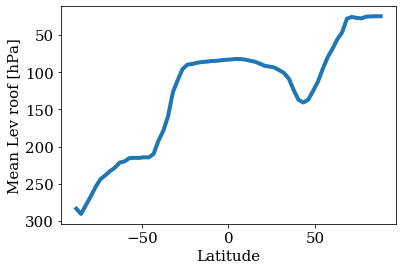

In [28]:
plt.plot(dataref.lat,np.mean(lev_roof_0,axis=(0,2)))
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('Mean Lev roof [hPa]')

In [29]:
X_result, lev_tilde, lev_roof = levTildeConti(X,dataref.lev.values,0*X**0,1*X**0,batch_size=X.shape[0],interm_dim_size=40,Tnot=5)

ValueError: too many values to unpack (expected 3)

In [ ]:
lev_roof_0 = np.reshape(lev_roof,(48,64,128))

In [ ]:
plt.plot(dataref.lat,np.mean(lev_roof_0,axis=(0,2)))
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('Mean Lev roof [hPa]')

In [287]:
def data2levroof(dataset,option,Tnot=5):
    
    S = dataset.QAP.shape
    X = np.transpose(
        np.concatenate((np.reshape(np.moveaxis(dataset.QAP.values,0,1),(30,S[0]*S[2]*S[3])),
                        np.reshape(np.moveaxis(dataset.TAP.values,0,1),(30,S[0]*S[2]*S[3]))),axis=0)
    )
    
    if option=='discrete':
        X_result, lev_tilde, lev_roof = \
        levTildeDiscrete(X,dataref.lev.values,0*X**0,1*X**0,batch_size=X.shape[0],interm_dim_size=40)
    elif option=='continuous':
        X_result, lev_tilde, lev_roof,alpha = \
        levTildeConti(X,dataref.lev.values,0*X**0,1*X**0,batch_size=X.shape[0],interm_dim_size=40,Tnot=Tnot)
        
    return np.reshape(lev_roof,(S[0],S[2],S[3])),np.reshape(alpha,(S[0],S[2],S[3]))

In [220]:
T = dataref.TAP.values

In [221]:
T.shape

(48, 30, 64, 128)

In [248]:
D = np.sign(np.diff(T,axis=1))
#imin = np.argwhere(D,axis=1)

In [249]:
D.shape

(48, 29, 64, 128)

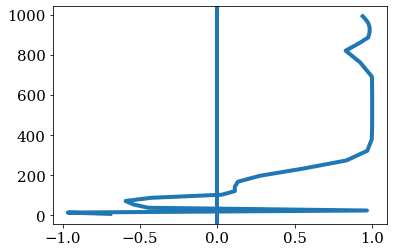

In [250]:
plt.plot(np.mean(D,axis=(0,2,3)),dataref.lev[1:])
plt.axvline(x=0)

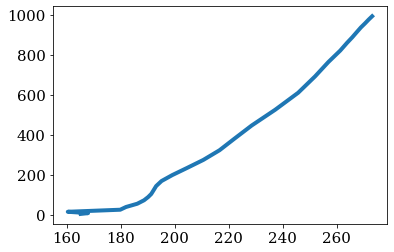

In [255]:
plt.plot(T[1,:,-2,5],dataref.lev)


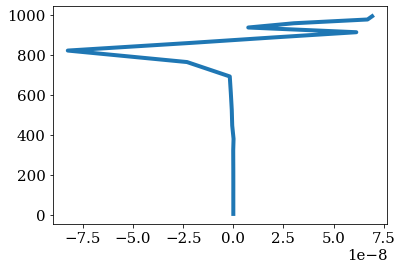

In [259]:
plt.plot(dataref.PHQ.values[1,:,-2,4],dataref.lev)

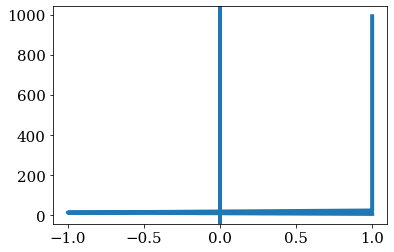

In [252]:
plt.plot(D[1,:,-2,5],dataref.lev[1:])
plt.axvline(x=0)

In [241]:
48*29*64*128

11403264

In [239]:
imin.shape

(11403264, 4)

In [240]:
imin[:,0]

array([ 0,  0,  0, ..., 47, 47, 47])

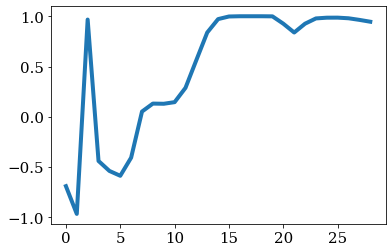

In [234]:
plt.plot(np.mean(imin,axis=(0,2,3)))

In [232]:
np.sum(imin==-1)/np.sum(imin**0)

0.2586944404689745

In [263]:
lev_roof_0 = data2levroof(dataref,'discrete')
lev_roof_m4 = data2levroof(datam4K,'discrete')
lev_roof_p4 = data2levroof(datap4K,'discrete')

Text(0, 0.5, 'Mean Lev roof [hPa]')

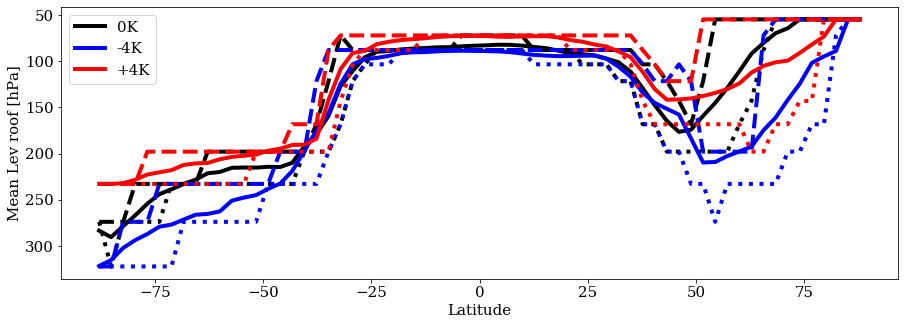

In [264]:
plt.figure(figsize=(15,5))
plt.plot(dataref.lat,np.mean(lev_roof_0,axis=(0,2)),color='k',label='0K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=25),color='k',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=75),color='k',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_m4,axis=(0,2)),color='b',label='-4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=25),color='b',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=75),color='b',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_p4,axis=(0,2)),color='r',label='+4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=25),color='r',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=75),color='r',linestyle=':')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Mean Lev roof [hPa]')

In [288]:
lev_roof_0,alpha_0 = data2levroof(dataref,'continuous',Tnot=5)
lev_roof_m4,alpha_m4 = data2levroof(datam4K,'continuous',Tnot=5)
lev_roof_p4,alpha_p4 = data2levroof(datap4K,'continuous',Tnot=5)

(array([57825., 58227., 48759., 40586., 36273., 27552., 18668., 12176.,
        11639., 81511.]),
 array([0.50000155, 0.5498187 , 0.5996359 , 0.64945304, 0.6992702 ,
        0.74908733, 0.79890454, 0.8487217 , 0.8985388 , 0.94835603,
        0.9981732 ], dtype=float32),
 <a list of 10 Patch objects>)

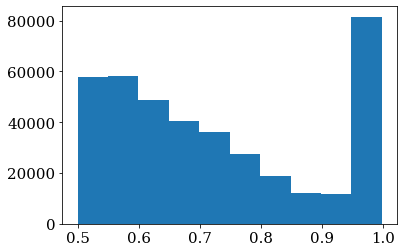

In [289]:
plt.hist(alpha_0.flatten())

In [281]:
dataref.lev[5]

<xarray.DataArray 'lev' ()>
array(54.59548)
Coordinates:
    lev      float64 54.6
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          level
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

Text(0, 0.5, 'Mean Lev roof [hPa]')

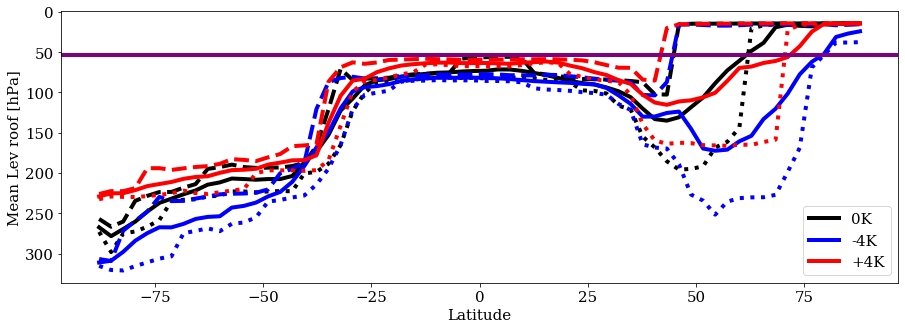

In [282]:
plt.figure(figsize=(15,5))
plt.plot(dataref.lat,np.mean(lev_roof_0,axis=(0,2)),color='k',label='0K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=25),color='k',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=75),color='k',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_m4,axis=(0,2)),color='b',label='-4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=25),color='b',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=75),color='b',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_p4,axis=(0,2)),color='r',label='+4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=25),color='r',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=75),color='r',linestyle=':')
plt.gca().invert_yaxis()
plt.legend()
plt.axhline(y=54,color='purple')
plt.xlabel('Latitude')
plt.ylabel('Mean Lev roof [hPa]')

In [267]:
lev_roof_0 = data2levroof(dataref,'continuous',Tnot=2)
lev_roof_m4 = data2levroof(datam4K,'continuous',Tnot=2)
lev_roof_p4 = data2levroof(datap4K,'continuous',Tnot=2)

Text(0, 0.5, 'Mean Lev roof [hPa]')

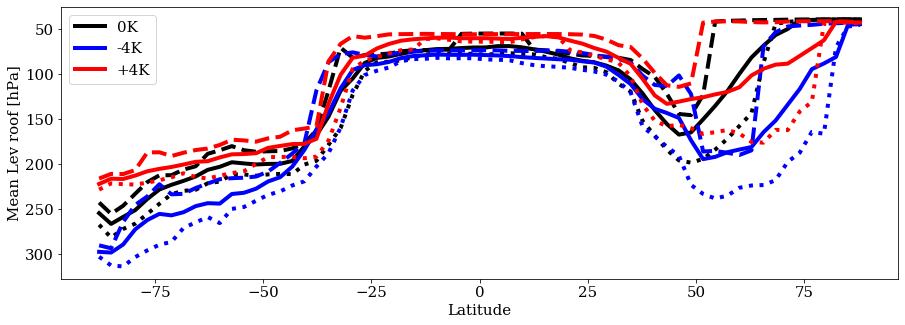

In [268]:
plt.figure(figsize=(15,5))
plt.plot(dataref.lat,np.mean(lev_roof_0,axis=(0,2)),color='k',label='0K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=25),color='k',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=75),color='k',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_m4,axis=(0,2)),color='b',label='-4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=25),color='b',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=75),color='b',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_p4,axis=(0,2)),color='r',label='+4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=25),color='r',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=75),color='r',linestyle=':')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Mean Lev roof [hPa]')

In [269]:
lev_roof_0 = data2levroof(dataref,'continuous',Tnot=0.1)
lev_roof_m4 = data2levroof(datam4K,'continuous',Tnot=0.1)
lev_roof_p4 = data2levroof(datap4K,'continuous',Tnot=0.1)

Text(0, 0.5, 'Mean Lev roof [hPa]')

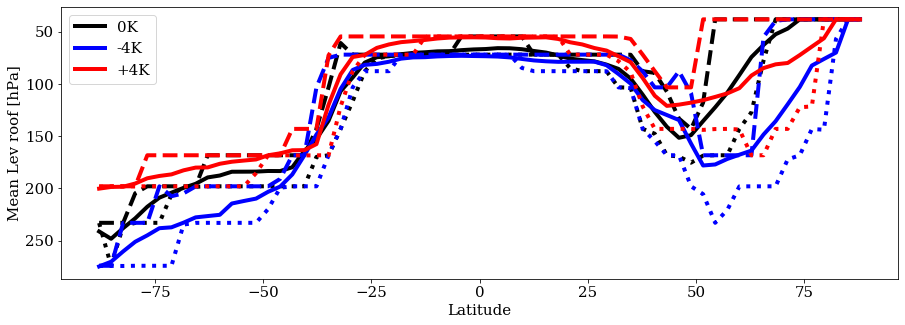

In [270]:
plt.figure(figsize=(15,5))
plt.plot(dataref.lat,np.mean(lev_roof_0,axis=(0,2)),color='k',label='0K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=25),color='k',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=75),color='k',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_m4,axis=(0,2)),color='b',label='-4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=25),color='b',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=75),color='b',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_p4,axis=(0,2)),color='r',label='+4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=25),color='r',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=75),color='r',linestyle=':')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Mean Lev roof [hPa]')

In [271]:
lev_roof_0 = data2levroof(dataref,'continuous',Tnot=1)
lev_roof_m4 = data2levroof(datam4K,'continuous',Tnot=1)
lev_roof_p4 = data2levroof(datap4K,'continuous',Tnot=1)

Text(0, 0.5, 'Mean Lev roof [hPa]')

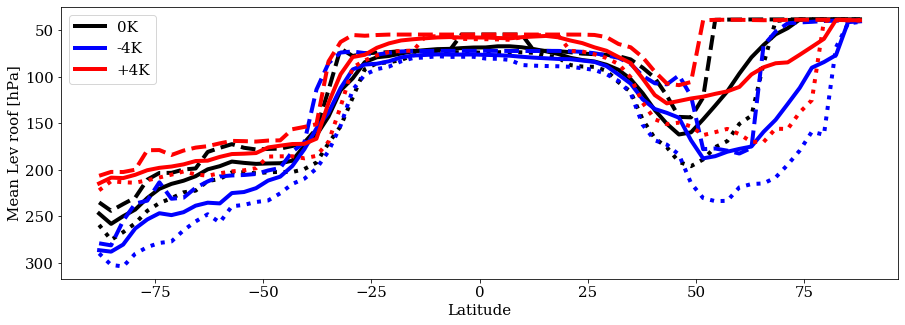

In [272]:
plt.figure(figsize=(15,5))
plt.plot(dataref.lat,np.mean(lev_roof_0,axis=(0,2)),color='k',label='0K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=25),color='k',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_0,axis=(0,2),q=75),color='k',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_m4,axis=(0,2)),color='b',label='-4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=25),color='b',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_m4,axis=(0,2),q=75),color='b',linestyle=':')
plt.plot(dataref.lat,np.mean(lev_roof_p4,axis=(0,2)),color='r',label='+4K')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=25),color='r',linestyle='--')
plt.plot(dataref.lat,np.percentile(a=lev_roof_p4,axis=(0,2),q=75),color='r',linestyle=':')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Mean Lev roof [hPa]')

## Zooming on NP to find bug

In [95]:
lev_roof_m4.shape

(48, 64, 128)

In [99]:
datam4K.TAP.shape

(48, 30, 64, 128)

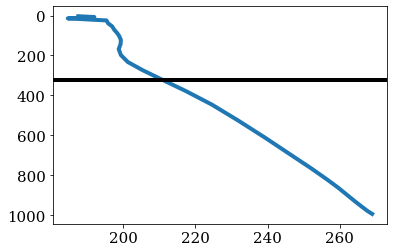

In [139]:
plt.plot(np.mean(datam4K.TAP.values[:,:,-5:,:],axis=(0,2,3)),datam4K.lev)
plt.axhline(y=np.mean(lev_roof_m4[:,-5:,:],axis=(0,1,2)),color='k')
plt.gca().invert_yaxis()

(-2, 2)

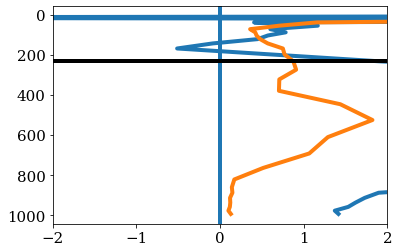

In [165]:
plt.plot(np.mean(np.diff(datam4K.TAP.values[:,:,-5:,:],axis=1),axis=(0,2,3)),datam4K.lev[1:])
plt.plot(np.std(a=np.diff(datam4K.TAP.values[:,:,-5:,:],axis=1),axis=(0,2,3)),datam4K.lev[1:])
#plt.plot(np.std(a=np.diff(datam4K.TAP.values[:,:,-5:,:],axis=1),axis=(0,2,3)),datam4K.lev[1:])
plt.axvline(x=0)
plt.axhline(y=np.mean(lev_roof_m4[:,-5:,:],axis=(0,1,2)),color='k')
plt.gca().invert_yaxis()
plt.xlim((-2,2))

In [107]:
T_NP = datam4K.TAP.values[:,:,-5:,:]

In [108]:
T_NP.shape

(48, 30, 5, 128)

In [116]:
datam4K.lev.values[np.argmin(T_NP[:,6:,:,:],axis=1)+6]

array([[[72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01245055, 72.01245055],
        [72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01245055, 72.01245055],
        [72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01245055, 72.01245055],
        [72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01245055, 72.01245055],
        [72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01245055, 72.01245055]],

       [[72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01245055, 72.01245055],
        [72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01245055, 72.01245055],
        [72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01245055, 72.01245055],
        [72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01245055, 72.01245055],
        [72.01245055, 72.01245055, 72.01245055, ..., 72.01245055,
         72.01

In [119]:
datam4K.lev.values[np.argmin(T_NP[:,9:,:,:],axis=1)+9]

array([[[232.82861896, 197.9080867 , 197.9080867 , ..., 197.9080867 ,
         232.82861896, 232.82861896],
        [197.9080867 , 197.9080867 , 197.9080867 , ..., 168.22507977,
         197.9080867 , 232.82861896],
        [168.22507977, 197.9080867 , 197.9080867 , ..., 168.22507977,
         168.22507977, 168.22507977],
        [168.22507977, 168.22507977, 168.22507977, ..., 168.22507977,
         168.22507977, 168.22507977],
        [168.22507977, 168.22507977, 168.22507977, ..., 168.22507977,
         168.22507977, 168.22507977]],

       [[232.82861896, 197.9080867 , 197.9080867 , ..., 197.9080867 ,
         232.82861896, 232.82861896],
        [197.9080867 , 197.9080867 , 197.9080867 , ..., 168.22507977,
         197.9080867 , 232.82861896],
        [168.22507977, 197.9080867 , 197.9080867 , ..., 168.22507977,
         168.22507977, 168.22507977],
        [168.22507977, 168.22507977, 168.22507977, ..., 168.22507977,
         168.22507977, 168.22507977],
        [168.22507977, 168

# Test (PW,GMS) scaling for amplitude of convective heating/moistening

## Constants

In [14]:
cpair = 1.00464e3
latvap = 2.501e6
g = 9.8
eps = 0.622 # Ratio of molecular weight(H2O)/molecular weight(dry air)
R_D = 287 # Specific gas constant of dry air in J/K/kg

## Test on m4K first

In [24]:
QV = datam4K.QAP.values
TABS = datam4K.TAP.values
lev = datam4K.lev.values

In [25]:
# Calculate geopotential height assuming hydrostasy
S = QV.shape

r = QV/(QV**0-QV)
Tv = TABS*(r**0+r/eps)/(r**0+r)
RHO = 1e2*np.moveaxis(np.tile(lev,(S[0],S[2],S[3],1)),3,1)/(R_D*Tv)

Z = -sin.cumtrapz(x=1e2*lev,y=1/(G*RHO),axis=1)
Z = np.concatenate((np.zeros((S[0],1,S[2],S[3])),Z),axis=1)
Z = Z-np.moveaxis(np.tile(Z[:,-1,:,:],(S[1],1,1,1)),0,1)

In [26]:
# Calculate dry static energy
dse = cpair*TABS+g*Z

In [27]:
# Calculate heating to advection of moisture coefficient
HAM = -L_V*np.diff(QV,axis=1)/np.diff(dse,axis=1)
HAM = np.maximum(HAM,0)

In [141]:
HAM.shape

(432, 29, 64, 128)

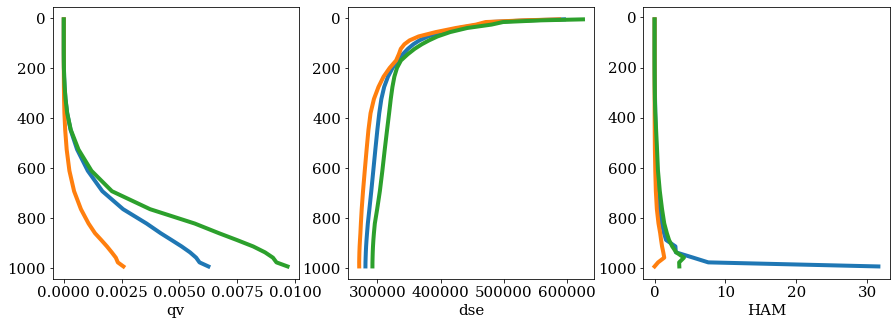

In [36]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

for i,label in enumerate(['qv','dse','HAM']):
    if i==0: ar = QV; z = datam4K.lev.values
    elif i==1: ar = dse; z = datam4K.lev.values
    elif i==2: ar = HAM; z = datam4K.lev.values[1:]
        
    ax[i].plot(np.mean(ar[:,:,:,:],axis=(0,2,3)),z)
    ax[i].plot(np.percentile(a=ar[:,:,:,:],axis=(0,2,3),q=25),z)
    ax[i].plot(np.percentile(a=ar[:,:,:,:],axis=(0,2,3),q=75),z)
    ax[i].invert_yaxis()
    ax[i].set_xlabel(label)

In [28]:
i250 = np.argmin(np.abs(lev-250))
i500 = np.argmin(np.abs(lev-500))
i750 = np.argmin(np.abs(lev-750))

In [29]:
print(lev[i250],lev[i500],lev[i750])

232.82861895859241 524.6871747076511 763.404481112957


In [30]:
# Now calculate net conversion = -Lv*delta(q)/delta(s) and PW
NetHAMm4K = -L_V*(QV[:,i250,:,:]-QV[:,-1,:,:])/(dse[:,i250,:,:]-dse[:,-1,:,:])
ltSSm4K = (dse[:,i750,:,:]-dse[:,-1,:,:])
mtSSm4K = (dse[:,i500,:,:]-dse[:,-1,:,:])
utSSm4K = (dse[:,i250,:,:]-dse[:,-1,:,:])
PWm4K = sin.trapz(QV*dP(datam4K.PS)/G,axis=1)
qsatm4K = qsat(datam4K.TAP,datam4K.P0,datam4K.PS,datam4K.hyam,datam4K.hybm)
PWsatm4K = sin.trapz(qsatm4K*dP(datam4K.PS)/G,axis=1)
CRHm4K = PWm4K/PWsatm4K
LHFm4K = datam4K.LHFLX/(L_V*qsatm4K[:,-1,:,:])
LHFm4Kpw = datam4K.LHFLX/PWsatm4K
LHFm4Ksur = datam4K.LHFLX/(L_V*qsatsurf(datam4K.TS,datam4K.P0,datam4K.PS))

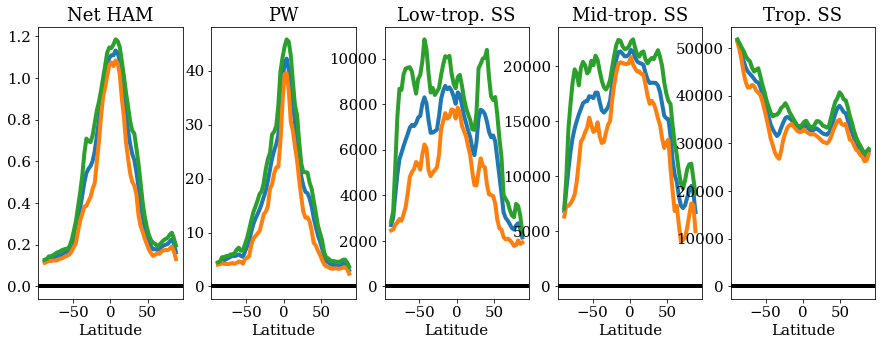

In [40]:
fig,ax = plt.subplots(1,5,figsize=(15,5))

for i,label in enumerate(['Net HAM','PW','Low-trop. SS','Mid-trop. SS','Trop. SS']):
    if i==0: ar = NetHAMm4K
    elif i==1: ar = PWm4K
    elif i==2: ar = ltSSm4K
    elif i==3: ar = mtSSm4K
    elif i==4: ar = utSSm4K

    ax[i].plot(datam4K.lat,np.mean(ar,axis=(0,2)))
    ax[i].plot(datam4K.lat,np.percentile(a=ar,axis=(0,2),q=25))
    ax[i].plot(datam4K.lat,np.percentile(a=ar,axis=(0,2),q=75))
    ax[i].axhline(y=0,color='k')
    ax[i].set_xlabel('Latitude')
    ax[i].set_title(label)

In [125]:
# Now calculate net convective heating and moistening within climate to see how they scale with PW/NetHAM
HEATm4K = np.sum(cpair*datam4K.TPHYSTND*dP(datam4K.PS)/g,axis=1).values
MOISTm4K = np.sum(latvap*datam4K.PHQ*dP(datam4K.PS)/g,axis=1).values
ABSHEATm4K = np.sum(np.abs(cpair*datam4K.TPHYSTND*dP(datam4K.PS)/g),axis=1).values
ABSMOISTm4K = np.sum(np.abs(latvap*datam4K.PHQ*dP(datam4K.PS)/g),axis=1).values

In [42]:
PWhist,PWbinedg = np.histogram(a=PWm4K,bins=100)
NetHAMhist,NetHAMbinedg = np.histogram(a=NetHAMm4K,bins=100)
LTsshist,LTssbinedg = np.histogram(a=ltSSm4K,bins=100)
MTsshist,MTssbinedg = np.histogram(a=mtSSm4K,bins=100)
UTsshist,UTssbinedg = np.histogram(a=utSSm4K,bins=100)

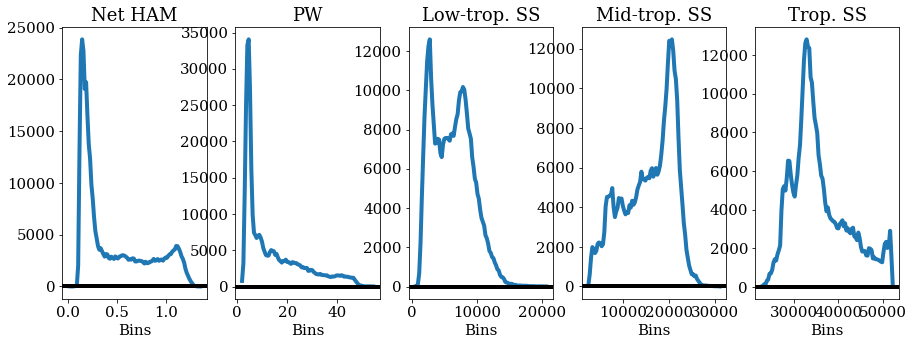

In [43]:
fig,ax = plt.subplots(1,5,figsize=(15,5))

for i,label in enumerate(['Net HAM','PW','Low-trop. SS','Mid-trop. SS','Trop. SS']):
    if i==0: pdf = NetHAMhist; edg = NetHAMbinedg; mid = edg2bin(edg)
    elif i==1: pdf = PWhist; edg = PWbinedg; mid = edg2bin(edg)
    elif i==2: pdf = LTsshist; edg = LTssbinedg; mid = edg2bin(edg)
    elif i==3: pdf = MTsshist; edg = MTssbinedg; mid = edg2bin(edg)
    elif i==4: pdf = UTsshist; edg = UTssbinedg; mid = edg2bin(edg)

    ax[i].plot(mid,pdf)
    ax[i].axhline(y=0,color='k')
    ax[i].set_xlabel('Bins')
    ax[i].set_title(label)

In [44]:
Hmean = {}
Hstd = {}
Mmean = {}
Mstd = {}

In [45]:
for i,label in enumerate(['Net HAM','PW','Low-trop. SS','Mid-trop. SS','Trop. SS']):
    if i==0: bin_edges = NetHAMbinedg; field_x = NetHAMm4K;
    elif i==1: bin_edges = PWbinedg; field_x = PWm4K;
    elif i==2: bin_edges = LTssbinedg; field_x = ltSSm4K;
    elif i==3: bin_edges = MTssbinedg; field_x = mtSSm4K;
    elif i==4: bin_edges = UTssbinedg; field_x = utSSm4K;
        
    Hmean[label],Hstd[label] = conditional_avg_and_std(bin_edges,field_x,HEATm4K)
    Mmean[label],Mstd[label] = conditional_avg_and_std(bin_edges,field_x,MOISTm4K)

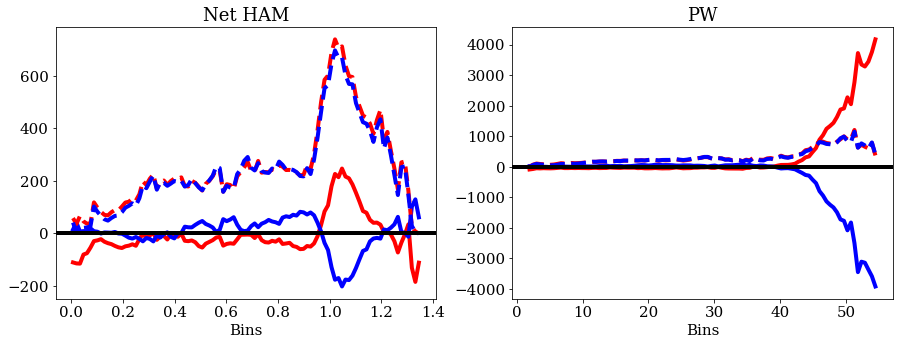

In [46]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

for i,label in enumerate(['Net HAM','PW']):
    if i==0: pdf = NetHAMhist; edg = NetHAMbinedg; mid = edg2bin(edg); 
    elif i==1: pdf = PWhist; edg = PWbinedg; mid = edg2bin(edg)

    ax[i].plot(mid,Hmean[label],color='r')
    ax[i].plot(mid,Mmean[label],color='b')
    ax[i].plot(mid,Hstd[label],color='r',linestyle='--')
    ax[i].plot(mid,Mstd[label],color='b',linestyle='--')
    ax[i].axhline(y=0,color='k')
    ax[i].set_xlabel('Bins')
    ax[i].set_title(label)

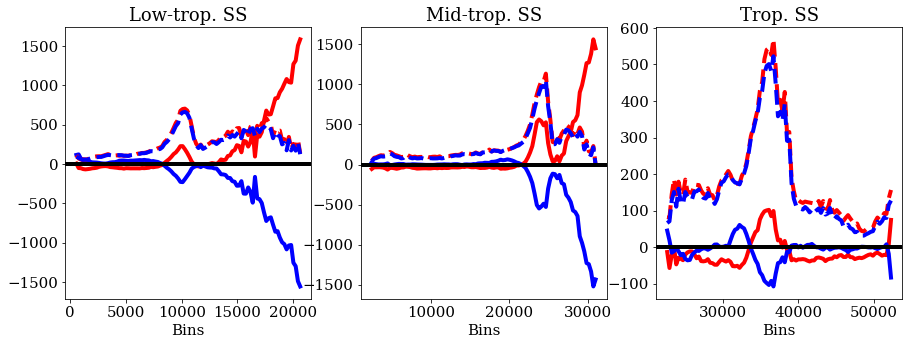

In [47]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

for i,label in enumerate(['Low-trop. SS','Mid-trop. SS','Trop. SS']):
    
    if i==0: pdf = LTsshist; edg = LTssbinedg; mid = edg2bin(edg)
    elif i==1: pdf = MTsshist; edg = MTssbinedg; mid = edg2bin(edg)
    elif i==2: pdf = UTsshist; edg = UTssbinedg; mid = edg2bin(edg)

    ax[i].plot(mid,Hmean[label],color='r')
    ax[i].plot(mid,Mmean[label],color='b')
    ax[i].plot(mid,Hstd[label],color='r',linestyle='--')
    ax[i].plot(mid,Mstd[label],color='b',linestyle='--')
    ax[i].axhline(y=0,color='k')
    ax[i].set_xlabel('Bins')
    ax[i].set_title(label)

In [48]:
# Only scale the positive convective heating and moistening
HEAThist,HEATbinedg = np.histogram(a=HEATm4K.flatten(),bins=100)
MOISThist,MOISTbinedg = np.histogram(a=MOISTm4K.flatten(),bins=100)

In [49]:
# Find percentile for which HEAT>0
HEATper = stats.percentileofscore(a=HEATm4K.flatten(),score=0)
MOISTper = stats.percentileofscore(a=MOISTm4K.flatten(),score=0)
print(HEATper,MOISTper)

71.06602986653645 33.339945475260414


In [50]:
# So let's use the 80th percentile by analogy with how we split last time
HEATp80 = np.percentile(a=HEATm4K.flatten(),q=80)

In [51]:
HEATp80

33.07332229614258

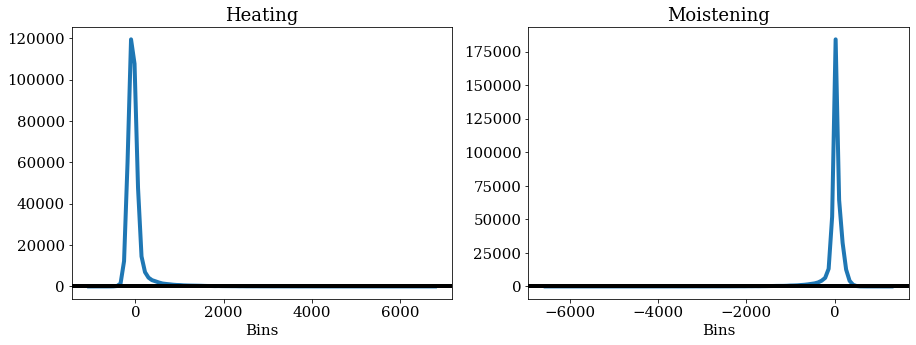

In [52]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

for i,label in enumerate(['Heating','Moistening']):
    if i==0: pdf = HEAThist; edg = HEATbinedg; mid = edg2bin(edg)
    elif i==1: pdf = MOISThist; edg = MOISTbinedg; mid = edg2bin(edg)

    ax[i].plot(mid,pdf)
    ax[i].axhline(y=0,color='k')
    ax[i].set_xlabel('Bins')
    ax[i].set_title(label)

In [53]:
NetHAMm4K.flatten()[HEATm4K.flatten()>HEATp80].shape

(78643,)

In [54]:
PWm4K.flatten().shape

(393216,)

In [55]:
X = np.concatenate((np.expand_dims(NetHAMm4K.flatten()[HEATm4K.flatten()>HEATp80],axis=1),
                   np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp80],axis=1)),axis=1)

In [56]:
X.shape

(78643, 2)

In [57]:
Yheat = np.expand_dims(HEATm4K.flatten()[HEATm4K.flatten()>HEATp80],axis=1)
Ymoist = np.expand_dims(MOISTm4K.flatten()[HEATm4K.flatten()>HEATp80],axis=1)

In [58]:
lin_reg = LinearRegression()
lin_reg.fit(X,Yheat)
print(lin_reg.intercept_,lin_reg.coef_)

[133.65159574] [[-1526.40264889    52.29920838]]


In [59]:
log_reg = LinearRegression()
log_reg.fit(np.log10(X),np.log10(Yheat))
print(log_reg.intercept_,log_reg.coef_)

[-0.03386558] [[-1.16426244  1.54444072]]


In [60]:
Yheat_linpred = lin_reg.predict(X)
Yheat_logpred = 10**log_reg.predict(np.log10(X))

Performance of both models

In [61]:
np.mean((Yheat-Yheat_linpred)**2)/np.var(Yheat)

0.6207200591216444

In [62]:
np.mean((Yheat-Yheat_logpred)**2)/np.var(Yheat)

0.9113704520506473

Compare to model using PW only

In [63]:
X0 = np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp80],axis=1)

In [64]:
lin_reg0 = LinearRegression()
lin_reg0.fit(X0,Yheat)
print(lin_reg0.intercept_,lin_reg0.coef_)

[-21.29123] [[15.6903715]]


In [65]:
log_reg0 = LinearRegression()
log_reg0.fit(np.log10(X0),np.log10(Yheat))
print(log_reg0.intercept_,log_reg0.coef_)

[1.5235063] [[0.5517373]]


In [66]:
Yheat_linpred0 = lin_reg0.predict(X0)
Yheat_logpred0 = 10**log_reg0.predict(np.log10(X0))

In [67]:
np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)

0.76603854

In [68]:
np.mean((Yheat-Yheat_logpred0)**2)/np.var(Yheat)

0.97032505

Now how sensitive is it to the percentile we choose to isolate extreme heating events?  
And is it really worth including the GMS?

In [69]:
Perc_array = np.array([75,80,85,90])

In [70]:
for iperc,perc in enumerate(Perc_array):
    print('\n')
    print('perc=',perc)
    HEATp = np.percentile(a=HEATm4K.flatten(),q=perc)
    
    X0 = np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)
    X = np.concatenate((np.expand_dims(NetHAMm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1),
                        np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)),axis=1)
    
    Yheat = np.expand_dims(HEATm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)
    Ymoist = np.expand_dims(MOISTm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)
    
    print('**LINEAR**')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(X0,Yheat)
    Yheat_linpred0 = lin_reg0.predict(X0)
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('PWm4K regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(X0,Ymoist)
    Ymoist_linpred0 = lin_reg0.predict(X0)
    score0 = np.mean((Ymoist-Ymoist_linpred0)**2)/np.var(Ymoist)
    print('PWm4K regression for moistening: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(X,Yheat)
    Yheat_linpred0 = lin_reg0.predict(X)
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('(PWm4K,HAM) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(X,Ymoist)
    Ymoist_linpred0 = lin_reg0.predict(X)
    score0 = np.mean((Ymoist-Ymoist_linpred0)**2)/np.var(Ymoist)
    print('PWm4K,HAM regression for moistening: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')



perc= 75
**LINEAR**
PWm4K regression for heating: intercept= [-38.47345] Coefficient= [[14.865585]] error= 76.8 % of variance


PWm4K regression for moistening: intercept= [69.79469] Coefficient= [[-12.896812]] error= 83.0 % of variance


(PWm4K,HAM) regression for heating: intercept= [95.74436171] Coefficient= [[-1414.43368171    49.70410179]] 
 error= 61.8 % of variance


PWm4K,HAM regression for moistening: intercept= [-84.19893209] Coefficient= [[1622.83889594  -52.8685023 ]] 
 error= 63.9 % of variance


perc= 80
**LINEAR**
PWm4K regression for heating: intercept= [-21.29123] Coefficient= [[15.6903715]] error= 76.6 % of variance


PWm4K regression for moistening: intercept= [59.11537] Coefficient= [[-13.997761]] error= 81.9 % of variance


(PWm4K,HAM) regression for heating: intercept= [133.65159574] Coefficient= [[-1526.40264889    52.29920838]] 
 error= 62.1 % of variance


PWm4K,HAM regression for moistening: intercept= [-115.50936987] Coefficient= [[1720.29680072  -55.256902

In [71]:
for iperc,perc in enumerate(Perc_array):
    print('\n')
    print('perc=',perc)
    HEATp = np.percentile(a=HEATm4K.flatten(),q=perc)
    
    X0 = np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)
    X = np.concatenate((np.expand_dims(NetHAMm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1),
                        np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)),axis=1)
    
    Yheat = np.expand_dims(HEATm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)
    Ymoist = np.expand_dims(MOISTm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)
    
    print('**LOGARITHMIC**')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(X0),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(X0))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('PWm4K regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(X),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(X))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('(PWm4K,HAM) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')



perc= 75
**LOGARITHMIC**
PWm4K regression for heating: intercept= [1.2958121] Coefficient= [[0.62395406]] error= 98.5 % of variance


(PWm4K,HAM) regression for heating: intercept= [-0.33761425] Coefficient= [[-1.20574318  1.67257896]] 
 error= 92.9 % of variance


perc= 80
**LOGARITHMIC**
PWm4K regression for heating: intercept= [1.5235063] Coefficient= [[0.5517373]] error= 97.0 % of variance


(PWm4K,HAM) regression for heating: intercept= [-0.03386558] Coefficient= [[-1.16426244  1.54444072]] 
 error= 91.1 % of variance


perc= 85
**LOGARITHMIC**
PWm4K regression for heating: intercept= [1.726861] Coefficient= [[0.5085051]] error= 94.6 % of variance


(PWm4K,HAM) regression for heating: intercept= [0.39327412] Coefficient= [[-1.00795664  1.35063835]] 
 error= 89.2 % of variance


perc= 90
**LOGARITHMIC**
PWm4K regression for heating: intercept= [1.9887826] Coefficient= [[0.44254896]] error= 92.5 % of variance


(PWm4K,HAM) regression for heating: intercept= [0.72775735] Coefficien

Now test which one is most predictive among lower-tropospheric, mid-tropospheric and upper-tropospheric static stability

In [72]:
Perc_array = np.array([80,90])

In [73]:
for iperc,perc in enumerate(Perc_array):
    print('\n')
    print('perc=',perc)
    HEATp = np.percentile(a=HEATm4K.flatten(),q=perc)
    
    X0 = np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)
    X = np.concatenate((np.expand_dims(NetHAMm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1),
                        np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)),axis=1)
    XL = np.concatenate((np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1),
                        np.expand_dims(ltSSm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)),axis=1)
    XM = np.concatenate((np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1),
                        np.expand_dims(mtSSm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)),axis=1)
    XU = np.concatenate((np.expand_dims(PWm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1),
                        np.expand_dims(utSSm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)),axis=1)
    
    Yheat = np.expand_dims(HEATm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)
    Ymoist = np.expand_dims(MOISTm4K.flatten()[HEATm4K.flatten()>HEATp],axis=1)
    
    print('**LOGARITHMIC**')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(X0),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(X0))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('PWm4K regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(X),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(X))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('(PWm4K,HAM) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(XL),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(XL))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('(LTm4K,PW) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(XM),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(XM))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('\n')
    print('(MTm4K,PW) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(XU),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(XU))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('\n')
    print('(UTm4K,PW) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')



perc= 80
**LOGARITHMIC**
PWm4K regression for heating: intercept= [1.5235063] Coefficient= [[0.5517373]] error= 97.0 % of variance


(PWm4K,HAM) regression for heating: intercept= [-0.03386558] Coefficient= [[-1.16426244  1.54444072]] 
 error= 91.1 % of variance


(LTm4K,PW) regression for heating: intercept= [1.41896248] Coefficient= [[0.5392724  0.03124925]] 
 error= 97.0 % of variance




(MTm4K,PW) regression for heating: intercept= [3.63750029] Coefficient= [[ 0.75788688 -0.5594154 ]] 
 error= 96.3 % of variance


(UTm4K,PW) regression for heating: intercept= [0.20273958] Coefficient= [[0.56516937 0.28742812]] 
 error= 96.5 % of variance


perc= 90
**LOGARITHMIC**
PWm4K regression for heating: intercept= [1.9887826] Coefficient= [[0.44254896]] error= 92.5 % of variance


(PWm4K,HAM) regression for heating: intercept= [0.72775735] Coefficient= [[-0.96969394  1.23086124]] 
 error= 87.1 % of variance


(LTm4K,PW) regression for heating: intercept= [1.0252398] Coefficient= [[0.32087

## Repeat test for p4K

In [31]:
QV = datap4K.QAP.values
TABS = datap4K.TAP.values
lev = datap4K.lev.values

In [32]:
# Calculate geopotential height assuming hydrostasy
S = QV.shape

r = QV/(QV**0-QV)
Tv = TABS*(r**0+r/eps)/(r**0+r)
RHO = 1e2*np.moveaxis(np.tile(lev,(S[0],S[2],S[3],1)),3,1)/(R_D*Tv)

Z = -sin.cumtrapz(x=1e2*lev,y=1/(G*RHO),axis=1)
Z = np.concatenate((np.zeros((S[0],1,S[2],S[3])),Z),axis=1)
Z = Z-np.moveaxis(np.tile(Z[:,-1,:,:],(S[1],1,1,1)),0,1)

In [33]:
# Now calculate net conversion = -Lv*delta(q)/delta(s) and PW
NetHAMp4K = -L_V*(QV[:,i250,:,:]-QV[:,-1,:,:])/(dse[:,i250,:,:]-dse[:,-1,:,:])
PWp4K = sin.trapz(QV*dP(datap4K.PS)/G,axis=1)
ltSSp4K = (dse[:,i750,:,:]-dse[:,-1,:,:])
mtSSp4K = (dse[:,i500,:,:]-dse[:,-1,:,:])
utSSp4K = (dse[:,i250,:,:]-dse[:,-1,:,:])
qsatp4K = qsat(datap4K.TAP,datap4K.P0,datap4K.PS,datap4K.hyam,datap4K.hybm)
PWsatp4K = sin.trapz(qsatp4K*dP(datap4K.PS)/G,axis=1)
CRHp4K = PWp4K/PWsatp4K
LHFp4K = datap4K.LHFLX/(L_V*qsatp4K[:,-1,:,:])
LHFp4Kpw = datap4K.LHFLX/PWsatp4K
LHFp4Ksur = datap4K.LHFLX/(L_V*qsatsurf(datap4K.TS,datap4K.P0,datap4K.PS))

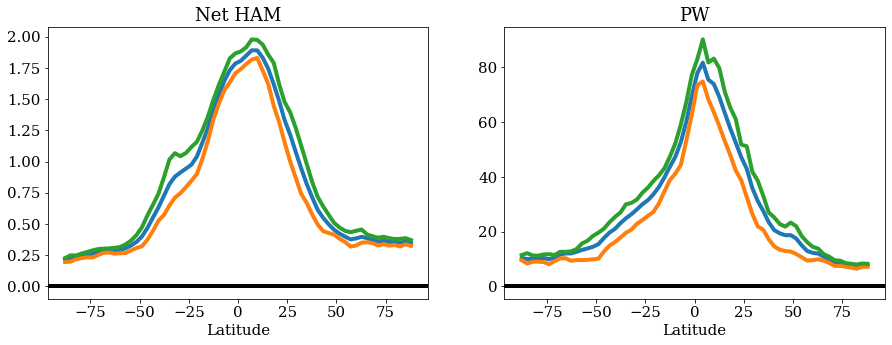

In [77]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

for i,label in enumerate(['Net HAM','PW']):
    if i==0: ar = NetHAMp4K
    elif i==1: ar = PWp4K

    ax[i].plot(datap4K.lat,np.mean(ar,axis=(0,2)))
    ax[i].plot(datap4K.lat,np.percentile(a=ar,axis=(0,2),q=25))
    ax[i].plot(datap4K.lat,np.percentile(a=ar,axis=(0,2),q=75))
    ax[i].axhline(y=0,color='k')
    ax[i].set_xlabel('Latitude')
    ax[i].set_title(label)

In [129]:
# Now calculate net convective heating and moistening within climate to see how they scale with PW/NetHAM
HEATp4K = np.sum(cpair*datap4K.TPHYSTND*dP(datap4K.PS)/g,axis=1).values
MOISTp4K = np.sum(latvap*datap4K.PHQ*dP(datap4K.PS)/g,axis=1).values
ABSHEATp4K = np.sum(np.abs(cpair*datap4K.TPHYSTND*dP(datap4K.PS)/g),axis=1).values
ABSMOISTp4K = np.sum(np.abs(latvap*datap4K.PHQ*dP(datap4K.PS)/g),axis=1).values

In [79]:
PWhist,PWbinedg = np.histogram(a=PWp4K,bins=100)
NetHAMhist,NetHAMbinedg = np.histogram(a=NetHAMp4K,bins=100)

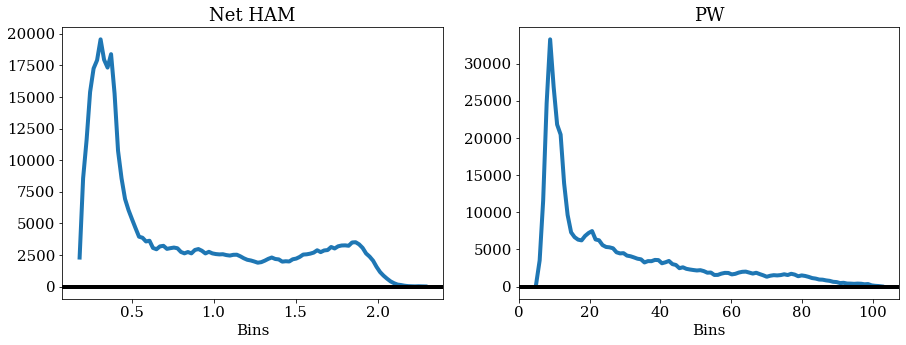

In [80]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

for i,label in enumerate(['Net HAM','PW']):
    if i==0: pdf = NetHAMhist; edg = NetHAMbinedg; mid = edg2bin(edg)
    elif i==1: pdf = PWhist; edg = PWbinedg; mid = edg2bin(edg)

    ax[i].plot(mid,pdf)
    ax[i].axhline(y=0,color='k')
    ax[i].set_xlabel('Bins')
    ax[i].set_title(label)

In [81]:
Perc_array = np.array([75,80,85,90])

In [82]:
for iperc,perc in enumerate(Perc_array):
    print('\n')
    print('perc=',perc)
    HEATp = np.percentile(a=HEATp4K.flatten(),q=perc)
    
    X0 = np.expand_dims(PWp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)
    X = np.concatenate((np.expand_dims(NetHAMp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1),
                        np.expand_dims(PWp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)),axis=1)
    
    Yheat = np.expand_dims(HEATp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)
    Ymoist = np.expand_dims(MOISTp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)
    
    print('**LINEAR**')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(X0,Yheat)
    Yheat_linpred0 = lin_reg0.predict(X0)
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('PWp4K regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(X0,Ymoist)
    Ymoist_linpred0 = lin_reg0.predict(X0)
    score0 = np.mean((Ymoist-Ymoist_linpred0)**2)/np.var(Ymoist)
    print('PWp4K regression for moistening: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(X,Yheat)
    Yheat_linpred0 = lin_reg0.predict(X)
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('(PWp4K,HAM) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(X,Ymoist)
    Ymoist_linpred0 = lin_reg0.predict(X)
    score0 = np.mean((Ymoist-Ymoist_linpred0)**2)/np.var(Ymoist)
    print('PWp4K,HAM regression for moistening: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')




perc= 75
**LINEAR**
PWp4K regression for heating: intercept= [-59.424255] Coefficient= [[10.672213]] error= 80.7 % of variance


PWp4K regression for moistening: intercept= [86.95604] Coefficient= [[-9.7544565]] error= 84.6 % of variance


(PWp4K,HAM) regression for heating: intercept= [93.66904116] Coefficient= [[-1103.07343656    34.45490194]] 
 error= 68.1 % of variance


PWp4K,HAM regression for moistening: intercept= [-92.89056665] Coefficient= [[1295.83818007  -37.69323221]] 
 error= 67.9 % of variance


perc= 80
**LINEAR**
PWp4K regression for heating: intercept= [-44.84543] Coefficient= [[11.751002]] error= 78.9 % of variance


PWp4K regression for moistening: intercept= [74.91995] Coefficient= [[-11.00517]] error= 82.2 % of variance


(PWp4K,HAM) regression for heating: intercept= [124.48530244] Coefficient= [[-1193.97708117    36.89618542]] 
 error= 66.9 % of variance


PWp4K,HAM regression for moistening: intercept= [-120.71362099] Coefficient= [[1379.44292365  -40.0562693

In [83]:
for iperc,perc in enumerate(Perc_array):
    print('\n')
    print('perc=',perc)
    HEATp = np.percentile(a=HEATp4K.flatten(),q=perc)
    
    X0 = np.expand_dims(PWp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)
    X = np.concatenate((np.expand_dims(NetHAMp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1),
                        np.expand_dims(PWp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)),axis=1)
    
    Yheat = np.expand_dims(HEATp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)
    Ymoist = np.expand_dims(MOISTp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)
    
    print('**LOGARITHMIC**')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(X0),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(X0))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('PWp4K regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(X),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(X))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('(PWp4K,HAM) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')



perc= 75
**LOGARITHMIC**
PWp4K regression for heating: intercept= [1.309974] Coefficient= [[0.52574486]] error= 101.7 % of variance


(PWp4K,HAM) regression for heating: intercept= [0.12801438] Coefficient= [[-0.85516344  1.26573635]] 
 error= 99.4 % of variance


perc= 80
**LOGARITHMIC**
PWp4K regression for heating: intercept= [1.497917] Coefficient= [[0.51023144]] error= 99.0 % of variance


(PWp4K,HAM) regression for heating: intercept= [0.56864996] Coefficient= [[-0.68489964  1.08848777]] 
 error= 97.0 % of variance


perc= 85
**LOGARITHMIC**
PWp4K regression for heating: intercept= [1.6938229] Coefficient= [[0.48571277]] error= 96.5 % of variance


(PWp4K,HAM) regression for heating: intercept= [1.03077263] Coefficient= [[-0.49848153  0.8953818 ]] 
 error= 95.0 % of variance


perc= 90
**LOGARITHMIC**
PWp4K regression for heating: intercept= [1.9251246] Coefficient= [[0.45396402]] error= 93.3 % of variance


(PWp4K,HAM) regression for heating: intercept= [1.48605704] Coefficien

In [84]:
for iperc,perc in enumerate(Perc_array):
    print('\n')
    print('perc=',perc)
    HEATp = np.percentile(a=HEATp4K.flatten(),q=perc)
    
    X0 = np.expand_dims(PWp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)
    X = np.concatenate((np.expand_dims(NetHAMp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1),
                        np.expand_dims(PWp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)),axis=1)
    XL = np.concatenate((np.expand_dims(PWp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1),
                        np.expand_dims(ltSSp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)),axis=1)
    XM = np.concatenate((np.expand_dims(PWp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1),
                        np.expand_dims(mtSSp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)),axis=1)
    XU = np.concatenate((np.expand_dims(PWp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1),
                        np.expand_dims(utSSp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)),axis=1)
    
    Yheat = np.expand_dims(HEATp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)
    Ymoist = np.expand_dims(MOISTp4K.flatten()[HEATp4K.flatten()>HEATp],axis=1)
    
    print('**LOGARITHMIC**')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(X0),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(X0))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('PWp4K regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(X),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(X))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('(PWp4K,HAM) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(XL),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(XL))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('(LTp4K,PW) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')
    print('\n')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(XM),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(XM))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('\n')
    print('(MTp4K,PW) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')
    lin_reg0 = LinearRegression()
    lin_reg0.fit(np.log10(XU),np.log10(Yheat))
    Yheat_linpred0 = 10**lin_reg0.predict(np.log10(XU))
    score0 = np.mean((Yheat-Yheat_linpred0)**2)/np.var(Yheat)
    print('\n')
    print('(UTp4K,PW) regression for heating: intercept=',lin_reg0.intercept_,'Coefficient=',lin_reg0.coef_,'\n error=','%02.1f'%(100*score0),'% of variance')




perc= 75
**LOGARITHMIC**
PWp4K regression for heating: intercept= [1.309974] Coefficient= [[0.52574486]] error= 101.7 % of variance


(PWp4K,HAM) regression for heating: intercept= [0.12801438] Coefficient= [[-0.85516344  1.26573635]] 
 error= 99.4 % of variance


(LTp4K,PW) regression for heating: intercept= [2.68350595] Coefficient= [[ 0.66158143 -0.41487661]] 
 error= 100.5 % of variance




(MTp4K,PW) regression for heating: intercept= [3.62099107] Coefficient= [[ 0.7300201  -0.62088874]] 
 error= 100.2 % of variance


(UTp4K,PW) regression for heating: intercept= [4.44145757] Coefficient= [[ 0.48927251 -0.67751998]] 
 error= 101.7 % of variance


perc= 80
**LOGARITHMIC**
PWp4K regression for heating: intercept= [1.497917] Coefficient= [[0.51023144]] error= 99.0 % of variance


(PWp4K,HAM) regression for heating: intercept= [0.56864996] Coefficient= [[-0.68489964  1.08848777]] 
 error= 97.0 % of variance


(LTp4K,PW) regression for heating: intercept= [2.64125111] Coefficient= [[

## Compare candidate rescalings in both regimes

Candidate 1 = sqrt(PW)

In [85]:
Hp80m = np.percentile(a=HEATm4K.flatten(),q=80)
Hp80p = np.percentile(a=HEATp4K.flatten(),q=80)

In [125]:
Hsc1m4K = HEATm4K.flatten()[HEATm4K.flatten()>Hp80m]*(PWm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5
Hsc1p4K = HEATm4K.flatten()[HEATp4K.flatten()>Hp80p]*(PWp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5

Msc1m4K = MOISTm4K.flatten()[HEATm4K.flatten()>Hp80m]/(PWm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5
Msc1p4K = MOISTp4K.flatten()[HEATp4K.flatten()>Hp80p]/(PWp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5

In [126]:
Hsc2m4K = HEATm4K.flatten()[HEATm4K.flatten()>Hp80m]*(PWm4K.flatten()[HEATm4K.flatten()>Hp80m])**1/\
(NetHAMm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5
Hsc2p4K = HEATm4K.flatten()[HEATp4K.flatten()>Hp80p]*(PWp4K.flatten()[HEATp4K.flatten()>Hp80p])**1/\
(NetHAMp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5

Msc2m4K = MOISTm4K.flatten()[HEATm4K.flatten()>Hp80m]/(PWm4K.flatten()[HEATm4K.flatten()>Hp80m])**1*\
(NetHAMm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5
Msc2p4K = MOISTp4K.flatten()[HEATp4K.flatten()>Hp80p]/(PWp4K.flatten()[HEATp4K.flatten()>Hp80p])**1*\
(NetHAMp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5

In [127]:
Hsc3m4K = HEATm4K.flatten()[HEATm4K.flatten()>Hp80m]*(PWm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5/\
(mtSSm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5
Hsc3p4K = HEATm4K.flatten()[HEATp4K.flatten()>Hp80p]*(PWp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5/\
(mtSSp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5

Msc3m4K = MOISTm4K.flatten()[HEATm4K.flatten()>Hp80m]/(PWm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5*\
(mtSSm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5
Msc3p4K = MOISTp4K.flatten()[HEATp4K.flatten()>Hp80p]/(PWp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5*\
(mtSSp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5

In [128]:
Hsc4m4K = HEATm4K.flatten()[HEATm4K.flatten()>Hp80m]*(PWm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5*\
(utSSm4K.flatten()[HEATm4K.flatten()>Hp80m])**0.5
Hsc4p4K = HEATm4K.flatten()[HEATp4K.flatten()>Hp80p]*(PWp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5*\
(utSSp4K.flatten()[HEATp4K.flatten()>Hp80p])**0.5

Msc4m4K = MOISTm4K.flatten()[HEATm4K.flatten()>Hp80m]*(PWm4K.flatten()[HEATm4K.flatten()>Hp80m])**(-0.5)*\
(utSSm4K.flatten()[HEATm4K.flatten()>Hp80m])**(-0.5)
Msc4p4K = MOISTp4K.flatten()[HEATp4K.flatten()>Hp80p]*(PWp4K.flatten()[HEATp4K.flatten()>Hp80p])**(-0.5)*\
(utSSp4K.flatten()[HEATp4K.flatten()>Hp80p])**(-0.5)

In [129]:
Hnoscm4KH = np.histogram(HEATm4K.flatten()[HEATm4K.flatten()>Hp80m],bins=100)
Hnoscp4KH = np.histogram(HEATp4K.flatten()[HEATp4K.flatten()>Hp80m],bins=100)
Mnoscm4KH = np.histogram(MOISTm4K.flatten()[HEATm4K.flatten()>Hp80m],bins=100)
Mnoscp4KH = np.histogram(MOISTp4K.flatten()[HEATp4K.flatten()>Hp80m],bins=100)

Hsc1m4KH = np.histogram(Hsc1m4K,bins=100)
Hsc1p4KH = np.histogram(Hsc1p4K,bins=100)
Msc1m4KH = np.histogram(Msc1m4K,bins=100)
Msc1p4KH = np.histogram(Msc1p4K,bins=100)

Hsc2m4KH = np.histogram(Hsc2m4K,bins=100)
Hsc2p4KH = np.histogram(Hsc2p4K,bins=100)
Msc2m4KH = np.histogram(Msc2m4K,bins=100)
Msc2p4KH = np.histogram(Msc2p4K,bins=100)

Hsc3m4KH = np.histogram(Hsc3m4K,bins=100)
Hsc3p4KH = np.histogram(Hsc3p4K,bins=100)
Msc3m4KH = np.histogram(Msc3m4K,bins=100)
Msc3p4KH = np.histogram(Msc3p4K,bins=100)

Hsc4m4KH = np.histogram(Hsc4m4K,bins=100)
Hsc4p4KH = np.histogram(Hsc4p4K,bins=100)
Msc4m4KH = np.histogram(Msc4m4K,bins=100)
Msc4p4KH = np.histogram(Msc4p4K,bins=100)

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log1

Text(0.5, 0, '$\\dot{T}\\ \\sqrt{\\mathrm{PW}/(\\mathrm{DSE}_{500}-\\mathrm{DSE}_{NS})}$')

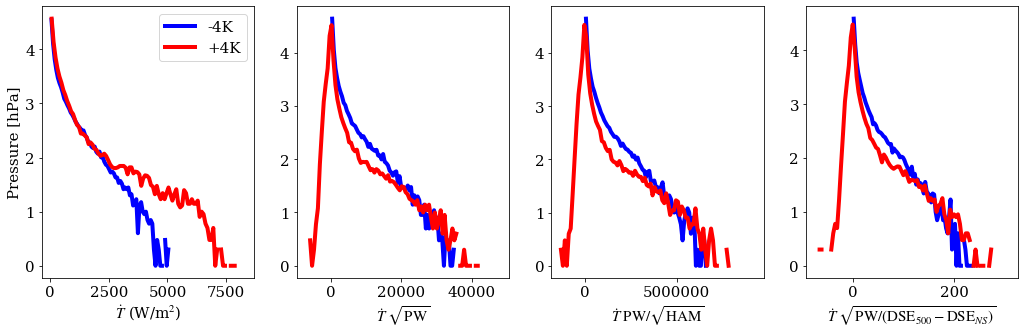

In [130]:
fig,ax = plt.subplots(1,4,figsize=(17.5,5))

ax[0].plot(edg2bin(Hnoscm4KH[1]),np.log10(Hnoscm4KH[0]),color='b',label='-4K')
ax[0].plot(edg2bin(Hnoscp4KH[1]),np.log10(Hnoscp4KH[0]),color='r',label='+4K')
ax[0].legend()
ax[0].set_ylabel('Pressure [hPa]')
ax[0].set_xlabel('$\dot{T}$ (W/m$^2$)')

ax[1].plot(edg2bin(Hsc1m4KH[1]),np.log10(Hsc1m4KH[0]),color='b')
ax[1].plot(edg2bin(Hsc1p4KH[1]),np.log10(Hsc1p4KH[0]),color='r')
ax[1].set_xlabel('$\dot{T}\ \sqrt{\mathrm{PW}}$')

# ax[2].plot(edg2bin(Hsc2m4KH[1]),np.log10(Hsc2m4KH[0]),color='b')
# ax[2].plot(edg2bin(Hsc2p4KH[1]),np.log10(Hsc2p4KH[0]),color='r')
# ax[2].set_xlabel('$\dot{T}\ \mathrm{PW}/\sqrt{\mathrm{HAM}}$')
ax[2].plot(edg2bin(Hsc4m4KH[1]),np.log10(Hsc4m4KH[0]),color='b')
ax[2].plot(edg2bin(Hsc4p4KH[1]),np.log10(Hsc4p4KH[0]),color='r')
ax[2].set_xlabel('$\dot{T}\ \mathrm{PW}/\sqrt{\mathrm{HAM}}$')

ax[3].plot(edg2bin(Hsc3m4KH[1]),np.log10(Hsc3m4KH[0]),color='b')
ax[3].plot(edg2bin(Hsc3p4KH[1]),np.log10(Hsc3p4KH[0]),color='r')
ax[3].set_xlabel('$\dot{T}\ \sqrt{\mathrm{PW}/(\mathrm{DSE}_{500}-\mathrm{DSE}_{NS})}$')

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log1

Text(0.5, 0, '$\\dot{q}\\ \\sqrt{(\\mathrm{DSE}_{500}-\\mathrm{DSE}_{NS})/\\mathrm{PW}}$')

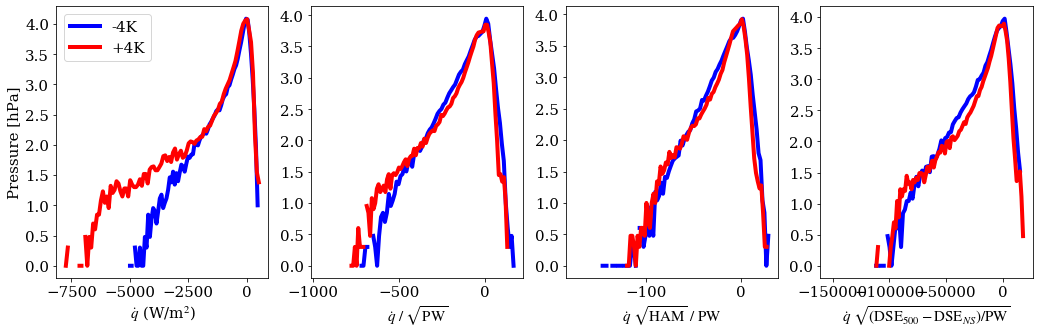

In [131]:
fig,ax = plt.subplots(1,4,figsize=(17.5,5))

ax[0].plot(edg2bin(Mnoscm4KH[1]),np.log10(Mnoscm4KH[0]),color='b',label='-4K')
ax[0].plot(edg2bin(Mnoscp4KH[1]),np.log10(Mnoscp4KH[0]),color='r',label='+4K')
ax[0].legend()
ax[0].set_ylabel('Pressure [hPa]')
ax[0].set_xlabel('$\dot{q}$ (W/m$^2$)')

ax[1].plot(edg2bin(Msc1m4KH[1]),np.log10(Msc1m4KH[0]),color='b')
ax[1].plot(edg2bin(Msc1p4KH[1]),np.log10(Msc1p4KH[0]),color='r')
ax[1].set_xlabel('$\dot{q}\ /\ \sqrt{\mathrm{PW}}$')

ax[2].plot(edg2bin(Msc2m4KH[1]),np.log10(Msc2m4KH[0]),color='b')
ax[2].plot(edg2bin(Msc2p4KH[1]),np.log10(Msc2p4KH[0]),color='r')
ax[2].set_xlabel('$\dot{q}\ \sqrt{\mathrm{HAM}}\ /\ \mathrm{PW}$')
# ax[2].plot(edg2bin(Msc4m4KH[1]),np.log10(Msc4m4KH[0]),color='b')
# ax[2].plot(edg2bin(Msc4p4KH[1]),np.log10(Msc4p4KH[0]),color='r')
# ax[2].set_xlabel('$\dot{T}\ \mathrm{PW}/\sqrt{\mathrm{HAM}}$')

ax[3].plot(edg2bin(Msc3m4KH[1]),np.log10(Msc3m4KH[0]),color='b')
ax[3].plot(edg2bin(Msc3p4KH[1]),np.log10(Msc3p4KH[0]),color='r')
ax[3].set_xlabel('$\dot{q}\ \sqrt{(\mathrm{DSE}_{500}-\mathrm{DSE}_{NS})/\mathrm{PW}}$')

In [34]:
# Surface fluxes histograms
LHFm4K_hist = np.histogram(datam4K.LHFLX.values.flatten(),bins=100)
LHFp4K_hist = np.histogram(datap4K.LHFLX.values.flatten(),bins=100)

SHFm4K_hist = np.histogram(datam4K.SHFLX.values.flatten(),bins=100)
SHFp4K_hist = np.histogram(datap4K.SHFLX.values.flatten(),bins=100)

LHFm4Ksc_hist = np.histogram(LHFm4K.values.flatten(),bins=100)
LHFp4Ksc_hist = np.histogram(LHFp4K.values.flatten(),bins=100)

LHFm4KscPW_hist = np.histogram(LHFm4Kpw.values.flatten(),bins=100)
LHFp4KscPW_hist = np.histogram(LHFp4Kpw.values.flatten(),bins=100)

LHFm4KscS_hist = np.histogram(LHFm4Ksur.values.flatten(),bins=100)
LHFp4KscS_hist = np.histogram(LHFp4Ksur.values.flatten(),bins=100)
# Hnoscp4KH = np.histogram(HEATp4K.flatten()[HEATp4K.flatten()>Hp80m],bins=100)
# Mnoscm4KH = np.histogram(MOISTm4K.flatten()[HEATm4K.flatten()>Hp80m],bins=100)
# Mnoscp4KH = np.histogram(MOISTp4K.flatten()[HEATp4K.flatten()>Hp80m],bins=100)

/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/work/05823/tg851228/stampede2/MINICONDA/envs/cbrain_1/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/work

Text(0.5, 0, 'LHF scaled by qsatS')

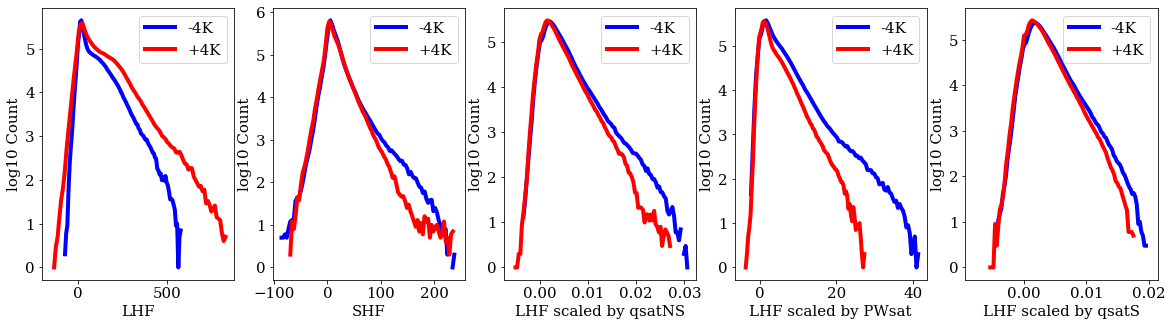

In [36]:
fig,ax = plt.subplots(1,5,figsize=(20,5))

ax[0].plot(edg2bin(LHFm4K_hist[1]),np.log10(LHFm4K_hist[0]),color='b',label='-4K')
ax[0].plot(edg2bin(LHFp4K_hist[1]),np.log10(LHFp4K_hist[0]),color='r',label='+4K')
ax[0].legend()
ax[0].set_ylabel('log10 Count')
ax[0].set_xlabel('LHF')

ax[1].plot(edg2bin(SHFm4K_hist[1]),np.log10(SHFm4K_hist[0]),color='b',label='-4K')
ax[1].plot(edg2bin(SHFp4K_hist[1]),np.log10(SHFp4K_hist[0]),color='r',label='+4K')
ax[1].legend()
ax[1].set_ylabel('log10 Count')
ax[1].set_xlabel('SHF')

ax[2].plot(edg2bin(LHFm4Ksc_hist[1]),np.log10(LHFm4Ksc_hist[0]),color='b',label='-4K')
ax[2].plot(edg2bin(LHFp4Ksc_hist[1]),np.log10(LHFp4Ksc_hist[0]),color='r',label='+4K')
ax[2].legend()
ax[2].set_ylabel('log10 Count')
ax[2].set_xlabel('LHF scaled by qsatNS')

ax[3].plot(edg2bin(LHFm4KscPW_hist[1]),np.log10(LHFm4KscPW_hist[0]),color='b',label='-4K')
ax[3].plot(edg2bin(LHFp4KscPW_hist[1]),np.log10(LHFp4KscPW_hist[0]),color='r',label='+4K')
ax[3].legend()
ax[3].set_ylabel('log10 Count')
ax[3].set_xlabel('LHF scaled by PWsat')

ax[4].plot(edg2bin(LHFm4KscS_hist[1]),np.log10(LHFm4KscS_hist[0]),color='b',label='-4K')
ax[4].plot(edg2bin(LHFp4KscS_hist[1]),np.log10(LHFp4KscS_hist[0]),color='r',label='+4K')
ax[4].legend()
ax[4].set_ylabel('log10 Count')
ax[4].set_xlabel('LHF scaled by qsatS')

# ax[1].plot(edg2bin(Hsc1m4KH[1]),np.log10(Hsc1m4KH[0]),color='b')
# ax[1].plot(edg2bin(Hsc1p4KH[1]),np.log10(Hsc1p4KH[0]),color='r')
# ax[1].set_xlabel('$\dot{T}\ \sqrt{\mathrm{PW}}$')

In [132]:
HEATm4K_hist = np.histogram(HEATm4K.flatten()[CRHm4K.flatten()>0.8],bins=100)
HEATp4K_hist = np.histogram(HEATp4K.flatten()[CRHp4K.flatten()>0.8],bins=100)

ABSHEATm4K_hist = np.histogram(ABSHEATm4K.flatten()[CRHm4K.flatten()>0.8],bins=100)
ABSHEATp4K_hist = np.histogram(ABSHEATp4K.flatten()[CRHp4K.flatten()>0.8],bins=100)

psc = 1

HEATm4Ksc_hist = np.histogram(HEATm4K.flatten()[CRHm4K.flatten()>0.8]/PWm4K.flatten()[CRHm4K.flatten()>0.8]**psc,bins=100)
HEATp4Ksc_hist = np.histogram(HEATp4K.flatten()[CRHp4K.flatten()>0.8]/PWp4K.flatten()[CRHp4K.flatten()>0.8]**psc,bins=100)

ABSHEATm4Ksc_hist = np.histogram(ABSHEATm4K.flatten()[CRHm4K.flatten()>0.8]/PWm4K.flatten()[CRHm4K.flatten()>0.8]**psc,bins=100)
ABSHEATp4Ksc_hist = np.histogram(ABSHEATp4K.flatten()[CRHp4K.flatten()>0.8]/PWp4K.flatten()[CRHp4K.flatten()>0.8]**psc,bins=100)

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log1

Text(0.5, 0, 'Scaled col. abs heating CRH>0.8')

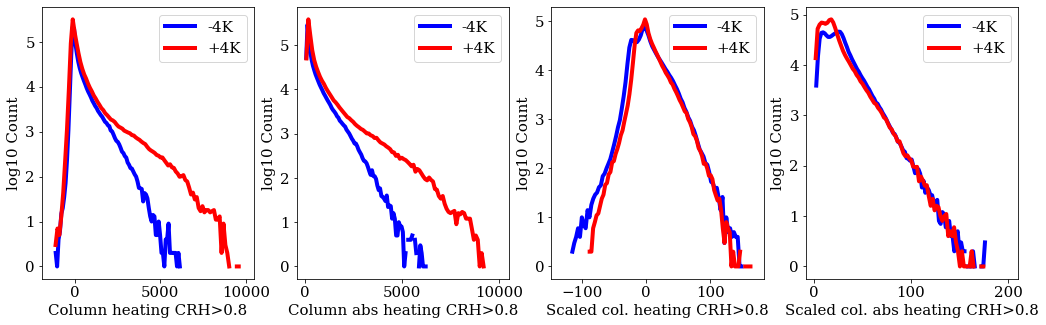

In [133]:
fig,ax = plt.subplots(1,4,figsize=(17.5,5))

ax[0].plot(edg2bin(HEATm4K_hist[1]),np.log10(HEATm4K_hist[0]),color='b',label='-4K')
ax[0].plot(edg2bin(HEATp4K_hist[1]),np.log10(HEATp4K_hist[0]),color='r',label='+4K')
ax[0].legend()
ax[0].set_ylabel('log10 Count')
ax[0].set_xlabel('Column heating CRH>0.8')

ax[1].plot(edg2bin(ABSHEATm4K_hist[1]),np.log10(ABSHEATm4K_hist[0]),color='b',label='-4K')
ax[1].plot(edg2bin(ABSHEATp4K_hist[1]),np.log10(ABSHEATp4K_hist[0]),color='r',label='+4K')
ax[1].legend()
ax[1].set_ylabel('log10 Count')
ax[1].set_xlabel('Column abs heating CRH>0.8')

ax[2].plot(edg2bin(HEATm4Ksc_hist[1]),np.log10(HEATm4Ksc_hist[0]),color='b',label='-4K')
ax[2].plot(edg2bin(HEATp4Ksc_hist[1]),np.log10(HEATp4Ksc_hist[0]),color='r',label='+4K')
ax[2].legend()
ax[2].set_ylabel('log10 Count')
ax[2].set_xlabel('Scaled col. heating CRH>0.8')

ax[3].plot(edg2bin(ABSHEATm4Ksc_hist[1]),np.log10(ABSHEATm4Ksc_hist[0]),color='b',label='-4K')
ax[3].plot(edg2bin(ABSHEATp4Ksc_hist[1]),np.log10(ABSHEATp4Ksc_hist[0]),color='r',label='+4K')
ax[3].legend()
ax[3].set_ylabel('log10 Count')
ax[3].set_xlabel('Scaled col. abs heating CRH>0.8')

In [134]:
MOISTm4K_hist = np.histogram(MOISTm4K.flatten()[CRHm4K.flatten()>0.8],bins=100)
MOISTp4K_hist = np.histogram(MOISTp4K.flatten()[CRHp4K.flatten()>0.8],bins=100)

ABSMOISTm4K_hist = np.histogram(ABSMOISTm4K.flatten()[CRHm4K.flatten()>0.8],bins=100)
ABSMOISTp4K_hist = np.histogram(ABSMOISTp4K.flatten()[CRHp4K.flatten()>0.8],bins=100)

psc = 1

MOISTm4Ksc_hist = np.histogram(MOISTm4K.flatten()[CRHm4K.flatten()>0.8]/PWm4K.flatten()[CRHm4K.flatten()>0.8]**psc,bins=100)
MOISTp4Ksc_hist = np.histogram(MOISTp4K.flatten()[CRHp4K.flatten()>0.8]/PWp4K.flatten()[CRHp4K.flatten()>0.8]**psc,bins=100)

ABSMOISTm4Ksc_hist = np.histogram(ABSMOISTm4K.flatten()[CRHm4K.flatten()>0.8]/PWm4K.flatten()[CRHm4K.flatten()>0.8]**psc,bins=100)
ABSMOISTp4Ksc_hist = np.histogram(ABSMOISTp4K.flatten()[CRHp4K.flatten()>0.8]/PWp4K.flatten()[CRHp4K.flatten()>0.8]**psc,bins=100)

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log1

Text(0.5, 0, 'Scaled col. abs moistening CRH>0.8')

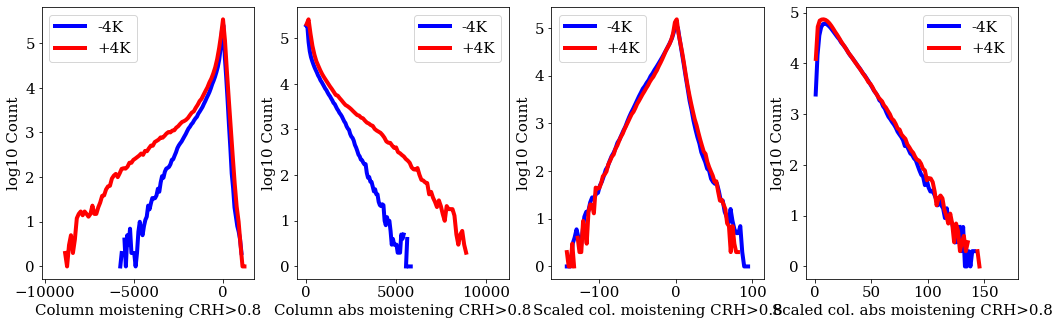

In [135]:
fig,ax = plt.subplots(1,4,figsize=(17.5,5))

ax[0].plot(edg2bin(MOISTm4K_hist[1]),np.log10(MOISTm4K_hist[0]),color='b',label='-4K')
ax[0].plot(edg2bin(MOISTp4K_hist[1]),np.log10(MOISTp4K_hist[0]),color='r',label='+4K')
ax[0].legend()
ax[0].set_ylabel('log10 Count')
ax[0].set_xlabel('Column moistening CRH>0.8')

ax[1].plot(edg2bin(ABSMOISTm4K_hist[1]),np.log10(ABSMOISTm4K_hist[0]),color='b',label='-4K')
ax[1].plot(edg2bin(ABSMOISTp4K_hist[1]),np.log10(ABSMOISTp4K_hist[0]),color='r',label='+4K')
ax[1].legend()
ax[1].set_ylabel('log10 Count')
ax[1].set_xlabel('Column abs moistening CRH>0.8')

ax[2].plot(edg2bin(MOISTm4Ksc_hist[1]),np.log10(MOISTm4Ksc_hist[0]),color='b',label='-4K')
ax[2].plot(edg2bin(MOISTp4Ksc_hist[1]),np.log10(MOISTp4Ksc_hist[0]),color='r',label='+4K')
ax[2].legend()
ax[2].set_ylabel('log10 Count')
ax[2].set_xlabel('Scaled col. moistening CRH>0.8')

ax[3].plot(edg2bin(ABSMOISTm4Ksc_hist[1]),np.log10(ABSMOISTm4Ksc_hist[0]),color='b',label='-4K')
ax[3].plot(edg2bin(ABSMOISTp4Ksc_hist[1]),np.log10(ABSMOISTp4Ksc_hist[0]),color='r',label='+4K')
ax[3].legend()
ax[3].set_ylabel('log10 Count')
ax[3].set_xlabel('Scaled col. abs moistening CRH>0.8')

# Figures for NOAA seminar

## CC scaling

In [13]:
TNS = {}; TNShist = {}; 
QNS = {}; QNShist = {}; QNS_TNS = {};
QSNS = {}; QSNShist = {}; QSNS_TNS = {};

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
        
    TNS[data] = d.TAP[:,-1,:,:].values
    QNS[data] = d.QAP[:,-1,:,:].values
    qsat0 = qsat(d.TAP,d.P0,d.PS,d.hyam,d.hybm)
    QSNS[data] = qsat0[:,-1,:,:].values
    
    TNShist[data] = np.histogram(TNS[data].flatten(),bins=100)
    QNShist[data] = np.histogram(QNS[data].flatten(),bins=100)
    QSNShist[data] = np.histogram(QSNS[data].flatten(),bins=100)
    
    QNS_TNS[data] = conditional_avg_and_std(TNShist[data][1],TNS[data].flatten(),QNS[data].flatten())
    QSNS_TNS[data] = conditional_avg_and_std(TNShist[data][1],TNS[data].flatten(),QSNS[data].flatten())

data= m4K
data= ref / 100  & edge= 297.9362 100  & edge= 273.92148287.73816
data= p4K / 100  & edge= 302.16534


In [14]:
COLOR = ['b','gray','red']

(0, 27)

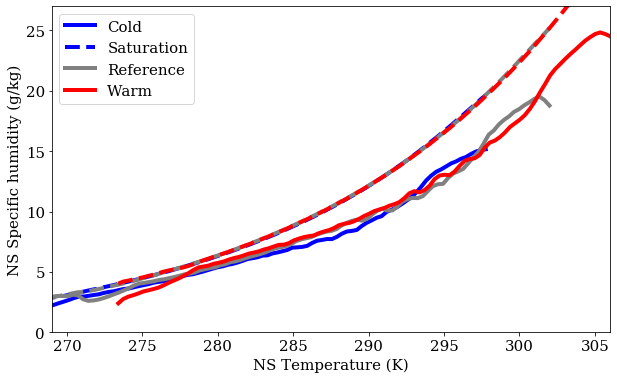

In [15]:
plt.figure(figsize=(10,6))

plt.plot(edg2bin(TNShist['m4K'][1]),1e3*QNS_TNS['m4K'][0],color='b',label='Cold')
plt.plot(edg2bin(TNShist['m4K'][1]),1e3*QSNS_TNS['m4K'][0],color='b',linestyle='--',label='Saturation')

plt.plot(edg2bin(TNShist['ref'][1]),1e3*QNS_TNS['ref'][0],color='gray',label='Reference')
plt.plot(edg2bin(TNShist['ref'][1]),1e3*QSNS_TNS['ref'][0],color='gray',linestyle='--')

plt.plot(edg2bin(TNShist['p4K'][1]),1e3*QNS_TNS['p4K'][0],color='r',label='Warm')
plt.plot(edg2bin(TNShist['p4K'][1]),1e3*QSNS_TNS['p4K'][0],color='r',linestyle='--')

plt.ylabel('NS Specific humidity (g/kg)')
plt.xlabel('NS Temperature (K)')
plt.legend(loc = 'upper left')
plt.xlim((269,306))
plt.ylim((0,27))
#name = 'CC1'
#plt.savefig(pathHOME+name+'.png',format='png')

## LHF scaling

In [16]:
LHFscaledNS = {}
LHFscaledS = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
    
    print('qsat, PW, CRH')
    qsat0 = qsat(d.TAP,1e5,d.PS,d.hyam,d.hybm)
    print('LHF')
    qsatS = qsatsurf(d.TS,d.P0,d.PS)
    LHFscaledNS[data] = d.LHFLX/(L_V*qsat0[:,-1,:,:])
    LHFscaledS[data] = d.LHFLX/(L_V*qsatS)
    print('\n')

data= m4K
qsat, PW, CRH
LHF


data= ref
qsat, PW, CRH
LHF


data= p4K
qsat, PW, CRH
LHF




In [17]:
LHFHIST = {}
SHFHIST = {}
LHFscaledSHIST = {}
LHFscaledNSHIST = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
        
    LHFHIST[data] = np.histogram(d.LHFLX.values.flatten(),bins=100)
    SHFHIST[data] = np.histogram(d.SHFLX.values.flatten(),bins=100)
    LHFscaledSHIST[data] = np.histogram(LHFscaledS[data].values.flatten(),bins=100)
    LHFscaledNSHIST[data] = np.histogram(LHFscaledNS[data].values.flatten(),bins=100)

data= m4K
data= ref
data= p4K


In [21]:
# Plot characteristics
fz = 40
lw = 8
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


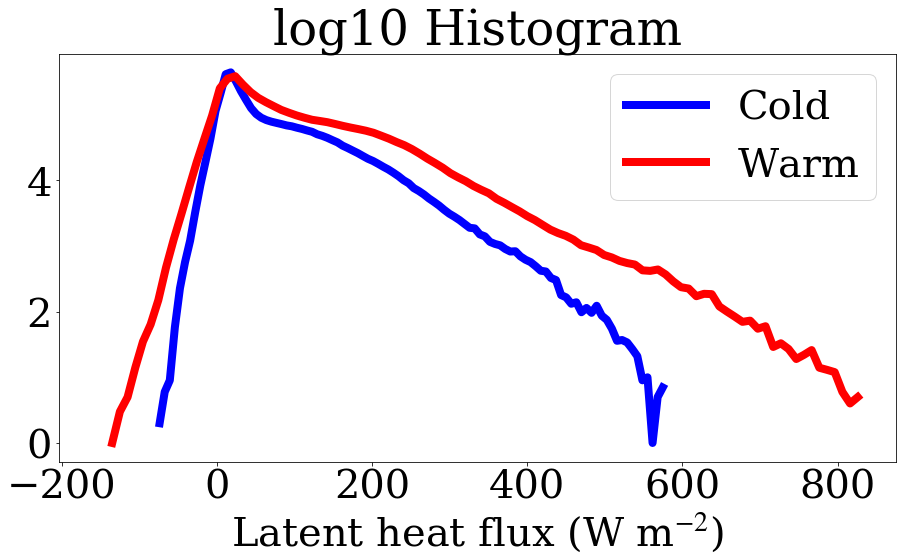

In [28]:
plt.figure(figsize=(15,7.5))
plt.plot(edg2bin(LHFHIST['m4K'][1]),np.log10(LHFHIST['m4K'][0]),color='b',label='Cold')
plt.plot(edg2bin(LHFHIST['p4K'][1]),np.log10(LHFHIST['p4K'][0]),color='r',label='Warm')
plt.xlabel('Latent heat flux (W m$^{-2}$)')
plt.title('log10 Histogram')
plt.legend(loc='upper right')

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


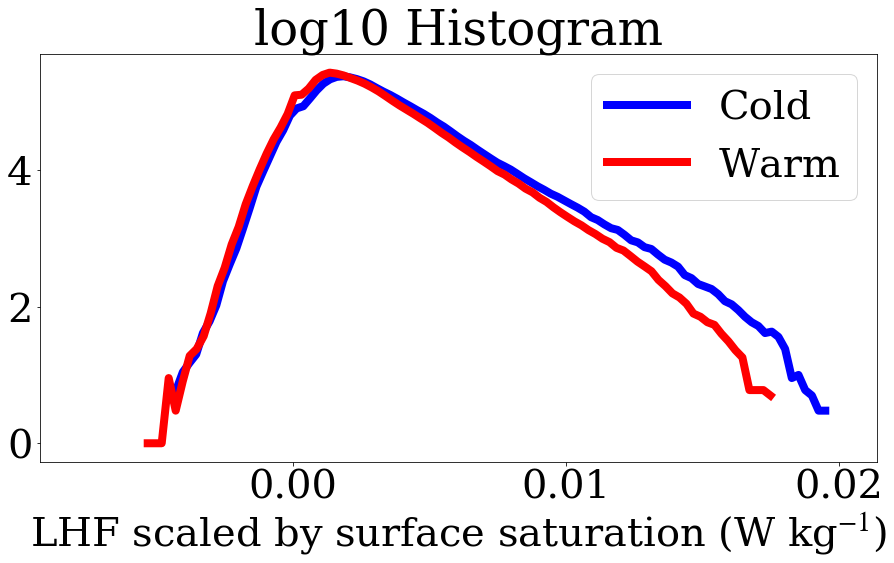

In [35]:
plt.figure(figsize=(15,7.5))
plt.plot(edg2bin(LHFscaledSHIST['m4K'][1]),np.log10(LHFscaledSHIST['m4K'][0]),color='b',label='Cold')
plt.plot(edg2bin(LHFscaledSHIST['p4K'][1]),np.log10(LHFscaledSHIST['p4K'][0]),color='r',label='Warm')
plt.xlabel('LHF scaled by surface saturation (W kg$^{-1}$)')
plt.title('log10 Histogram')
plt.legend(loc='upper right')

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


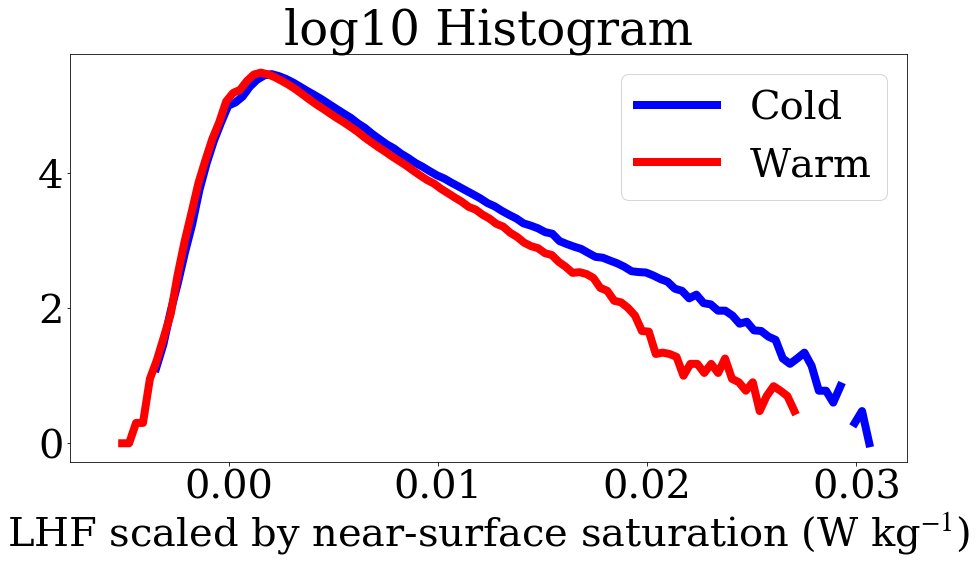

In [36]:
plt.figure(figsize=(15,7.5))
plt.plot(edg2bin(LHFscaledNSHIST['m4K'][1]),np.log10(LHFscaledNSHIST['m4K'][0]),color='b',label='Cold')
plt.plot(edg2bin(LHFscaledNSHIST['p4K'][1]),np.log10(LHFscaledNSHIST['p4K'][0]),color='r',label='Warm')
plt.xlabel('LHF scaled by near-surface saturation (W kg$^{-1}$)')
plt.title('log10 Histogram')
plt.legend(loc='upper right')

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


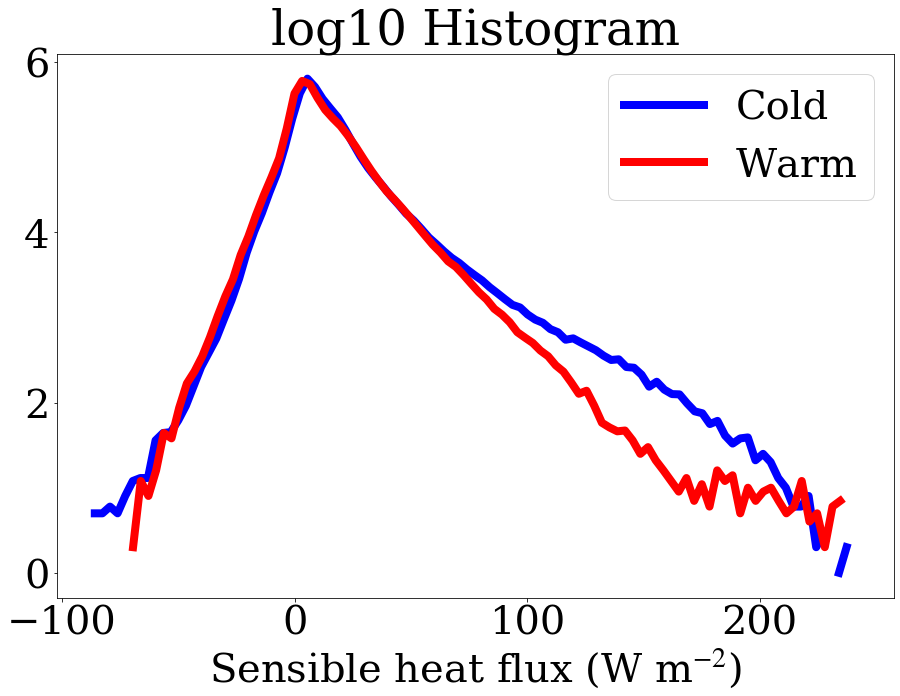

In [26]:
plt.figure(figsize=(15,10))
plt.plot(edg2bin(SHFHIST['m4K'][1]),np.log10(SHFHIST['m4K'][0]),color='b',label='Cold')
plt.plot(edg2bin(SHFHIST['p4K'][1]),np.log10(SHFHIST['p4K'][0]),color='r',label='Warm')
plt.xlabel('Sensible heat flux (W m$^{-2}$)')
plt.title('log10 Histogram')
plt.legend(loc='upper right')

## SHF and S0 distributions

TODO

## Trying out new scaling for T

In [16]:
T = {}; Thist = {};

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
        
    T[data] = d.TAP[:,-1,:,:].values
    Thist[data] = np.histogram(d.TAP.values.flatten(),bins=100)

data= m4K
data= ref
data= p4K


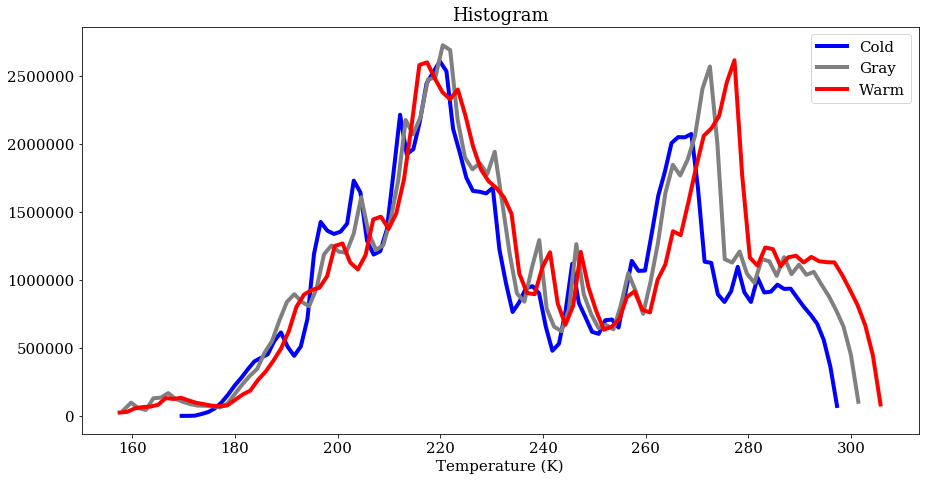

In [17]:
plt.figure(figsize=(15,7.5))
plt.plot(edg2bin(Thist['m4K'][1]),Thist['m4K'][0],color='b',label='Cold')
plt.plot(edg2bin(Thist['ref'][1]),Thist['ref'][0],color='gray',label='Gray')
plt.plot(edg2bin(Thist['p4K'][1]),Thist['p4K'][0],color='r',label='Warm')
plt.xlabel('Temperature (K)')
plt.title('Histogram')
plt.legend(loc='upper right')

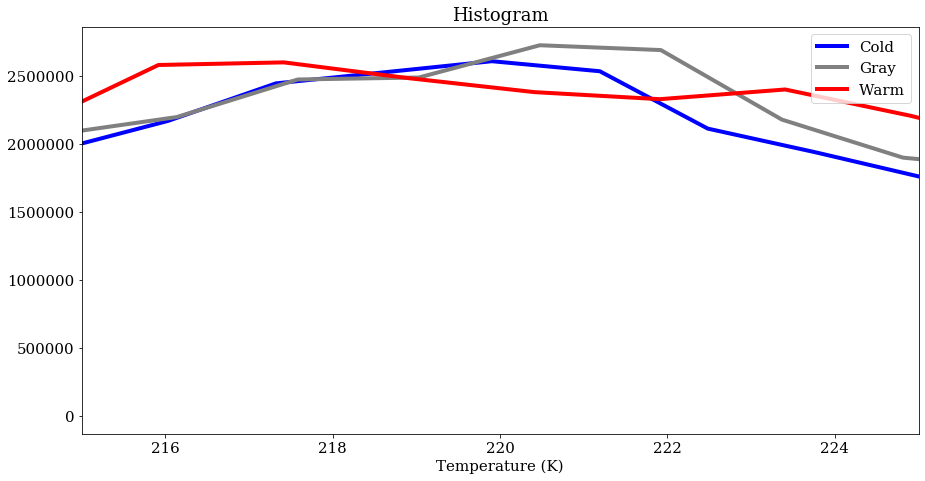

In [19]:
plt.figure(figsize=(15,7.5))
plt.plot(edg2bin(Thist['m4K'][1]),Thist['m4K'][0],color='b',label='Cold')
plt.plot(edg2bin(Thist['ref'][1]),Thist['ref'][0],color='gray',label='Gray')
plt.plot(edg2bin(Thist['p4K'][1]),Thist['p4K'][0],color='r',label='Warm')
plt.xlabel('Temperature (K)')
plt.xlim((215,225))
plt.title('Histogram')
plt.legend(loc='upper right')

In [22]:
T220hist = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
    
    T220 = (d.TAP.values-220)/(np.moveaxis(np.tile(d.TAP[:,-1,:,:].values,(30,1,1,1)),0,1)-220)
    T220hist[data] = np.histogram(T220,bins=100)

data= m4K
data= ref
data= p4K


In [26]:
# Plot characteristics
fz = 40
lw = 8
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

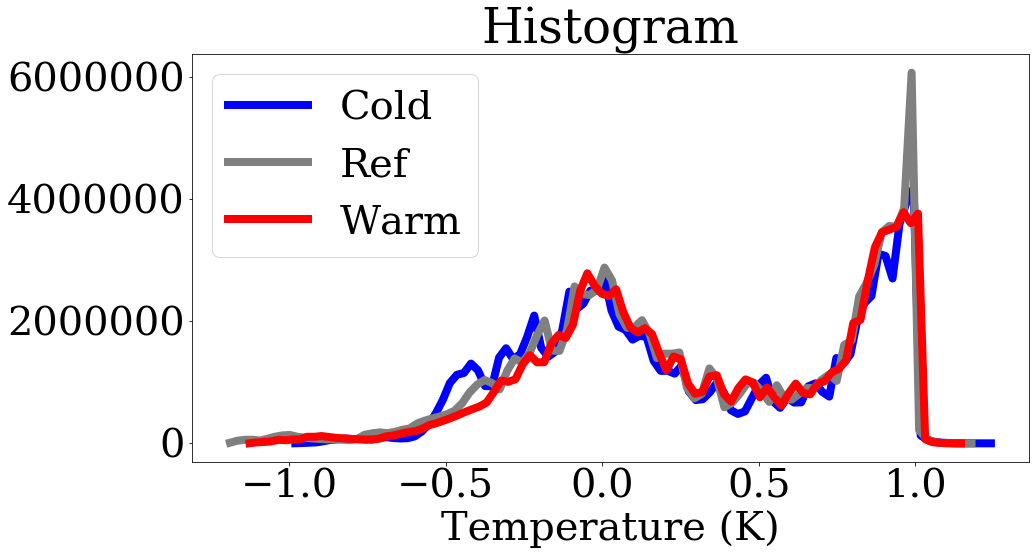

In [27]:
plt.figure(figsize=(15,7.5))
plt.plot(edg2bin(T220hist['m4K'][1]),T220hist['m4K'][0],color='b',label='Cold')
plt.plot(edg2bin(T220hist['ref'][1]),T220hist['ref'][0],color='gray',label='Ref')
plt.plot(edg2bin(T220hist['p4K'][1]),T220hist['p4K'][0],color='r',label='Warm')
plt.xlabel('Temperature (K)')
plt.title('Histogram')
plt.legend(loc='upper left')

## Trying a scaling for LHF based on the saturation deficit rather than the saturation itself

In [49]:
SD = {}
SSD = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
    
    print('qsat')
    qsat0 = qsat(d.TAP,1e5,d.PS,d.hyam,d.hybm)
    SD[data] = qsat0[:,-1,:,:]-d.QAP[:,-1,:,:]
    
    print('qsatS')
    qsatS = qsatsurf(d.TS,d.P0,d.PS)
    SSD[data] = qsatS-d.QAP[:,-1,:,:]

data= m4K
qsat
qsatS
data= ref
qsat
qsatS
data= p4K
qsat
qsatS


In [50]:
SDHIST = {}
SSDHIST = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
        
    SDHIST[data] = np.histogram(SD[data].values.flatten(),bins=100)
    SSDHIST[data] = np.histogram(SSD[data].values.flatten(),bins=100)

data= m4K
data= ref
data= p4K


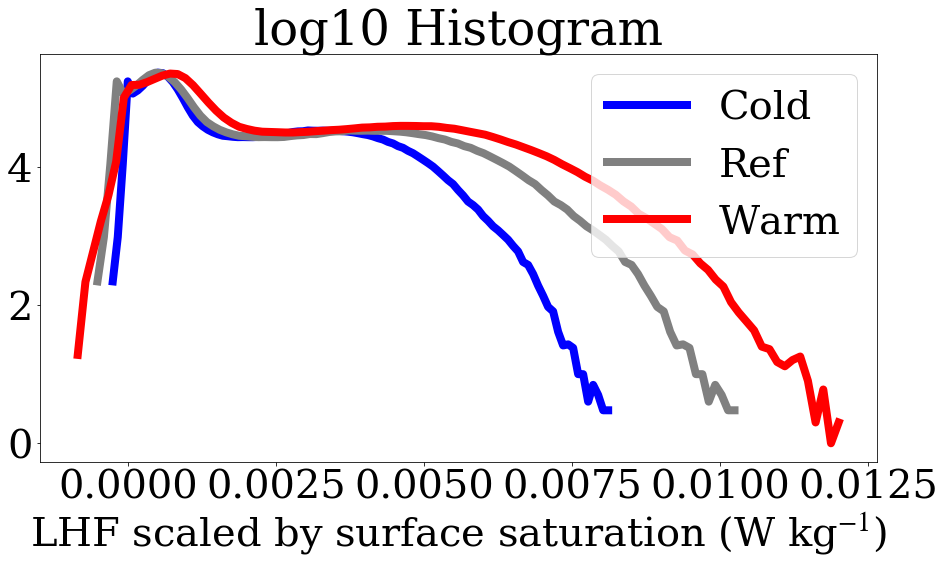

In [55]:
plt.figure(figsize=(15,7.5))
plt.plot(edg2bin(SDHIST['m4K'][1]),np.log10(SDHIST['m4K'][0]),color='b',label='Cold')
plt.plot(edg2bin(SDHIST['ref'][1]),np.log10(SDHIST['m4K'][0]),color='gray',label='Ref')
plt.plot(edg2bin(SDHIST['p4K'][1]),np.log10(SDHIST['p4K'][0]),color='r',label='Warm')
plt.xlabel('LHF scaled by surface saturation (W kg$^{-1}$)')
plt.title('log10 Histogram')
plt.legend(loc='upper right')

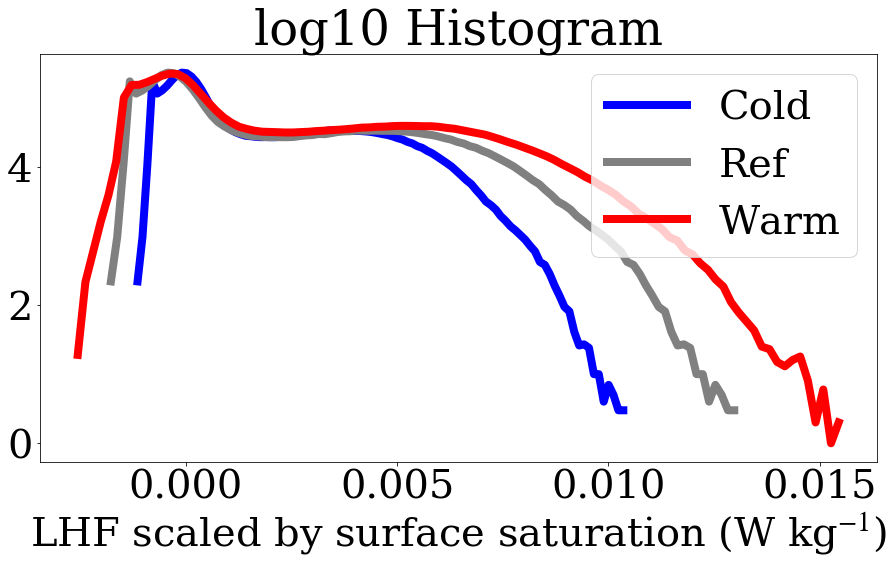

In [52]:
plt.figure(figsize=(15,7.5))
plt.plot(edg2bin(SSDHIST['m4K'][1]),np.log10(SDHIST['m4K'][0]),color='b',label='Cold')
plt.plot(edg2bin(SSDHIST['ref'][1]),np.log10(SDHIST['m4K'][0]),color='gray',label='Ref')
plt.plot(edg2bin(SSDHIST['p4K'][1]),np.log10(SDHIST['p4K'][0]),color='r',label='Warm')
plt.xlabel('LHF scaled by surface saturation (W kg$^{-1}$)')
plt.title('log10 Histogram')
plt.legend(loc='upper right')

In [91]:
LHFQHIST = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
    
    LHFQHIST[data] = np.histogram((d.LHFLX/(L_V*(1e-3+d.QAP[:,-1,:,:]))).values.flatten(),bins=100)

data= m4K
data= ref
data= p4K


/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


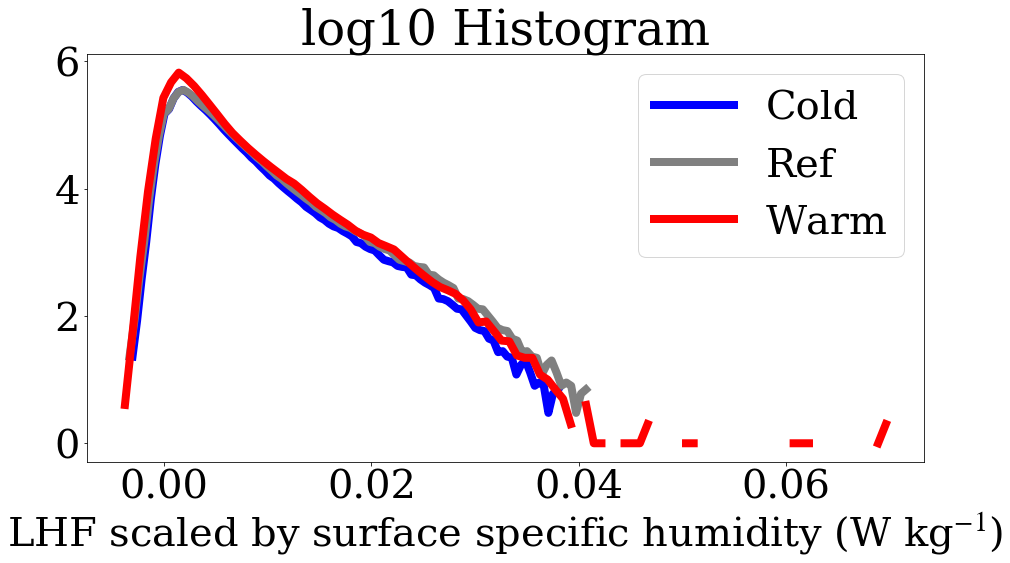

In [92]:
plt.figure(figsize=(15,7.5))
plt.plot(edg2bin(LHFQHIST['m4K'][1]),np.log10(LHFQHIST['m4K'][0]),color='b',label='Cold')
plt.plot(edg2bin(LHFQHIST['ref'][1]),np.log10(LHFQHIST['m4K'][0]),color='gray',label='Ref')
plt.plot(edg2bin(LHFQHIST['p4K'][1]),np.log10(LHFQHIST['p4K'][0]),color='r',label='Warm')
plt.xlabel('LHF scaled by surface specific humidity (W kg$^{-1}$)')
plt.title('log10 Histogram')
plt.legend(loc='upper right')

In [93]:
LHFSD0HIST = {}
LHFSD1HIST = {}
LHFSD2HIST = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
    
    LHFSD0HIST[data] = np.histogram((d.LHFLX/(L_V*(0e-3+SD[data]))).values.flatten(),bins=100)
    LHFSD1HIST[data] = np.histogram((d.LHFLX/(L_V*(1e-3+SD[data]))).values.flatten(),bins=100)
    LHFSD2HIST[data] = np.histogram((d.LHFLX/(L_V*(2e-3+SD[data]))).values.flatten(),bins=100)

data= m4K
data= ref
data= p4K


/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


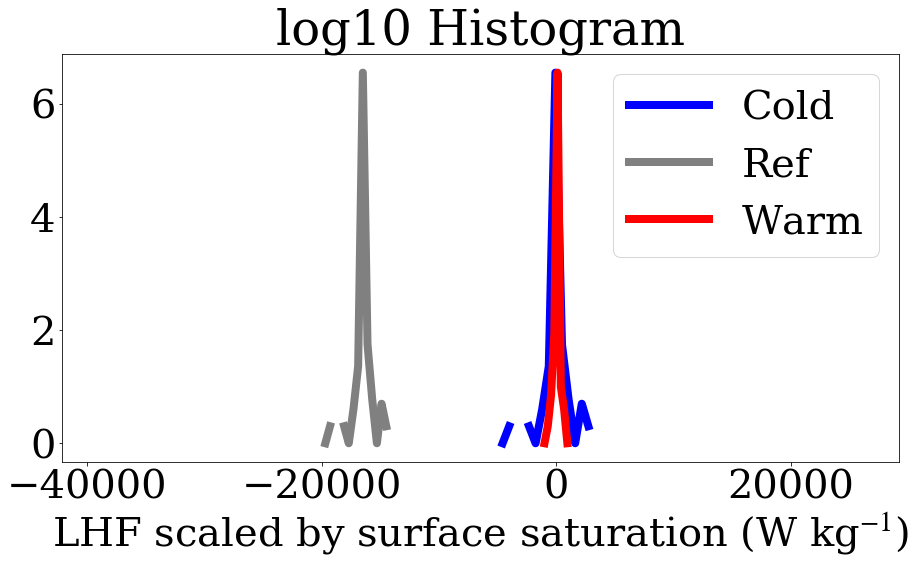

In [62]:
plt.figure(figsize=(15,7.5))
plt.plot(edg2bin(LHFSD0HIST['m4K'][1]),np.log10(LHFSD0HIST['m4K'][0]),color='b',label='Cold')
plt.plot(edg2bin(LHFSD0HIST['ref'][1]),np.log10(LHFSD0HIST['m4K'][0]),color='gray',label='Ref')
plt.plot(edg2bin(LHFSD0HIST['p4K'][1]),np.log10(LHFSD0HIST['p4K'][0]),color='r',label='Warm')
plt.xlabel('LHF scaled by surface saturation (W kg$^{-1}$)')
plt.title('log10 Histogram')
plt.legend(loc='upper right')

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


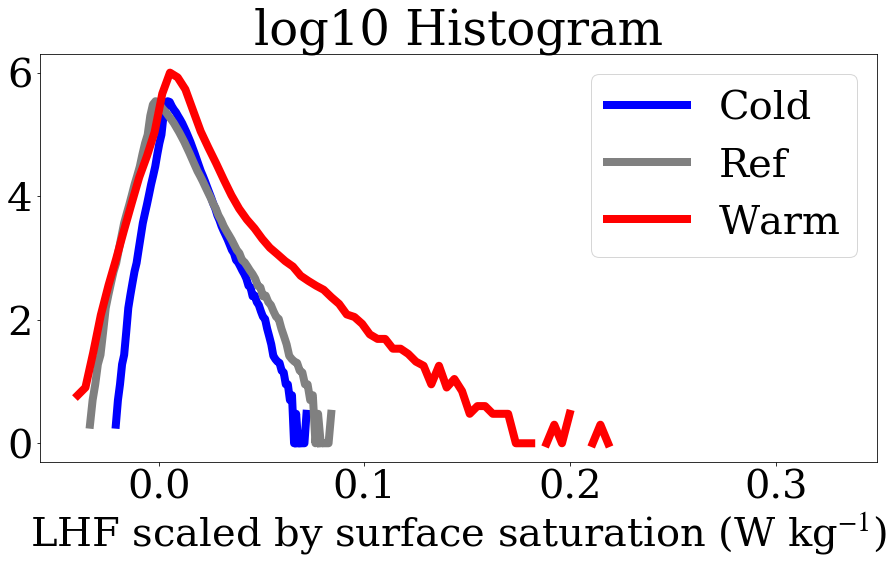

In [63]:
plt.figure(figsize=(15,7.5))
plt.plot(edg2bin(LHFSD1HIST['m4K'][1]),np.log10(LHFSD1HIST['m4K'][0]),color='b',label='Cold')
plt.plot(edg2bin(LHFSD1HIST['ref'][1]),np.log10(LHFSD1HIST['m4K'][0]),color='gray',label='Ref')
plt.plot(edg2bin(LHFSD1HIST['p4K'][1]),np.log10(LHFSD1HIST['p4K'][0]),color='r',label='Warm')
plt.xlabel('LHF scaled by surface saturation (W kg$^{-1}$)')
plt.title('log10 Histogram')
plt.legend(loc='upper right')

/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


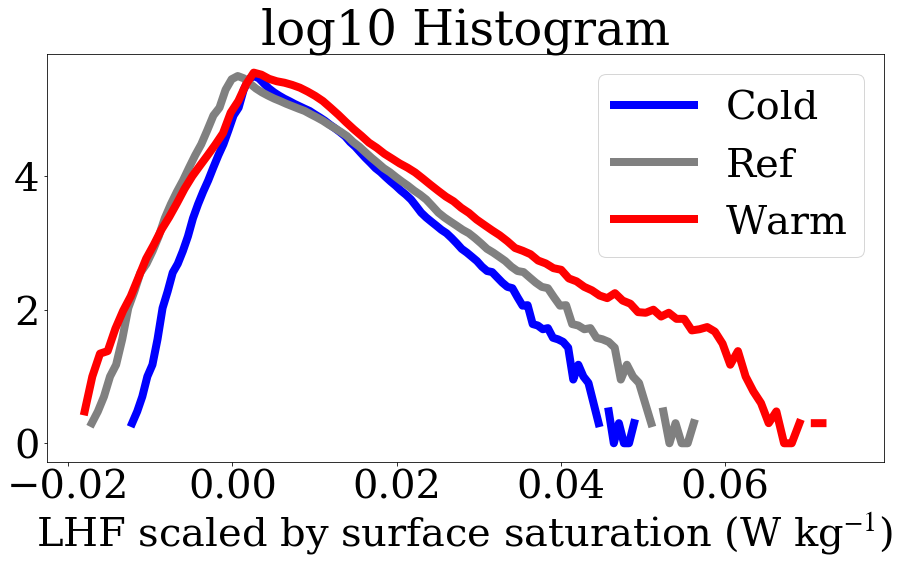

In [64]:
plt.figure(figsize=(15,7.5))
plt.plot(edg2bin(LHFSD2HIST['m4K'][1]),np.log10(LHFSD2HIST['m4K'][0]),color='b',label='Cold')
plt.plot(edg2bin(LHFSD2HIST['ref'][1]),np.log10(LHFSD2HIST['m4K'][0]),color='gray',label='Ref')
plt.plot(edg2bin(LHFSD2HIST['p4K'][1]),np.log10(LHFSD2HIST['p4K'][0]),color='r',label='Warm')
plt.xlabel('LHF scaled by surface saturation (W kg$^{-1}$)')
plt.title('log10 Histogram')
plt.legend(loc='upper right')

In [28]:
LHFscaledSD = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
    
    print('qsat, PW, CRH')
    qsat0 = qsat(d.TAP,1e5,d.PS,d.hyam,d.hybm)
    
    print('LHF')
    LHFscaledSD[data] = d.LHFLX/(L_V*(qsat0[:,-1,:,:]-d.QAP[:,-1,:,:]))
    print('\n')

data= m4K
qsat, PW, CRH
LHF


data= ref
qsat, PW, CRH
LHF


data= p4K
qsat, PW, CRH
LHF




In [29]:
LHFHIST = {}
LHFscaledSDHIST = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
        
    LHFHIST[data] = np.histogram(d.LHFLX.values.flatten(),bins=100)
    LHFscaledSDHIST[data] = np.histogram(LHFscaledSD[data].values.flatten(),bins=100)

data= m4K
data= ref
data= p4K


/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


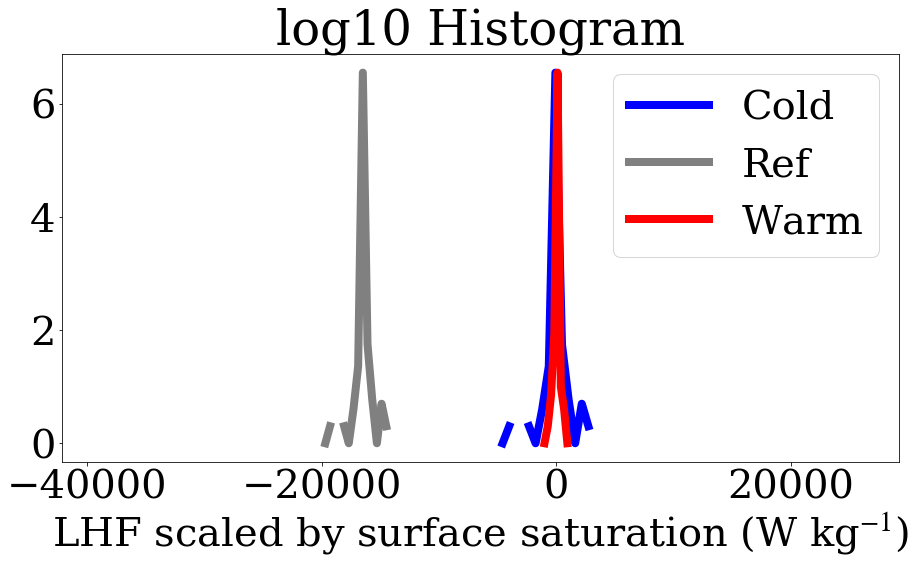

In [31]:
plt.figure(figsize=(15,7.5))
plt.plot(edg2bin(LHFscaledSDHIST['m4K'][1]),np.log10(LHFscaledSDHIST['m4K'][0]),color='b',label='Cold')
plt.plot(edg2bin(LHFscaledSDHIST['ref'][1]),np.log10(LHFscaledSDHIST['m4K'][0]),color='gray',label='Ref')
plt.plot(edg2bin(LHFscaledSDHIST['p4K'][1]),np.log10(LHFscaledSDHIST['p4K'][0]),color='r',label='Warm')
plt.xlabel('LHF scaled by surface saturation (W kg$^{-1}$)')
plt.title('log10 Histogram')
plt.legend(loc='upper right')

In [34]:
LHFscaledSSD = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
    
    print('qsat, PW, CRH')
    qsatS = qsatsurf(d.TS,d.P0,d.PS)
    
    print('LHF')
    LHFscaledSSD[data] = d.LHFLX/(L_V*(qsatS[:,:,:]-d.QAP[:,-1,:,:]))
    print('\n')



data= m4K
qsat, PW, CRH
LHF


data= ref
qsat, PW, CRH
LHF


data= p4K
qsat, PW, CRH
LHF




In [38]:
LHFscaledSSDHIST = {}

for idata,data in enumerate(['m4K','ref','p4K']):
    print('data=',data)
    
    if idata==0: d = datam4K
    elif idata==1: d = dataref
    elif idata==2: d = datap4K
        
    LHFscaledSSDHIST[data] = np.histogram(LHFscaledSSD[data].values.flatten(),bins=100)

data= m4K
data= ref
data= p4K


/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/DFS-L/DATA/pritchard/tbeucler/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


(-100, 100)

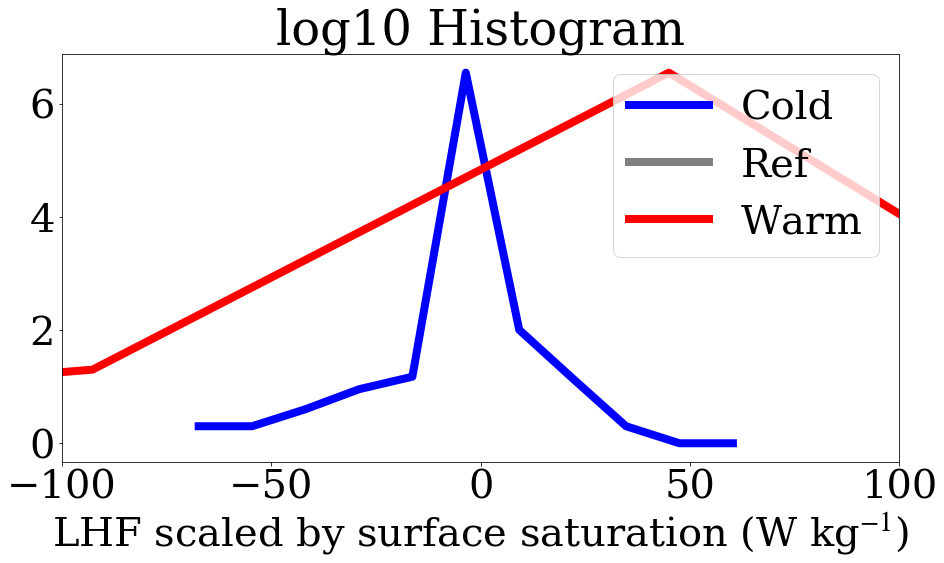

In [42]:
plt.figure(figsize=(15,7.5))
plt.plot(edg2bin(LHFscaledSSDHIST['m4K'][1]),np.log10(LHFscaledSSDHIST['m4K'][0]),color='b',label='Cold')
plt.plot(edg2bin(LHFscaledSSDHIST['ref'][1]),np.log10(LHFscaledSSDHIST['m4K'][0]),color='gray',label='Ref')
plt.plot(edg2bin(LHFscaledSSDHIST['p4K'][1]),np.log10(LHFscaledSSDHIST['p4K'][0]),color='r',label='Warm')
plt.xlabel('LHF scaled by surface saturation (W kg$^{-1}$)')
plt.title('log10 Histogram')
plt.legend(loc='upper right')
plt.xlim((-100,100))

# Imrove preprocessing script for $O_{3}$

## Preprocessing

In [11]:
path_O3 = '/export/nfs0home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/2021_01_24_O3.pkl' # Hardcode O3 path for now

In [12]:
TAP = datam4K.TAP

In [13]:
def compute_bp(ds, var):
    """GCM state at beginning of time step before physics.
    ?BP = ?AP - physical tendency * dt

    Args:
        ds: entire xarray dataset
        var: BP variable name

    Returns:
        bp: xarray dataarray containing just BP variable, with the first time step cut.
    """
    base_var = var[:-2] + 'AP'
    return (ds[base_var] - ds[phy_dict[base_var]] * DT)[1:]  # Not the first time step

In [14]:
phy_dict['T'] = 'TPHYSTND'

In [15]:
TBP = compute_bp(datam4K,'TAP')

In [16]:
dO3 = pickle.load(open(path_O3,'rb'))

In [17]:
O3 = dO3['O3_aqua']

In [23]:
O3_interpolated = O3.interp({"lev": TBP.lev}) 

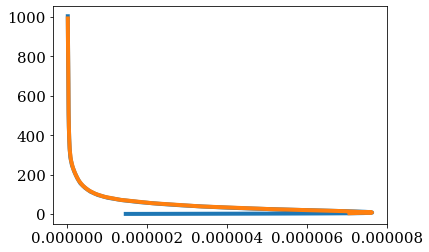

In [24]:
plt.plot(O3.mean(dim=('lat')),O3.lev)
plt.plot(O3_interpolated.mean(dim=('lat')),O3_itp.lev)

In [25]:
O3_interpolated.shape

(64, 30)

In [26]:
TBP.shape

(431, 30, 64, 128)

In [34]:
O3_reshaped = np.moveaxis(np.tile(O3_interpolated,(TBP.shape[0],TBP.shape[-1],1,1)),source=[1,2],destination=[3,2])

In [35]:
O3_reshaped.shape

(431, 30, 64, 128)

In [37]:
O3_reshaped = O3_reshaped+0*TBP**0

In [38]:
O3_reshaped

<xarray.DataArray (time: 431, lev: 30, lat: 64, lon: 128)>
dask.array<shape=(431, 30, 64, 128), dtype=float64, chunksize=(47, 30, 64, 128)>
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time     (time) float64 365.0 365.0 365.1 365.1 ... 373.9 373.9 374.0 374.0

In [42]:
O3_Lmean = O3_reshaped.mean(dim=('lat','lon','time'))

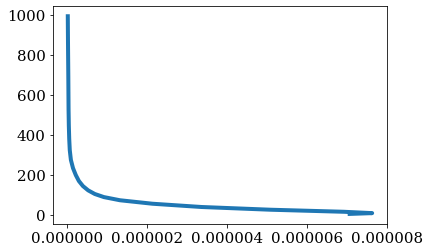

In [43]:
plt.plot(O3_Lmean,O3_Lmean.lev)

In [44]:
O3_lmean = O3_reshaped.mean(dim=('lon','time'))

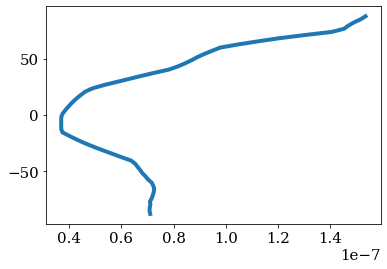

In [45]:
plt.plot(O3_lmean[15,:],O3_lmean.lat)

## Check preprocessing

In [60]:
path_folder = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'

In [61]:
test_preproc = xr.open_dataset(path_folder+'2021_01_24_NORM_O3_small.nc')

In [75]:
test_preproc

<xarray.Dataset>
Dimensions:           (var_names: 214, var_names_single: 11)
Coordinates:
  * var_names         (var_names) object 'QBP' 'QBP' 'QBP' ... 'QRS' 'QRS' 'QRS'
  * var_names_single  (var_names_single) object 'QBP' 'TBP' ... 'QRL' 'QRS'
Data variables:
    mean              (var_names) float64 ...
    std               (var_names) float64 ...
    min               (var_names) float64 ...
    max               (var_names) float64 ...
    std_by_var        (var_names_single) float64 ...

In [63]:
print(test_preproc.var_names)

<xarray.DataArray 'var_names' (var_names: 214)>
array(['QBP', 'QBP', 'QBP', ..., 'QRS', 'QRS', 'QRS'], dtype=object)
Coordinates:
  * var_names  (var_names) object 'QBP' 'QBP' 'QBP' 'QBP' ... 'QRS' 'QRS' 'QRS'


In [76]:
oz = test_preproc['mean']

In [77]:
oz.values

array([ 1.34937473e-06,  1.31343331e-06,  1.08532610e-06,  1.15688249e-06,
        1.13117293e-06,  1.11655880e-06,  1.13724015e-06,  1.21084406e-06,
        1.37536440e-06,  1.82399217e-06,  3.32074467e-06,  7.77086272e-06,
        1.85950039e-05,  4.11459191e-05,  8.63846857e-05,  1.69385693e-04,
        3.12721841e-04,  5.58001289e-04,  9.55813639e-04,  1.53020486e-03,
        2.36349273e-03,  3.60855338e-03,  4.97421819e-03,  5.76664708e-03,
        6.34710349e-03,  6.87083335e-03,  7.30065596e-03,  7.62099791e-03,
        7.80885332e-03,  8.26899336e-03,  2.24205113e+02,  2.17551527e+02,
        2.01851282e+02,  2.19541061e+02,  2.16234234e+02,  2.11393776e+02,
        2.07223256e+02,  2.06210525e+02,  2.06687567e+02,  2.07859424e+02,
        2.09384400e+02,  2.11108453e+02,  2.13668612e+02,  2.17621510e+02,
        2.23145402e+02,  2.29927862e+02,  2.37551056e+02,  2.45584292e+02,
        2.53666211e+02,  2.60836547e+02,  2.66470130e+02,  2.70385192e+02,
        2.72945642e+02,  

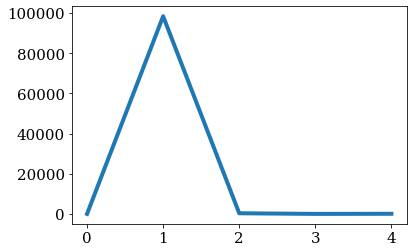

In [89]:
plt.plot(oz[-125:-120])